In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.display import Markdown
def print_markdown(string):
    display(Markdown(string))
def printmd(string):
    display(Markdown(string))
    
img_counter = 1 # useful to save images
img_dir = 'images/' # useful to save images
image_format = 'pdf' # useful to save images

# Pandemic simulation without vaccination

## Symmetric k-regular undirected graph

In [2]:
n_nodes = 500
k = 4

In [3]:
nodes = list(range(1, n_nodes+1))

In [4]:
edges = []
for i in range(n_nodes):
    for close_index in range(1,int(k/2)+1):
        j = ((i%n_nodes)+close_index)%n_nodes
        edges.append((i+1, j+1)) # nodes start from 1

In [5]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [ ]:
fig = plt.figure(figsize=(20, 20))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)
fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1

### Epidemic simulation

In [2]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))
    
def is_infected(n):
    return n%3==1

def recover(n):
    return n+1

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2


In [8]:
# Number of agents
n_agents = len(G)
ro = 0.7
beta = 0.3
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

In [9]:
n_infected_initial = 10
weeks = 15

In [86]:
# Simulates an epidemic on an unweighted graph whith adjacency matrix W.
# Diseas propagation model is a discrete-time version of the SIR epidemic model.
# 'A': dictionary with possible states.
# 'beta': probability that the infection is spread from an infected individual to a susceptible one (given that they are connected by a link) during one time step.
# 'ro': probability that an infected individual will recover during one time step.
# 'vacc_percentage': percentage of vaccinated individuals, i-th element represents the percentage of vaccinated individuals by time unit i. It makes sense only if 'vaccination' is set to True.
# 'n_infected_initial': number of infected nodes in initial configuration.
# 'n_steps': time units for which the simulation will go on.
# 'initial_configuration': method to generate initial configuaration. Possible choices = ['random','equally spaced','all grouped','equally spaced groups:n'] with n number of groups
# 'vaccination': determines if the epidemics has to be simulated with vaccination (True) or not (False).

# It returns a matrix such that:
# each row i represents the state of each agent at time i.
# each column j represents the state of agent j.

def simulate(A, W, beta, ro, n_infected_initial = 10, n_steps = 15, initial_configuration = 'random', vacc_percentage = None, vaccination = False):
    
    n_steps += 1 #(week 0: initial situation)
    n_agents = W.shape[0]
    
    if vaccination:
        vacc_percentage_perWeek = np.diff(vacc_percentage)/100
    
    # store the ids of visited configurations, describing the state of each agent
    states = np.full((n_steps, n_agents), A['susceptible'], dtype=int)
    # in the initial configuration, n_infected_initial random agents are infected
    x0 = np.full(n_agents, A['susceptible'])
    if initial_configuration == 'random':
        x0[np.random.choice(n_agents, n_infected_initial, replace=False)] = A['infected'] # replace=False to avoid the same node be chosen twice
    if initial_configuration == 'equally spaced':
        rate = round(n_agents / n_infected_initial) # number of elements between 2 infected nodes (to be precise: rate = (number of elements between 2 infected nodes) + 1)
        inf_node = np.random.choice(rate, 1)[0] # infected node between nodes (0,...rate-1)
        i = inf_node
        while i < n_agents:
            x0[i] = A['infected']
            i+=rate
    if initial_configuration == 'all grouped':
        inf_node = np.random.choice(n_agents, 1)[0] # infected node in the center of the group
        x0[inf_node] = A['infected']
        n_inf = 1
        i = 1
        up = True
        while(n_inf<n_infected_initial):
            if up:
                x0[(inf_node+i)%n_agents] = A['infected']
                up = False
            else:
                x0[(inf_node-i)%n_agents] = A['infected']
                up = True
                i+=1
            n_inf+=1
    if initial_configuration.split(":")[0] == 'equally spaced groups':
        n_groups = int(initial_configuration.split(":")[1])
        nodes_per_group = [a.shape[0] for a in np.array_split(range(n_infected_initial), n_groups)] # number of nodes in each group
        rate = round(n_agents / n_groups) # number of elements between 2 infected groups of nodes (their central nodes) (to be precise: rate = (number of elements between 2 infected nodes) + 1)
        inf_node = np.random.choice(n_agents, 1)[0] # central infected node between nodes (0,...n_agents-1) in the first group
        i = inf_node
        tot_inf = 0 # infected nodes counter
        gr = 0 # groups counter
        while tot_inf < n_infected_initial:
            x0[i] = A['infected']
            tot_inf+=1
            n_inf = 1 # infected nodes of group 'gr' counter
            j = 1
            up = True
            while(n_inf<nodes_per_group[gr] and tot_inf<n_infected_initial):
                if up:
                    x0[(i+j)%n_agents] = A['infected']
                    tot_inf+=1
                    up = False
                else:
                    x0[(i-j)%n_agents] = A['infected']
                    tot_inf+=1
                    up = True
                    j+=1
                n_inf+=1
            i+=rate
            i=i%n_agents
            gr+=1
    # define initial state id (time 0)
    states[0] = x0

    if vaccination:
        # administrate vaccinations
        vacc_ind = np.random.choice(np.where(is_notVaccinated(states[0]))[0], round(vacc_percentage_perWeek[0]*n_agents), replace=False)
        states[0, vacc_ind] = administer_vaccinate(states[0, vacc_ind])
    
    # for each step of the simulation
    for i in range(1,n_steps): # for each unit of time
        for j in range(n_agents): # for each agent
            if states[i-1,j] == A['susceptible']: # if j-th agent is 'susceptible'
                m = np.sum(states[i-1][np.where(W[j]==1)[1]]==A['infected']) # calculate the number of infected neighbours of j-th agent
                probability = 1 - ((1-beta)**m) # calculate probability for j-th agent to get infected
                if np.random.rand() < probability:
                    states[i,j] = A['infected'] # j-th agent get infected
                else:
                    states[i,j] = states[i-1,j] # j-th agent does not get infected
            elif is_infected(states[i-1,j]): # if j-th agent is 'infected' or 'infected but vaccinated'
                probability = ro # calculate probability for j-th agent to get recovered
                if np.random.rand() < probability:
                    states[i,j] = recover(states[i-1,j]) # j-th agent get recovered
                else:
                    states[i,j] = states[i-1,j] # j-th agent does not get recovered
            else: # if j-th agent is 'recovered' or 'susceptible but vaccinated' or 'recovered but vaccinated' 
                states[i,j] = states[i-1,j] # j-th agent does not modify its state
             
        if vaccination:
            # administrate vaccinations
            vacc_ind = np.random.choice(np.where(is_notVaccinated(states[i]))[0], round(vacc_percentage_perWeek[i]*n_agents), replace=False)
            states[i, vacc_ind] = administer_vaccinate(states[i, vacc_ind])
            
    return states

In [11]:
# run 1 simulation and plot state values at each time unit.
states = simulate(A, W, beta, ro, n_infected_initial, weeks)
A_rev = dict((v,k) for k,v in A.items())
for t in range(0,weeks+1):
    x = states[t]
    print("Time unit " + str(t))
    print("state:")
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(1, len(G)+1), columns=['state'])) # nodes start from 0
    n_susc = np.sum(x==A['susceptible'])
    n_inf = np.sum(x==A['infected'])
    n_rec = np.sum(x==A['recovered'])
    print("Susceptible agents =", n_susc)
    print("Infected agents =", n_inf)
    print("Recovered agents =", n_rec)
    print()

Time unit 0
state:


state
1    susceptible
2    susceptible
3    susceptible
4    susceptible
5    susceptible
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 490
Infected agents = 10
Recovered agents = 0

Time unit 1
state:


state
1    susceptible
2    susceptible
3    susceptible
4    susceptible
5    susceptible
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 476
Infected agents = 15
Recovered agents = 9

Time unit 2
state:


state
1    susceptible
2    susceptible
3    susceptible
4    susceptible
5    susceptible
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 466
Infected agents = 16
Recovered agents = 18

Time unit 3
state:


state
1    susceptible
2    susceptible
3    susceptible
4    susceptible
5       infected
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 451
Infected agents = 25
Recovered agents = 24

Time unit 4
state:


state
1    susceptible
2    susceptible
3       infected
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 439
Infected agents = 18
Recovered agents = 43

Time unit 5
state:


state
1    susceptible
2    susceptible
3       infected
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 431
Infected agents = 17
Recovered agents = 52

Time unit 6
state:


state
1       infected
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 423
Infected agents = 13
Recovered agents = 64

Time unit 7
state:


state
1       infected
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499  susceptible
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 420
Infected agents = 7
Recovered agents = 73

Time unit 8
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499     infected
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 415
Infected agents = 5
Recovered agents = 80

Time unit 9
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499     infected
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 411
Infected agents = 6
Recovered agents = 83

Time unit 10
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 409
Infected agents = 4
Recovered agents = 87

Time unit 11
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 407
Infected agents = 3
Recovered agents = 90

Time unit 12
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 406
Infected agents = 2
Recovered agents = 92

Time unit 13
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 404
Infected agents = 2
Recovered agents = 94

Time unit 14
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 402
Infected agents = 2
Recovered agents = 96

Time unit 15
state:


state
1      recovered
2    susceptible
3      recovered
4    susceptible
5      recovered
..           ...
496  susceptible
497  susceptible
498  susceptible
499    recovered
500  susceptible

[500 rows x 1 columns]

Susceptible agents = 402
Infected agents = 1
Recovered agents = 97



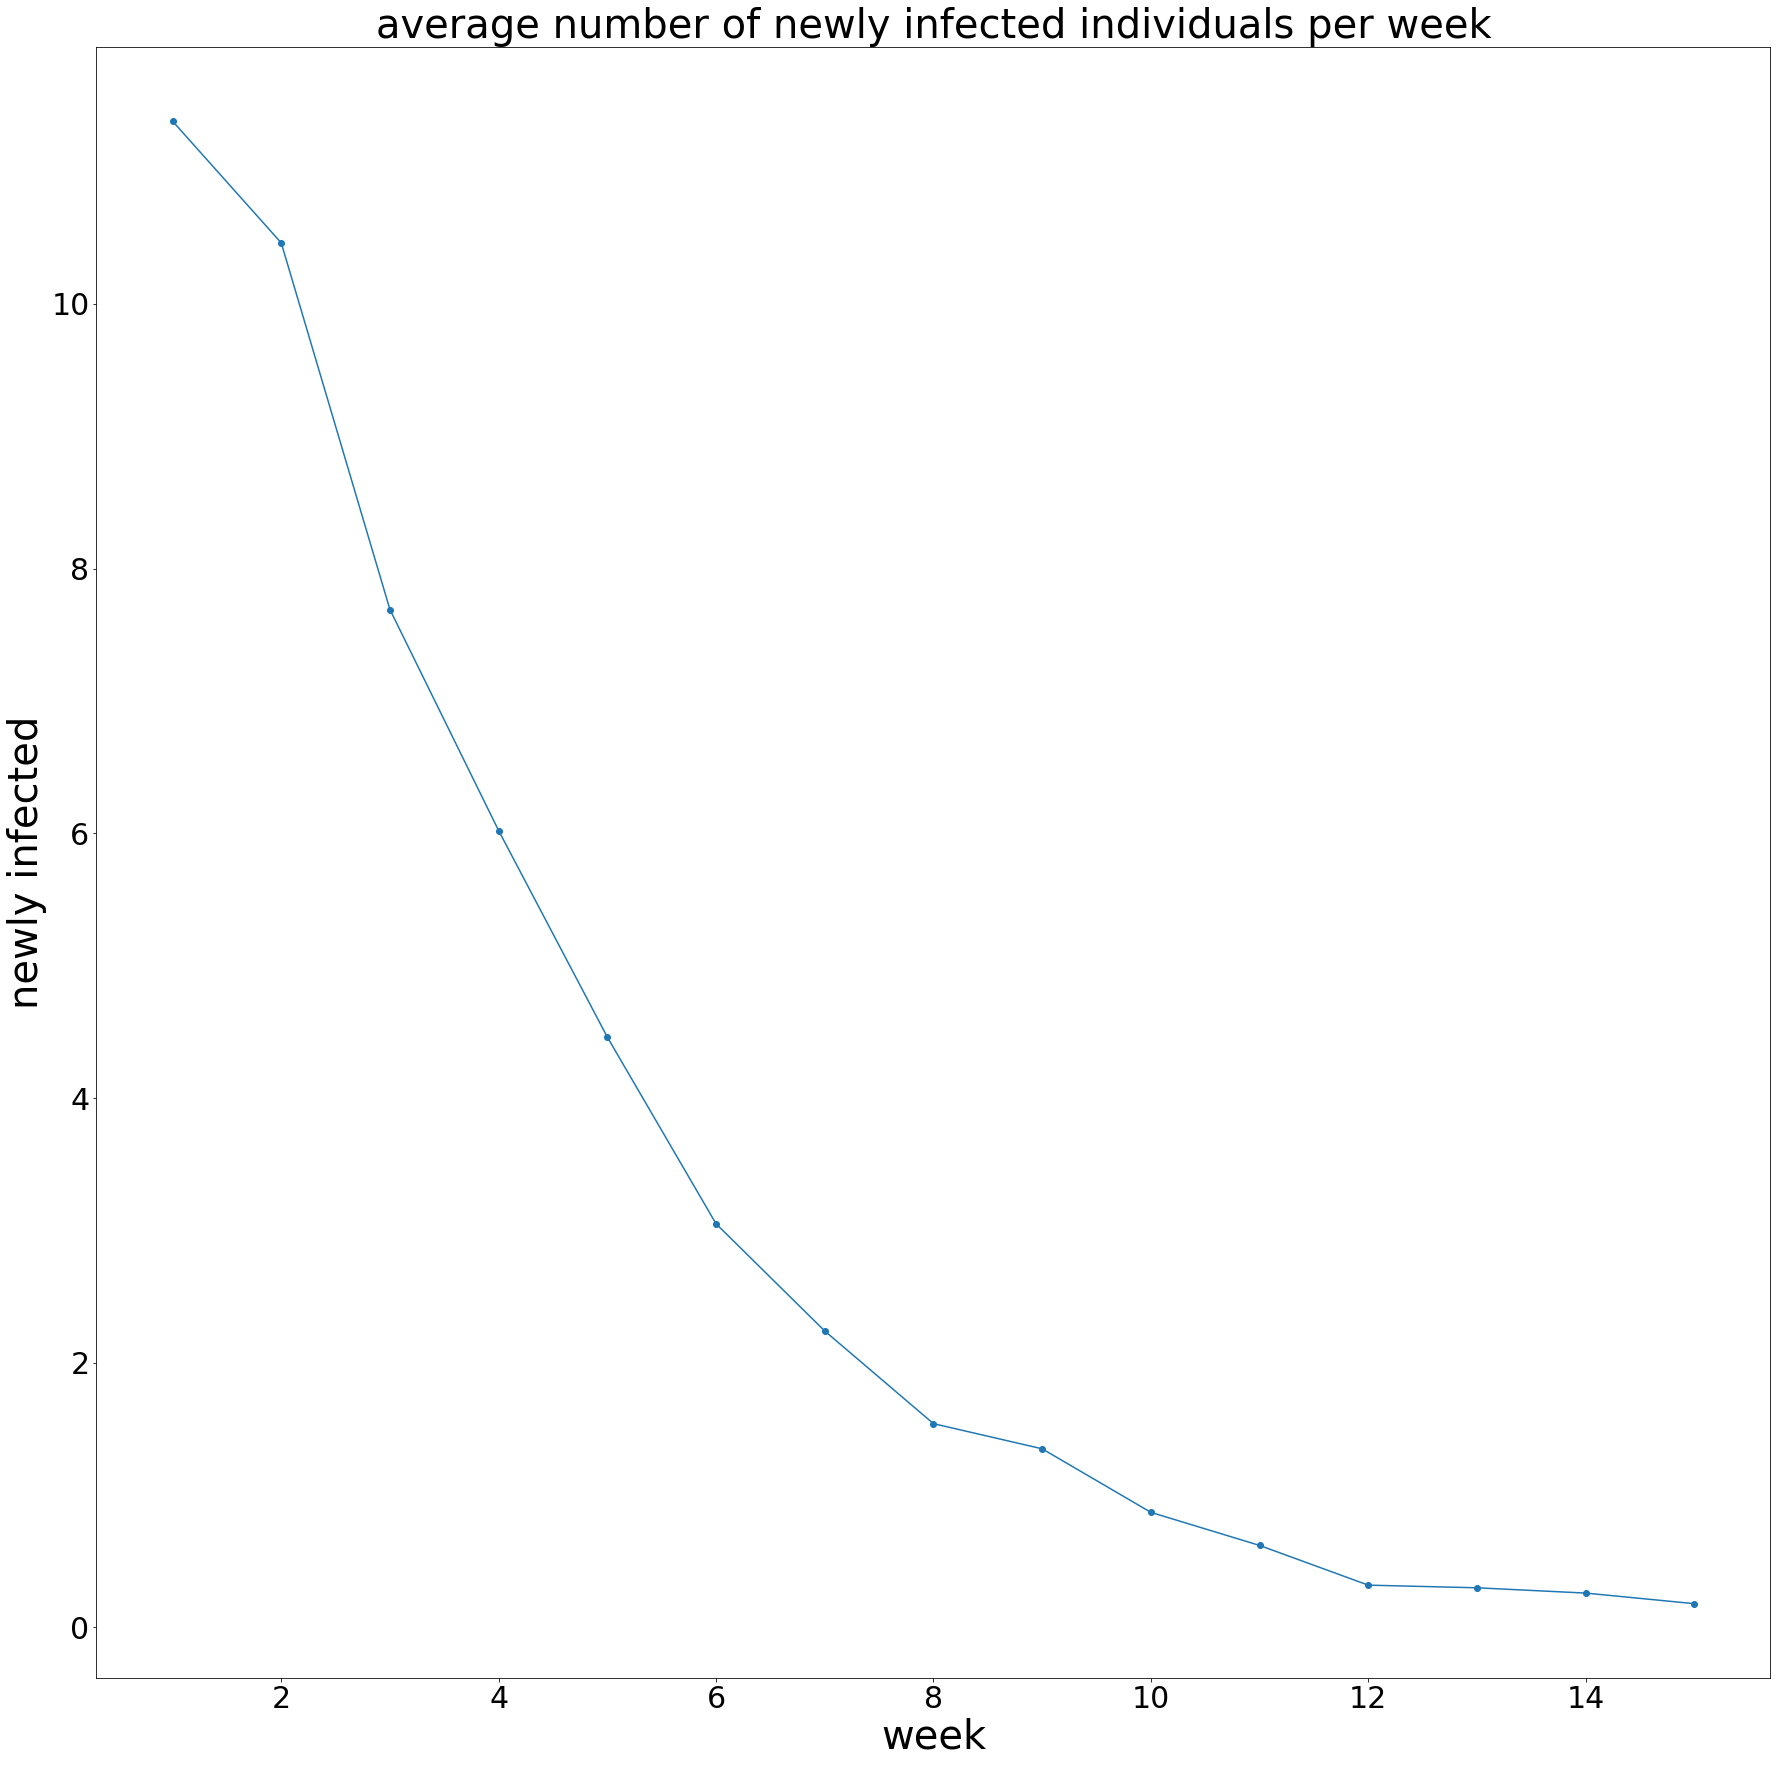

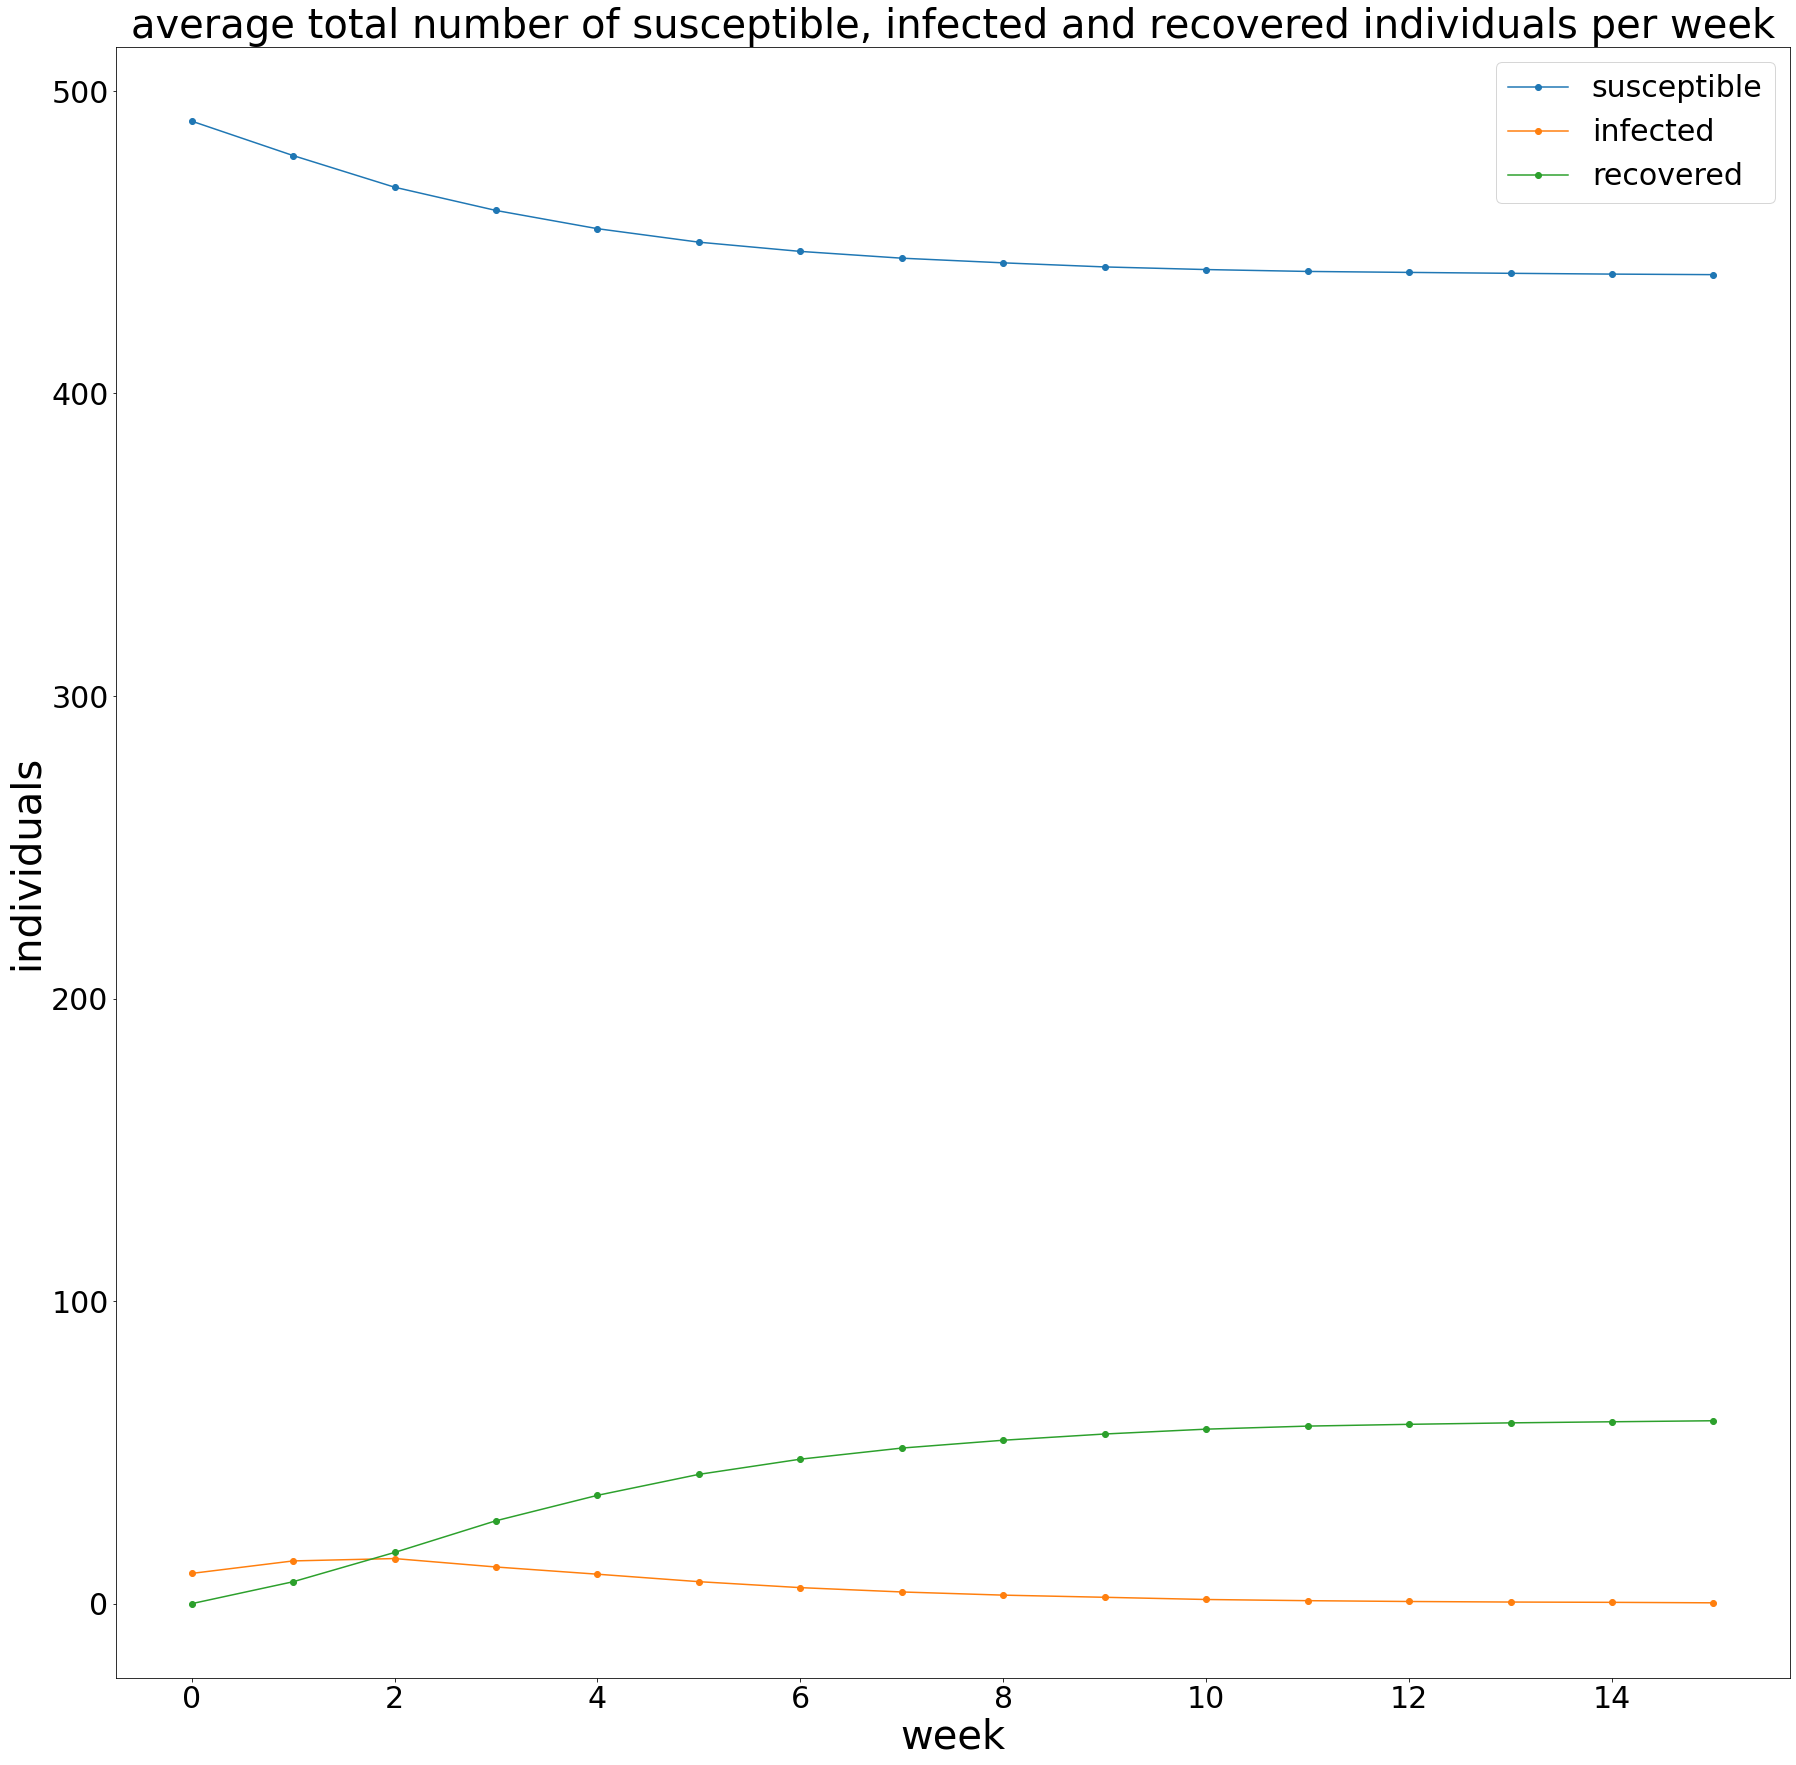

In [12]:
n_simulations = 100
stats = np.zeros((len(A), n_simulations, weeks+1))
cum_newly_infected = np.zeros((n_simulations, weeks))
A_rev = dict((v,k) for k,v in A.items())
for i in range(n_simulations):
    states = simulate(A, W, beta, ro, n_infected_initial, weeks)
    newly_infected = np.array([np.sum(np.logical_and(states[i-1]==A['susceptible'], states[i]==A['infected'])) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    n_susc_per_week = np.sum(states==A['susceptible'],axis=1)
    n_inf_per_week = np.sum(states==A['infected'],axis=1)
    n_rec_per_week = np.sum(states==A['recovered'],axis=1)
    cum_newly_infected[i] = newly_infected
    stats[0,i] = n_susc_per_week
    stats[1,i] = n_inf_per_week
    stats[2,i] = n_rec_per_week
    
avg_newly_infected = np.mean(cum_newly_infected,axis=0)
avg_stats = np.mean(stats,axis=1)

fig_a = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_infected, '-o')

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig_a.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


fig_b = plt.figure(figsize=(30, 30))
for state in range(len(A)):
    plt.plot(np.arange(weeks+1), avg_stats[state], '-o', label = A_rev[state])

plt.title('average total number of susceptible, infected and recovered individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('individuals', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig_b.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1

In [ ]:
n_steps = weeks

# Plot the infection spread

pos = nx.circular_layout(G)
for t in range(0,n_steps):
    plt.figure(figsize=(20,20))
    x = states[t]
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(1, len(G)+1), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==0).T[0]+1).tolist(), # nodes start from 1
        node_color = 'r',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==1).T[0]+1).tolist(), # nodes start from 1
        node_color = 'b',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==2).T[0]+1).tolist(), # nodes start from 1
        node_color = 'g',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    plt.title('jump step = {0}'.format(t+1), fontsize=30)

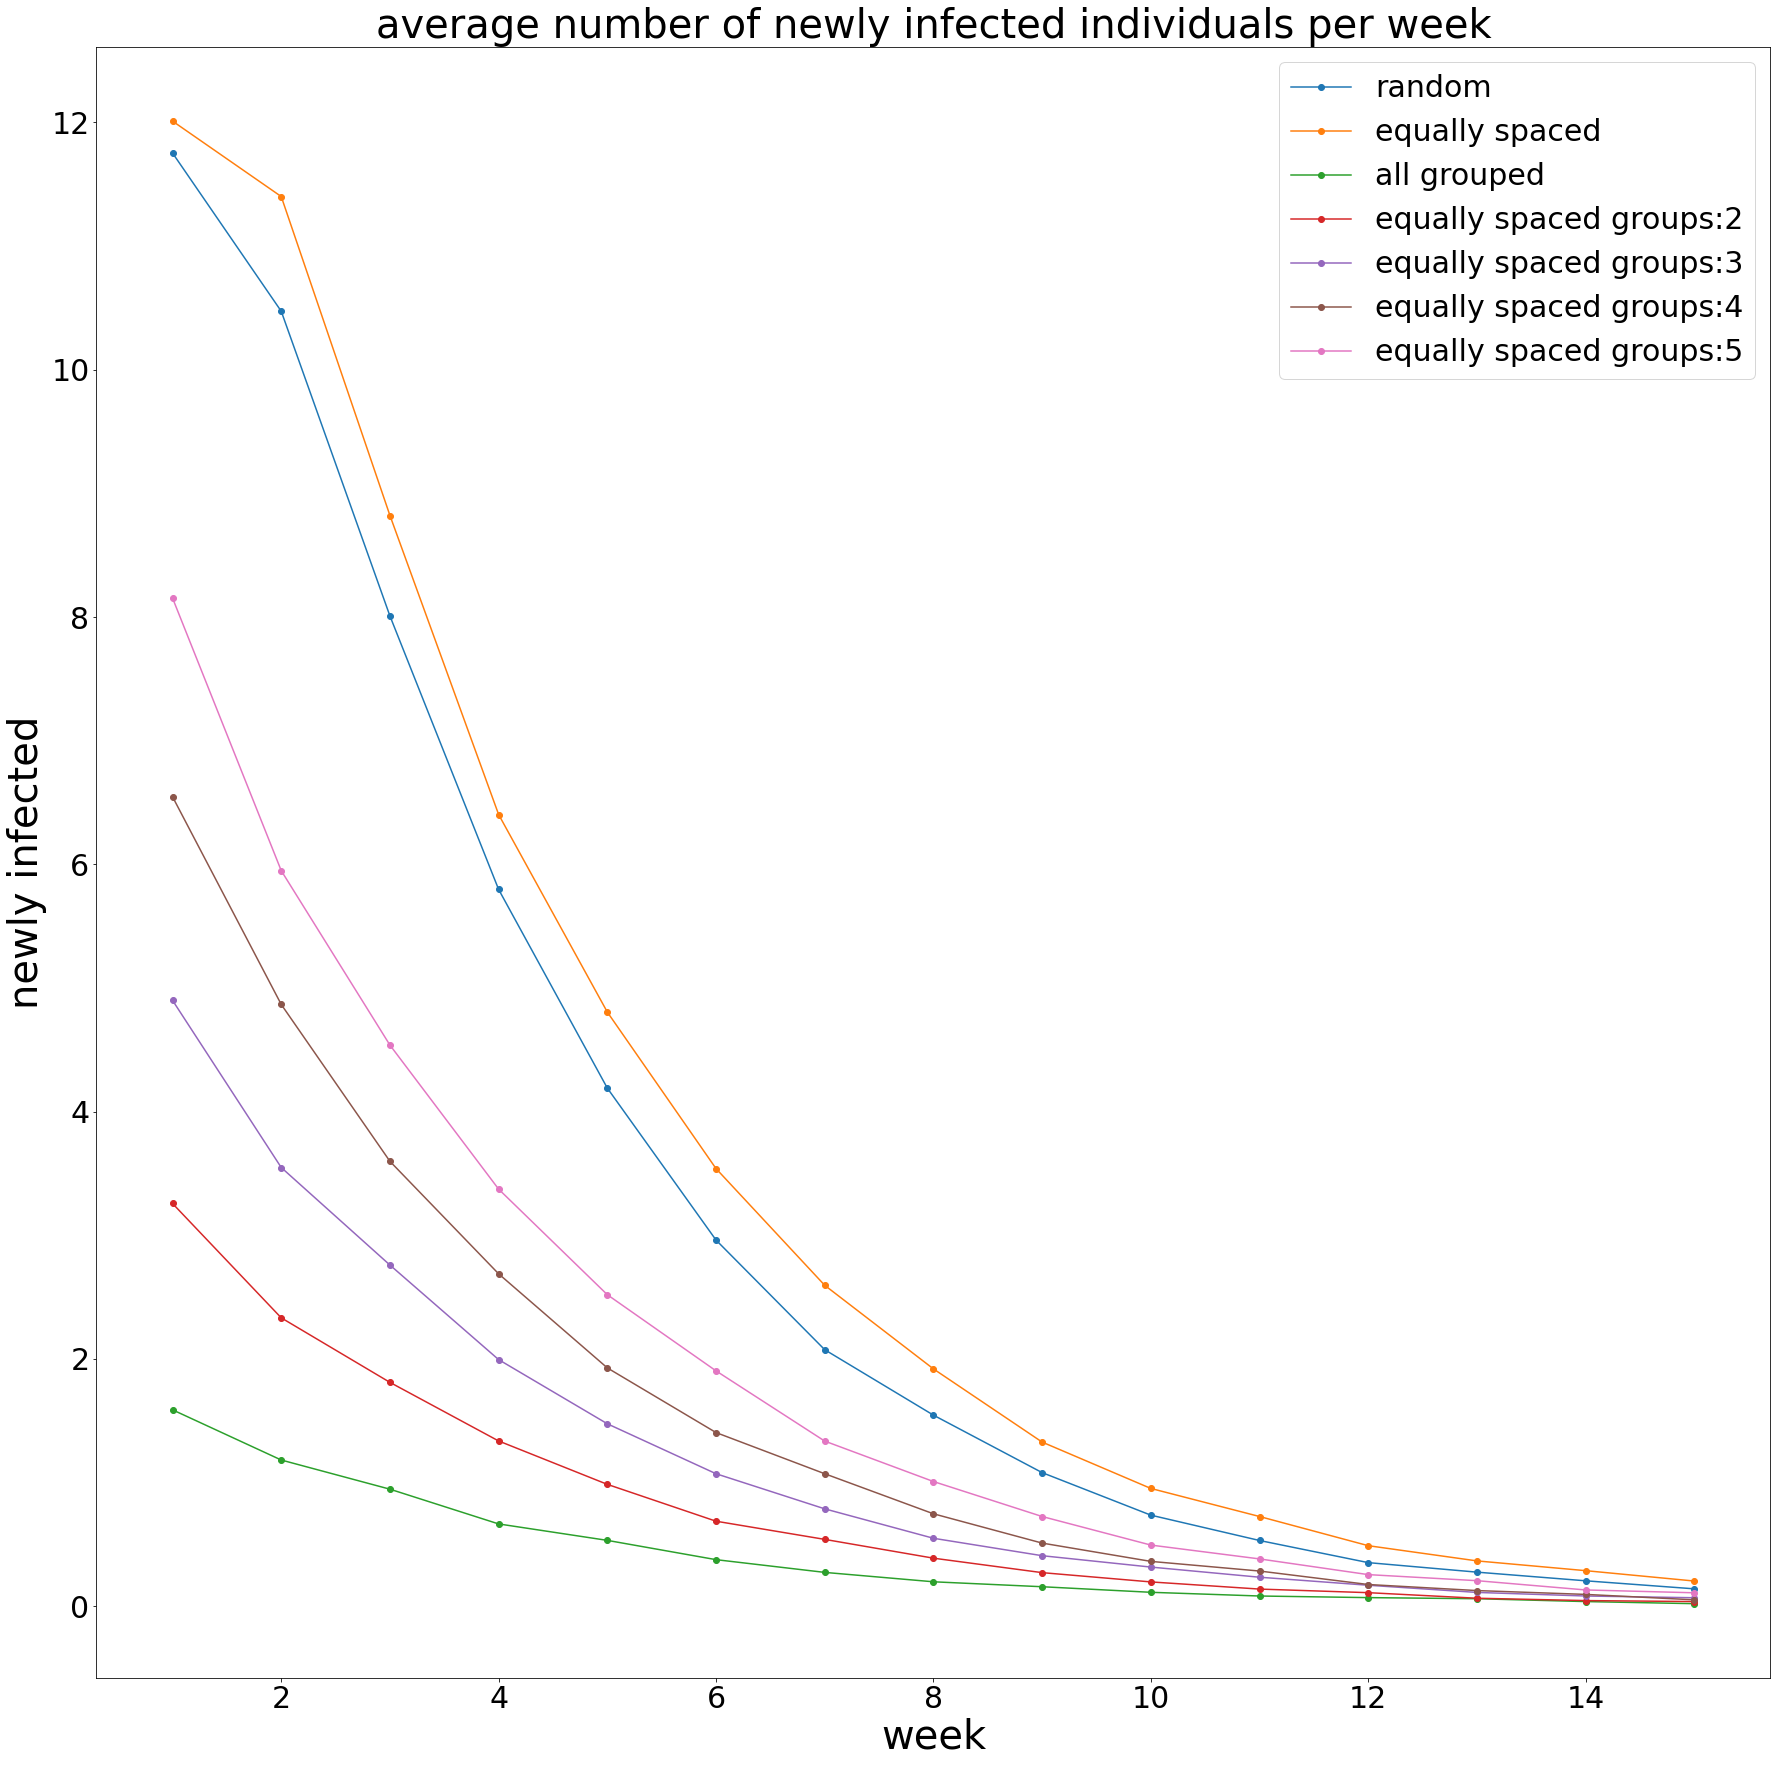

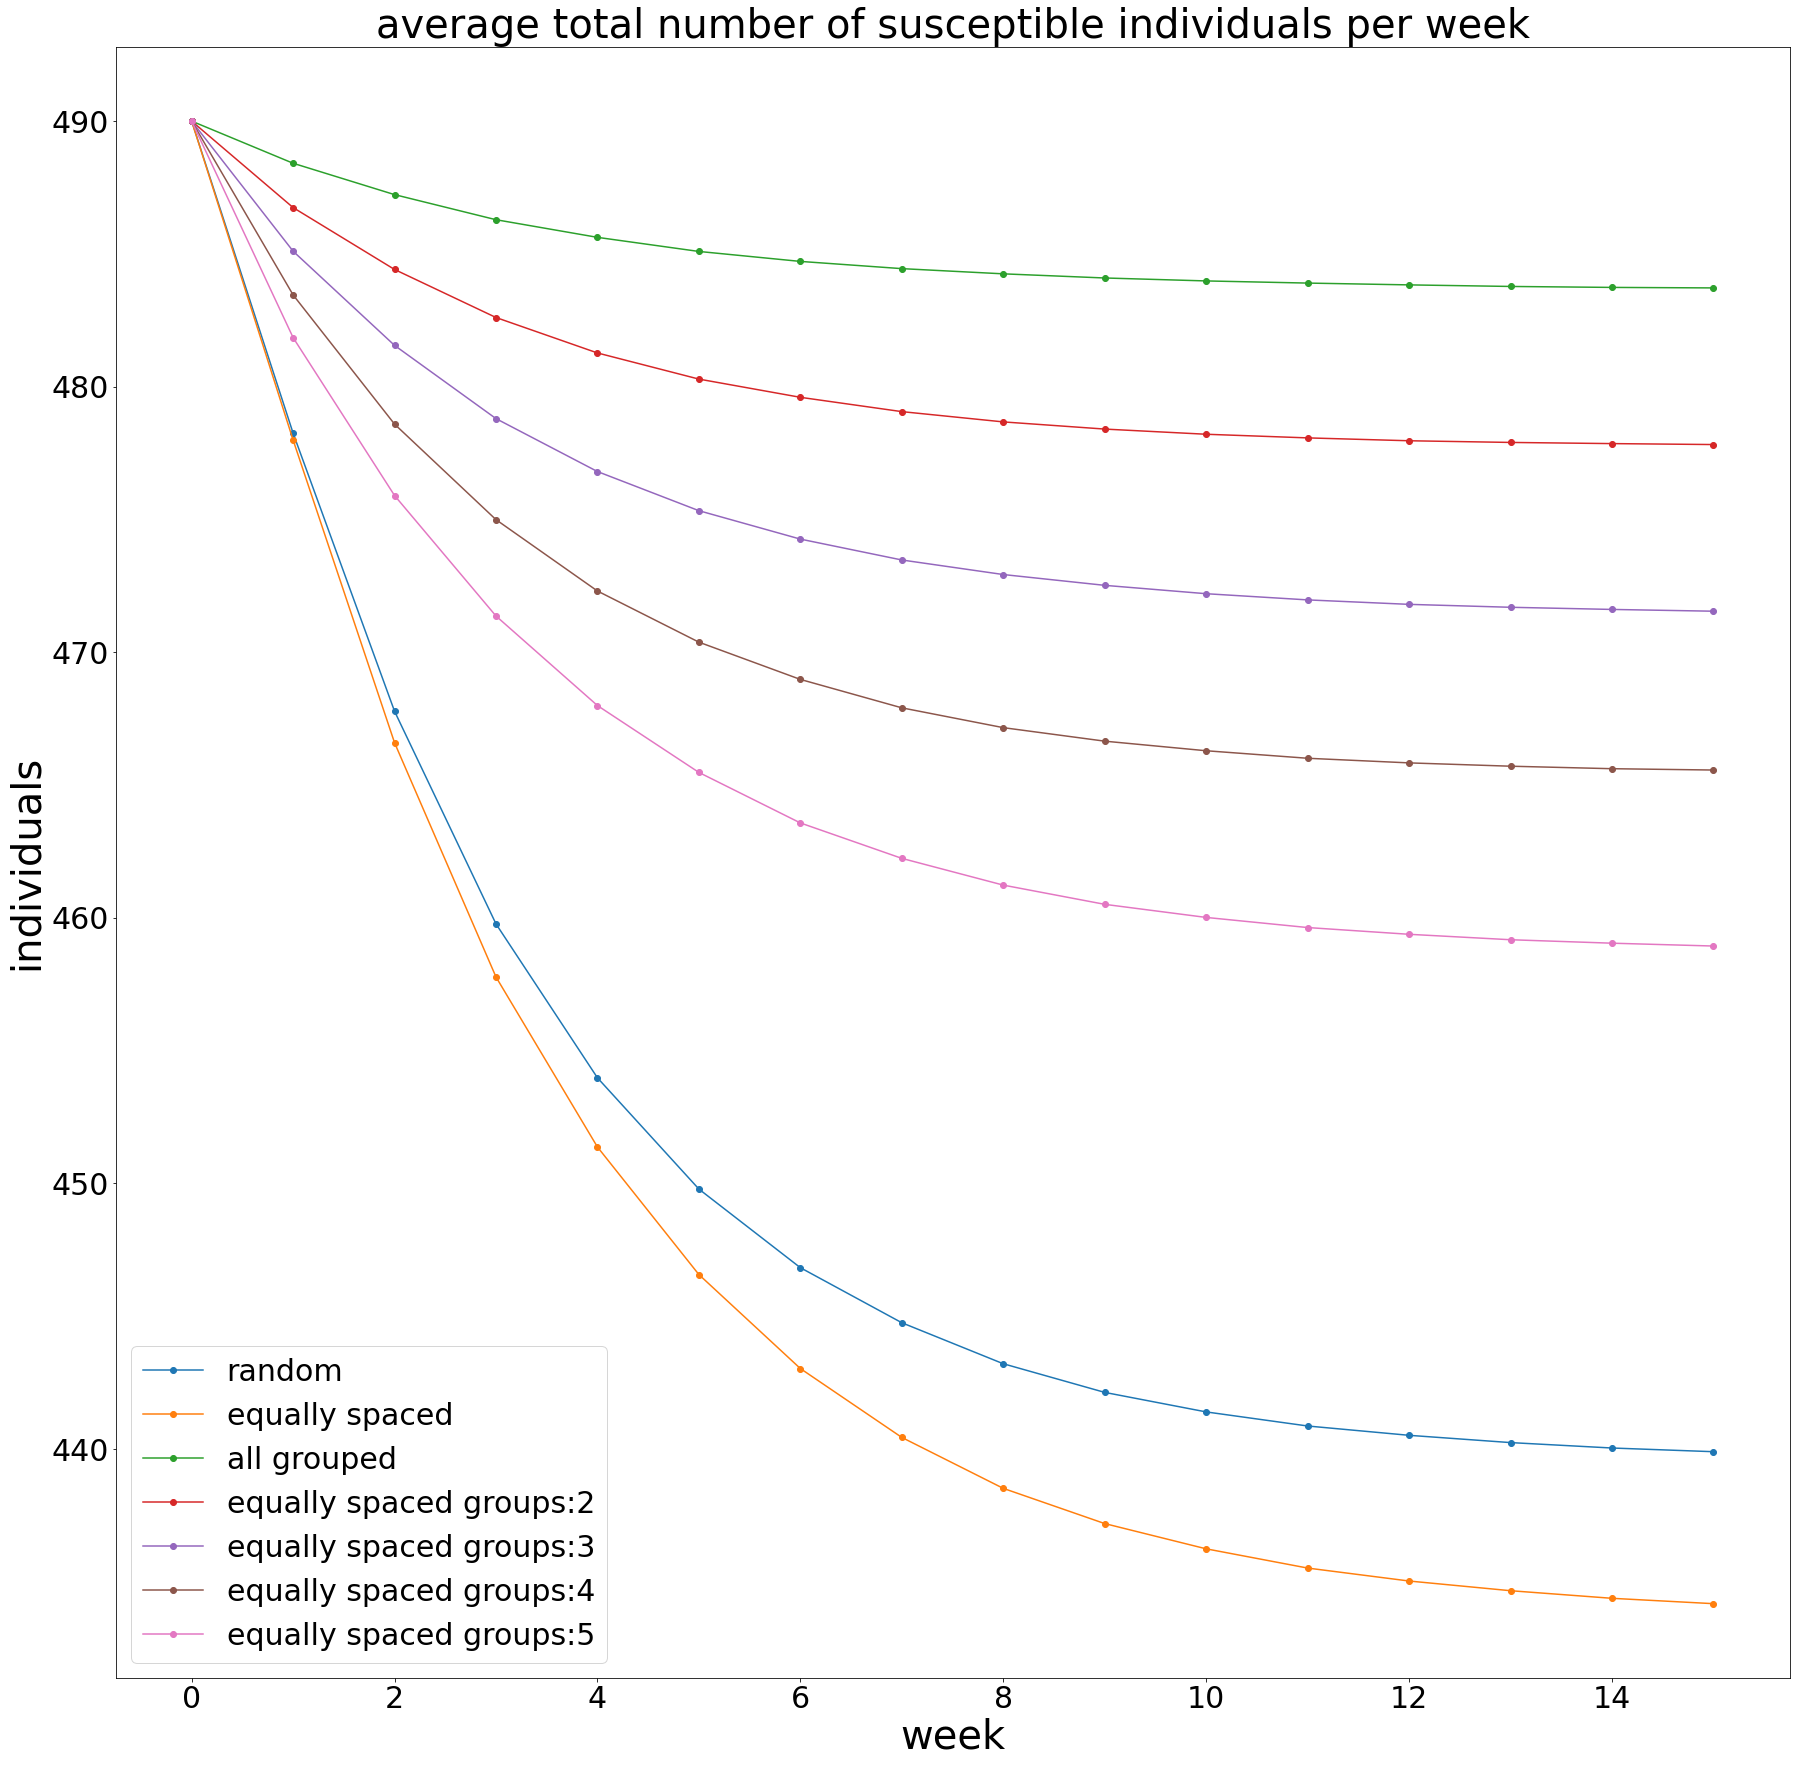

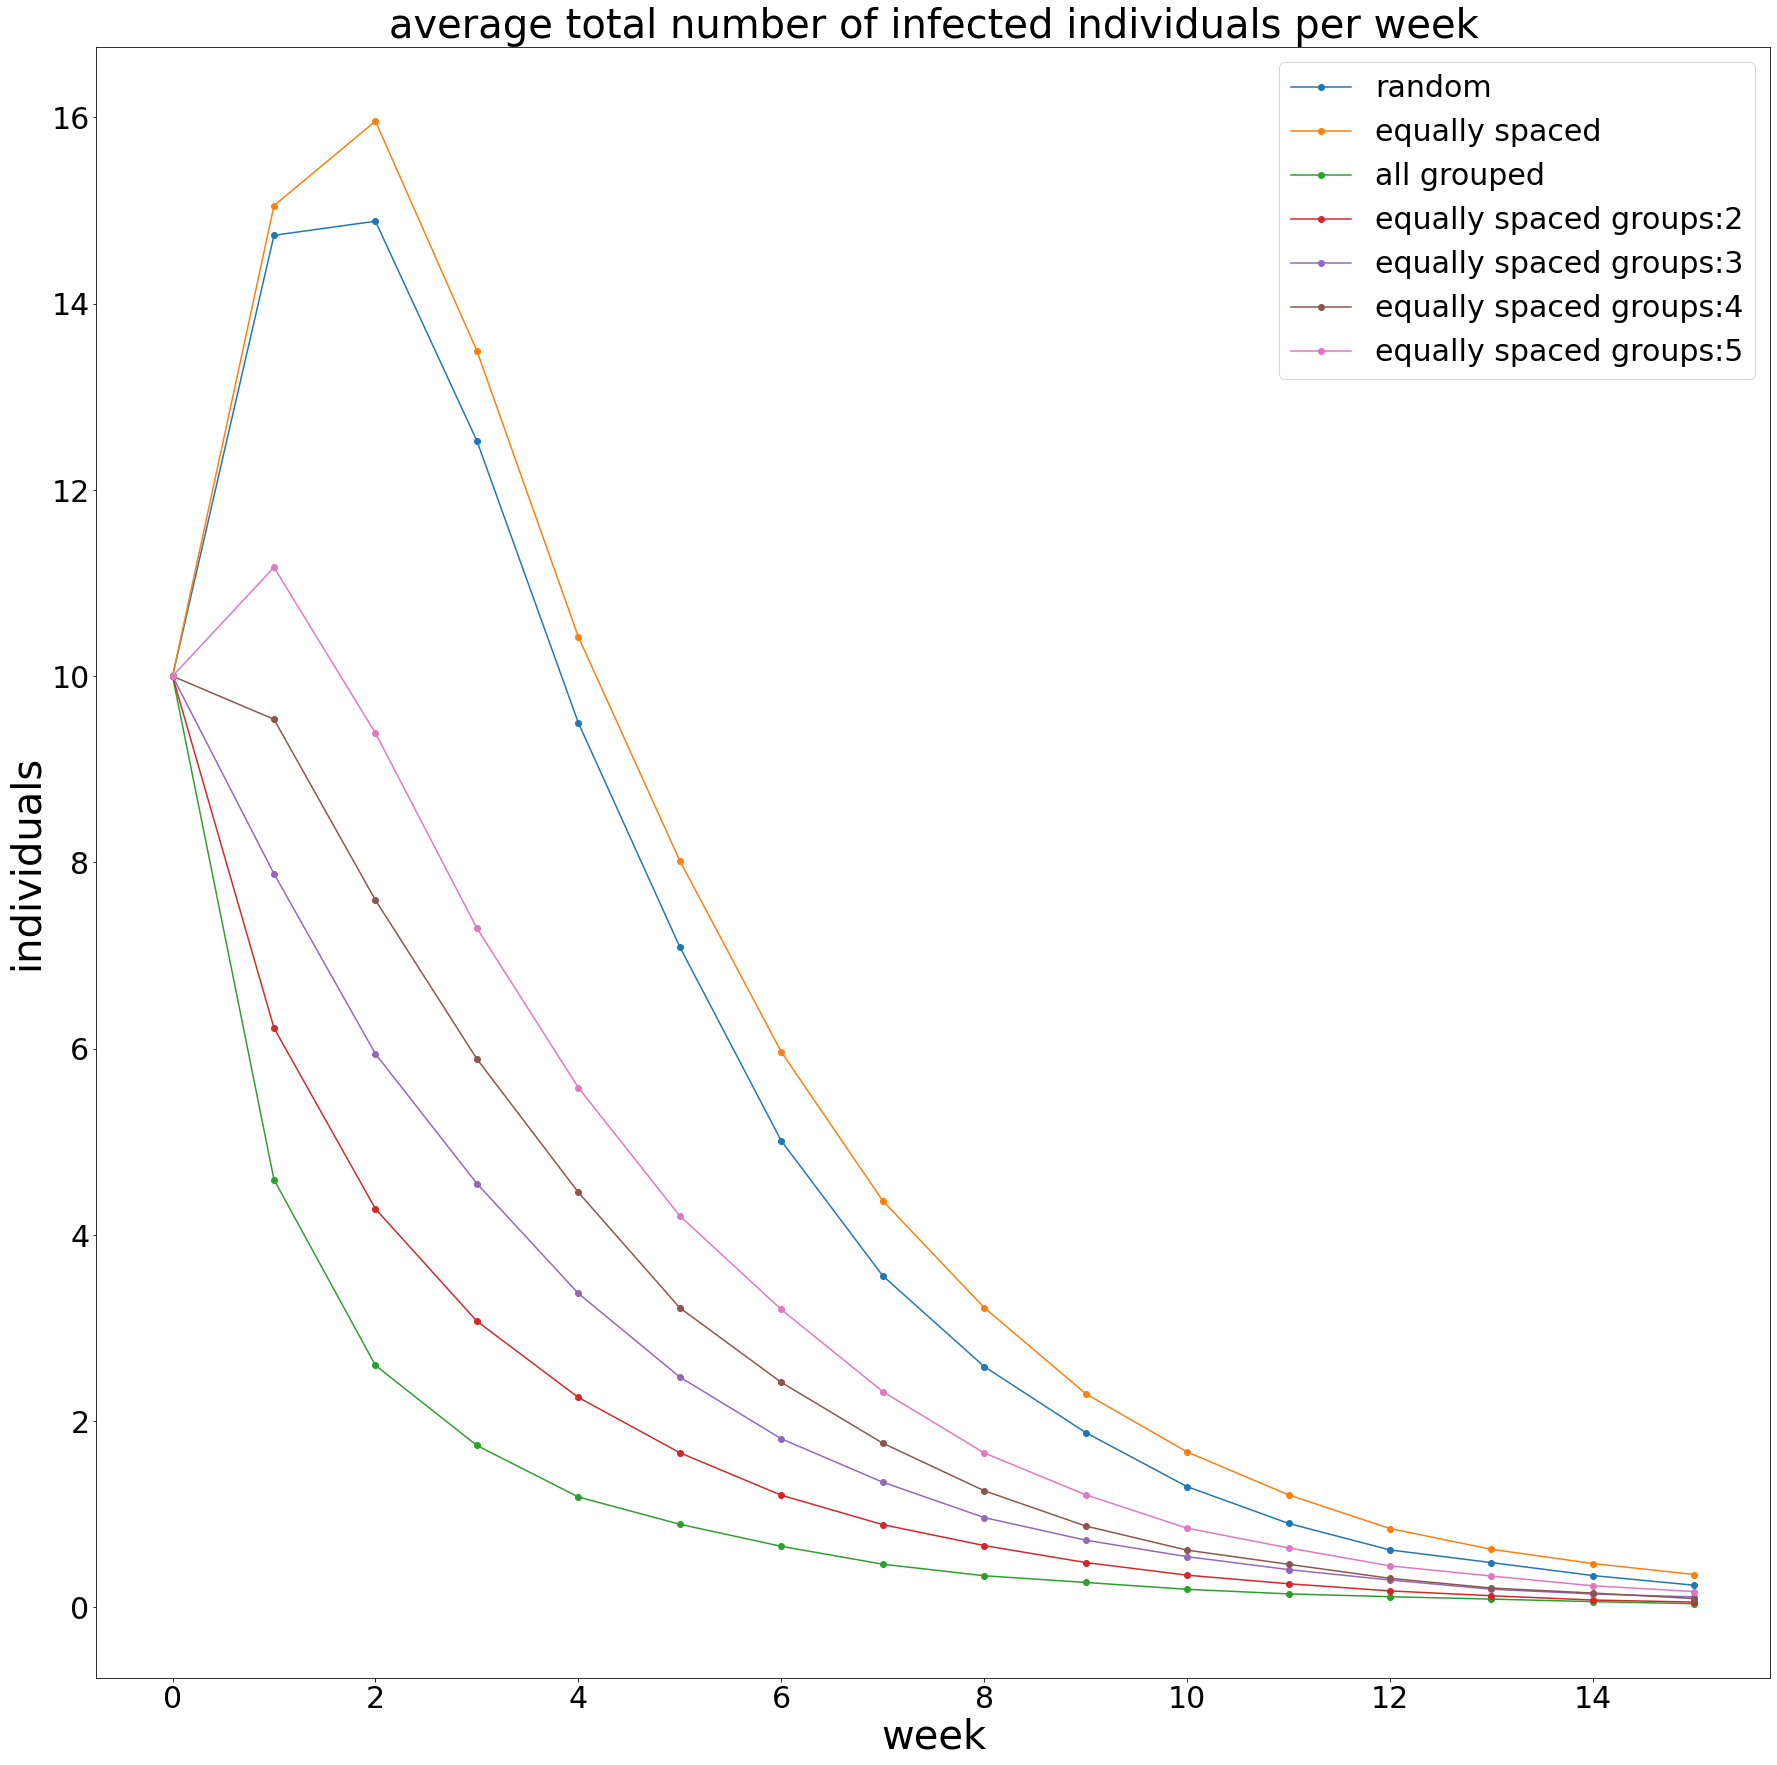

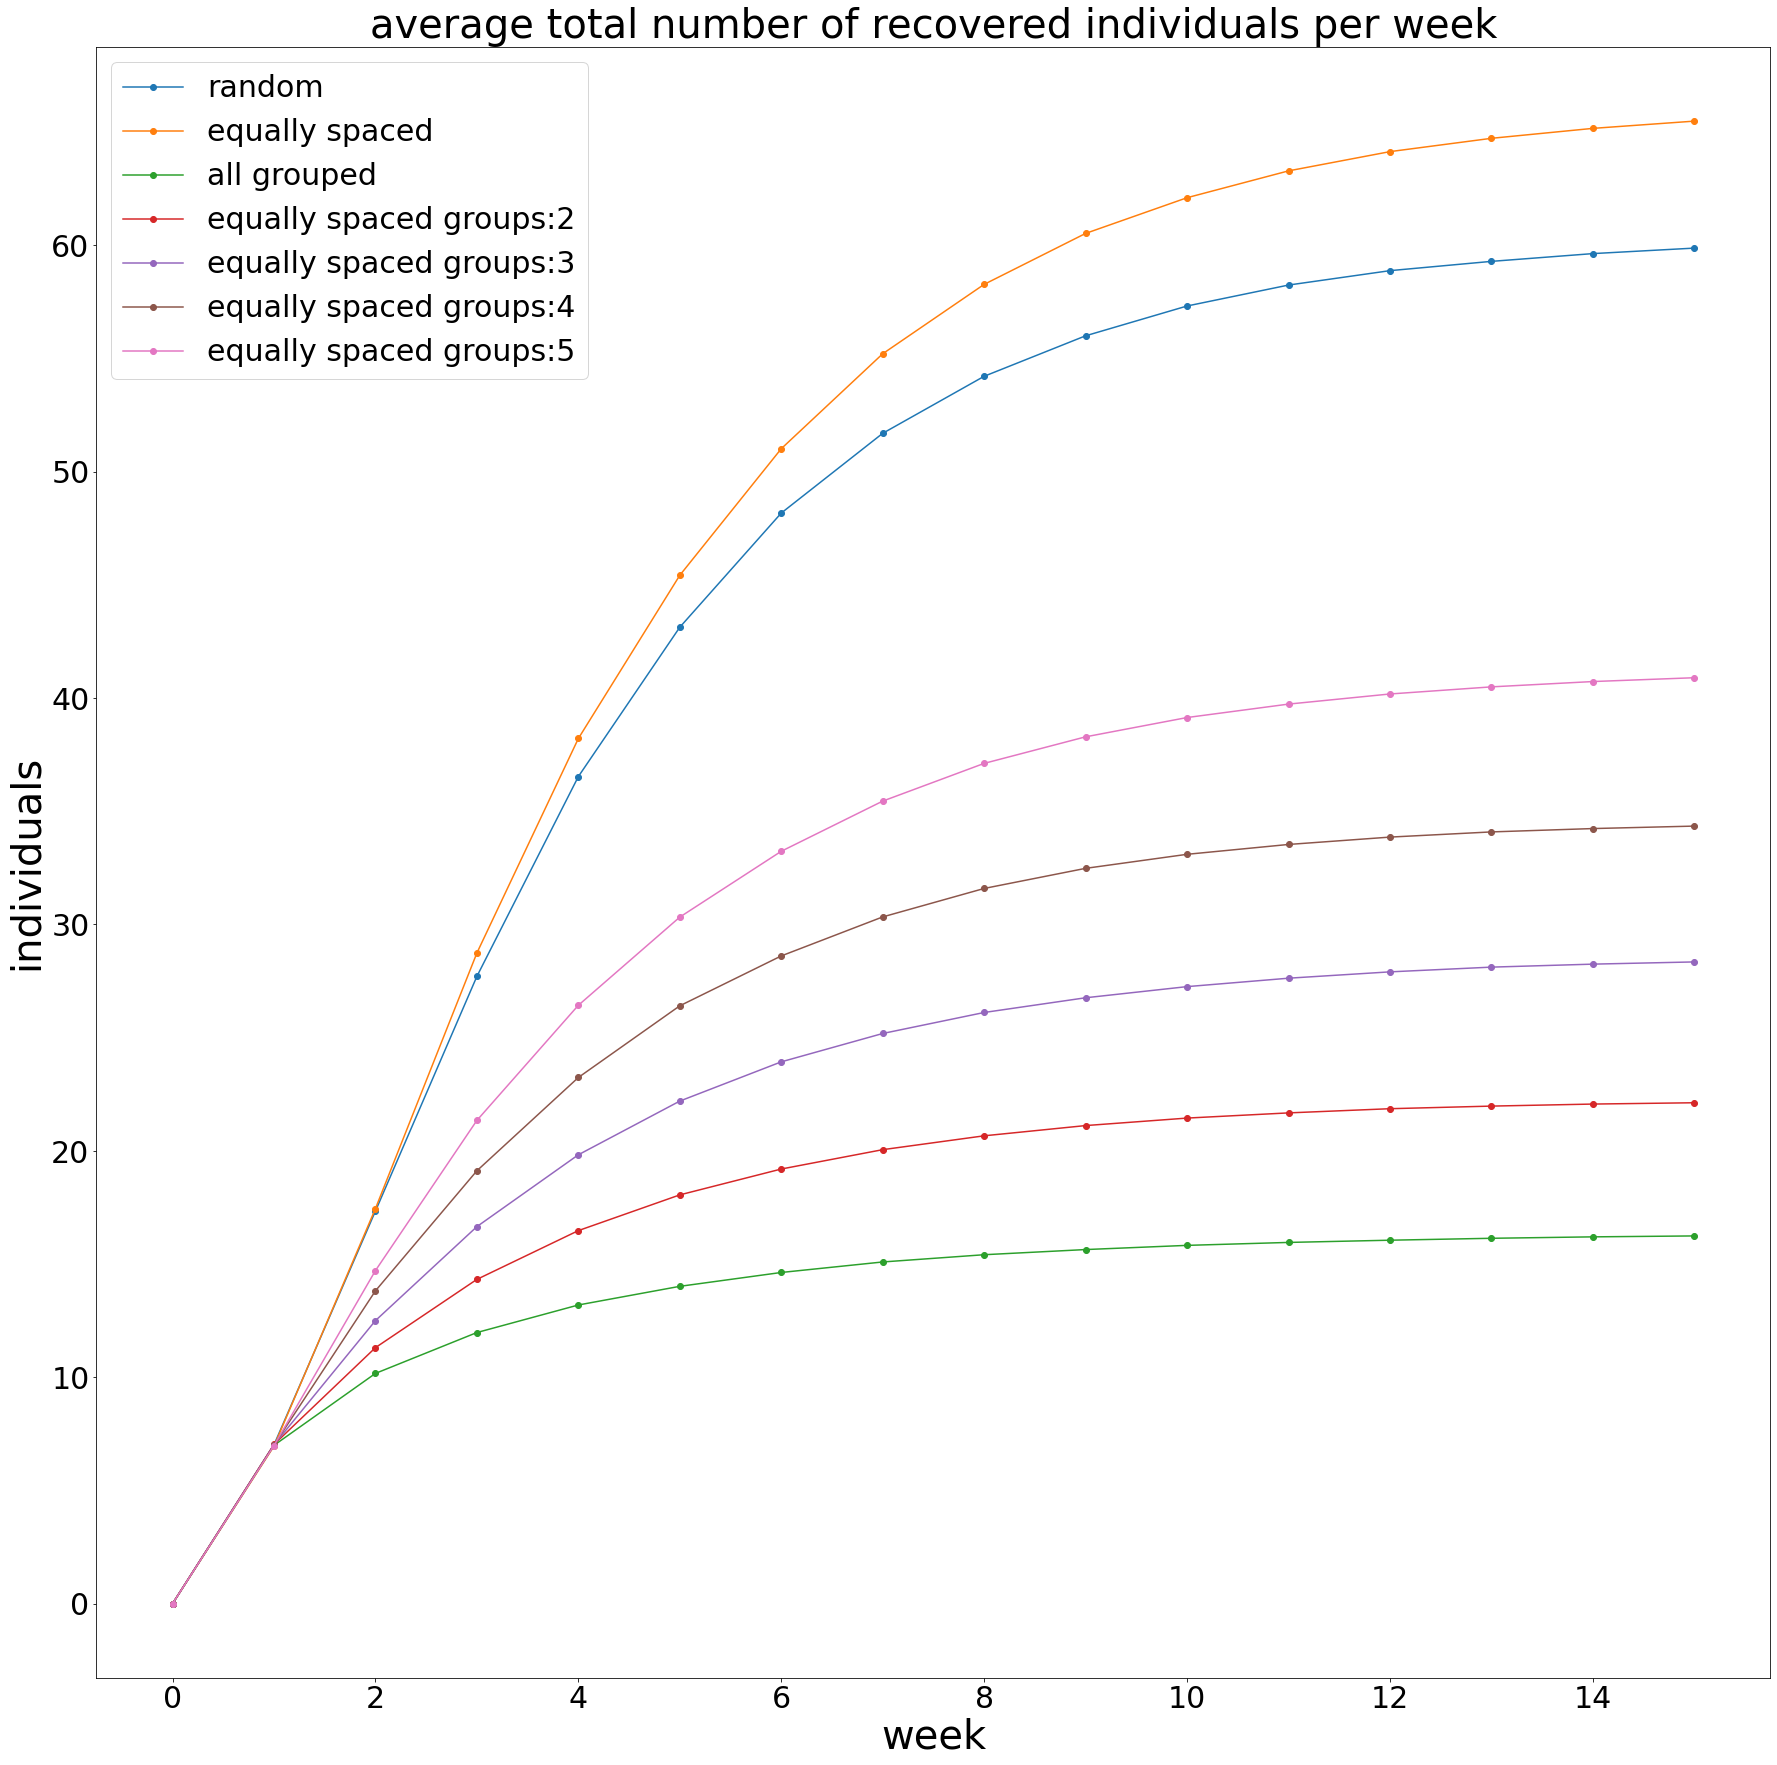

In [13]:
# Simulations with different initial configurations

init_conf = ['random','equally spaced','all grouped']
for n in range(2,6):
    init_conf.append('equally spaced groups:' + str(n))
avg_newly_infected = np.zeros((len(init_conf),weeks))
avg_stats = np.zeros((len(init_conf),len(A),weeks+1))
for c, initial_configuration in enumerate(init_conf):
    n_simulations = 1000
    stats = np.zeros((len(A),n_simulations, weeks+1))
    cum_newly_infected = np.zeros((n_simulations, weeks))
    A_rev = dict((v,k) for k,v in A.items())
    for i in range(n_simulations):
        states = simulate(A, W, beta, ro, n_infected_initial, weeks, initial_configuration)
        newly_infected = np.array([np.sum(np.logical_and(states[i-1]==A['susceptible'], states[i]==A['infected'])) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
        n_susc_per_week = np.sum(states==A['susceptible'],axis=1)
        n_inf_per_week = np.sum(states==A['infected'],axis=1)
        n_rec_per_week = np.sum(states==A['recovered'],axis=1)
        cum_newly_infected[i] = newly_infected
        stats[0,i] = n_susc_per_week
        stats[1,i] = n_inf_per_week
        stats[2,i] = n_rec_per_week

    avg_newly_infected[c] = np.mean(cum_newly_infected,axis=0)
    avg_stats[c] = np.mean(stats,axis=1)


fig = plt.figure(figsize=(30, 30))
for c, initial_configuration in enumerate(init_conf):
    plt.plot(np.arange(1,weeks+1), avg_newly_infected[c], '-o', label = initial_configuration)

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


for state in range(len(A)):
    fig = plt.figure(figsize=(30, 30))
    for c, initial_configuration in enumerate(init_conf):
        plt.plot(np.arange(weeks+1), avg_stats[c,state], '-o', label = initial_configuration)

    plt.title('average total number of ' + list(A.keys())[state] + ' individuals per week', fontsize = 40)
    plt.xlabel('week', fontsize = 40)
    plt.ylabel('individuals', fontsize = 40)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(fontsize = 30)
    fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
    img_counter += 1

In [14]:
for c, initial_configuration in enumerate(init_conf):
    print('Average number of newly infected individuals per week - initial configuration:', initial_configuration)
    print(avg_newly_infected[c])
print("\n")
for state in range(len(A)):
    for c, initial_configuration in enumerate(init_conf):
        print('Average total number of ' + list(A.keys())[state] + ' individuals per week - initial configuration:', initial_configuration)
        print(avg_stats[c,state])
    print()

Average number of newly infected individuals per week - initial configuration: random
[11.753 10.473  8.008  5.796  4.189  2.96   2.073  1.544  1.079  0.735
  0.53   0.351  0.274  0.204  0.139]
Average number of newly infected individuals per week - initial configuration: equally spaced
[12.011 11.401  8.821  6.402  4.804  3.538  2.594  1.918  1.326  0.951
  0.724  0.488  0.365  0.286  0.202]
Average number of newly infected individuals per week - initial configuration: all grouped
[1.587 1.181 0.945 0.664 0.531 0.375 0.272 0.196 0.156 0.111 0.081 0.068
 0.059 0.036 0.019]
Average number of newly infected individuals per week - initial configuration: equally spaced groups:2
[3.256 2.331 1.809 1.335 0.984 0.686 0.539 0.387 0.27  0.195 0.137 0.108
 0.063 0.044 0.036]
Average number of newly infected individuals per week - initial configuration: equally spaced groups:3
[4.899 3.547 2.758 1.993 1.474 1.07  0.786 0.548 0.407 0.315 0.233 0.168
 0.11  0.081 0.067]
Average number of newly infe

## Random graph according to the preferential attachment model

In [15]:
n_nodes = 500
k = 6

In [87]:
# Generates and returns a random graph of n nodes with average degree k>0 by using preferential attachment.
# if 'demo' is True, print the graph at timestep t.

def generate_gpa(n, k, demo=True):

    c = k/2

    t = 1
    G_1 = nx.complete_graph(k+1)

    if demo:
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        plt.figure(figsize=(20, 20))
        plt.title("G_" + str(t), fontsize=60)
        pos = nx.circular_layout(G_1)
        nx.draw(G_1, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)

    t_final = n-k
    up = False
    G = G_1
    for t in range(2, t_final+1):
        deg_id = np.array([n for n,d in list(G.degree())])
        deg_val = np.array([d for n,d in list(G.degree())])
        norm_deg_val = deg_val/np.sum(deg_val)

        if up:
            c_round = math.ceil(c)
            up = False
        else:
            c_round = math.floor(c)
            up = True

        neighbors = np.random.choice(deg_id, p=norm_deg_val, size=c_round, replace=False) # replace=False guarantees no neighbor is chosen twice
        G.add_node(k+t-1)
        for neigh in neighbors:
            G.add_edge(k+t-1,neigh) 

        if demo:
            if t<=20:
                plt.figure(figsize=(20,20))
                plt.title("G_" + str(t), fontsize=60)
                pos = nx.circular_layout(G)
                nx.draw(G, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)
                
    return G

In [17]:
G = generate_gpa(n_nodes, k, demo=False)

In [ ]:
plt.figure(figsize=(20, 20))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)

In [18]:
avg_degree = np.mean(np.array([d for n,d in G.degree]))
print("Average degree:", avg_degree)

Average degree: 6.0


### Epidemic simulation

In [3]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))
    
def is_infected(n):
    return n%3==1

def recover(n):
    return n+1

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2


In [20]:
# Number of agents
n_agents = len(G)
ro = 0.7
beta = 0.3
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

In [21]:
n_infected_initial = 10
weeks = 15

In [22]:
# run 1 simulation and plot state values at each time unit.
states = simulate(A, W, beta, ro, n_infected_initial, weeks)
A_rev = dict((v,k) for k,v in A.items())
for t in range(0,weeks+1):
    x = states[t]
    print("Time unit " + str(t))
    print("state:")
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(0, len(G)), columns=['state'])) 
    n_susc = np.sum(x==A['susceptible'])
    n_inf = np.sum(x==A['infected'])
    n_rec = np.sum(x==A['recovered'])
    print("Susceptible agents =", n_susc)
    print("Infected agents =", n_inf)
    print("Recovered agents =", n_rec)
    print()

Time unit 0
state:


state
0    susceptible
1    susceptible
2    susceptible
3    susceptible
4    susceptible
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 490
Infected agents = 10
Recovered agents = 0

Time unit 1
state:


state
0    susceptible
1    susceptible
2    susceptible
3    susceptible
4       infected
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 473
Infected agents = 20
Recovered agents = 7

Time unit 2
state:


state
0       infected
1       infected
2       infected
3    susceptible
4       infected
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 424
Infected agents = 56
Recovered agents = 20

Time unit 3
state:


state
0      recovered
1      recovered
2      recovered
3       infected
4      recovered
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 321
Infected agents = 116
Recovered agents = 63

Time unit 4
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 214
Infected agents = 144
Recovered agents = 142

Time unit 5
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495     infected
496  susceptible
497  susceptible
498     infected
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 150
Infected agents = 98
Recovered agents = 252

Time unit 6
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497  susceptible
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 124
Infected agents = 52
Recovered agents = 324

Time unit 7
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497  susceptible
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 116
Infected agents = 27
Recovered agents = 357

Time unit 8
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497     infected
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 107
Infected agents = 16
Recovered agents = 377

Time unit 9
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 103
Infected agents = 9
Recovered agents = 388

Time unit 10
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 103
Infected agents = 3
Recovered agents = 394

Time unit 11
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 102
Infected agents = 3
Recovered agents = 395

Time unit 12
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 100
Infected agents = 4
Recovered agents = 396

Time unit 13
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 100
Infected agents = 3
Recovered agents = 397

Time unit 14
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 100
Infected agents = 1
Recovered agents = 399

Time unit 15
state:


state
0      recovered
1      recovered
2      recovered
3      recovered
4      recovered
..           ...
495    recovered
496  susceptible
497    recovered
498    recovered
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 100
Infected agents = 1
Recovered agents = 399



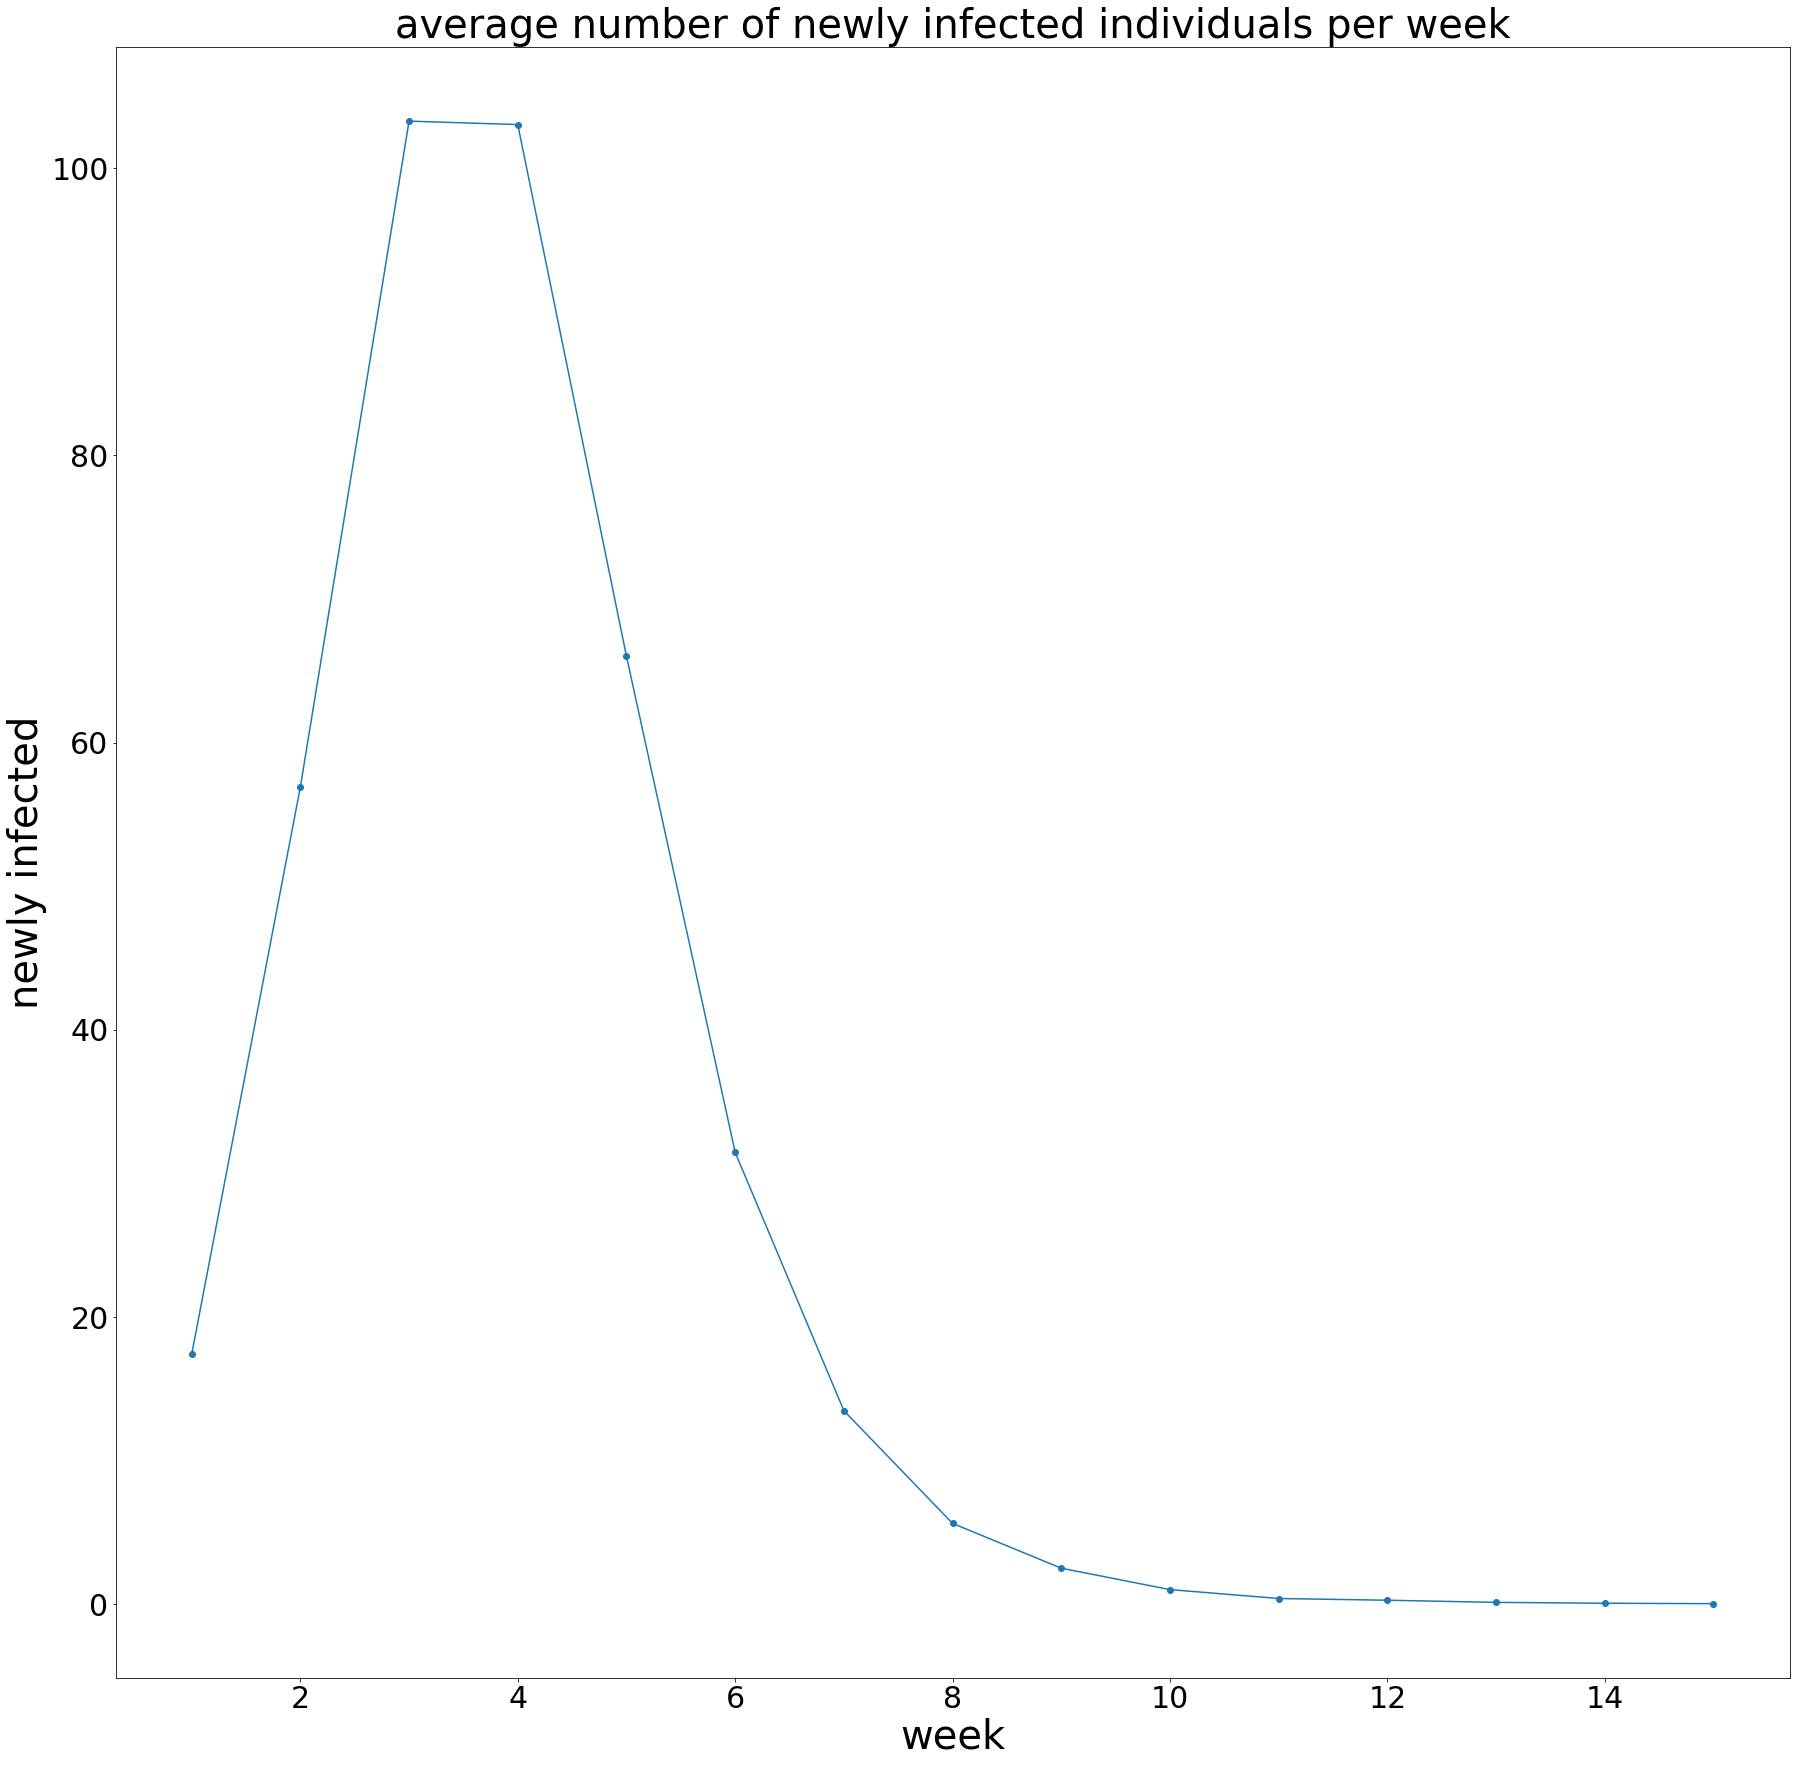

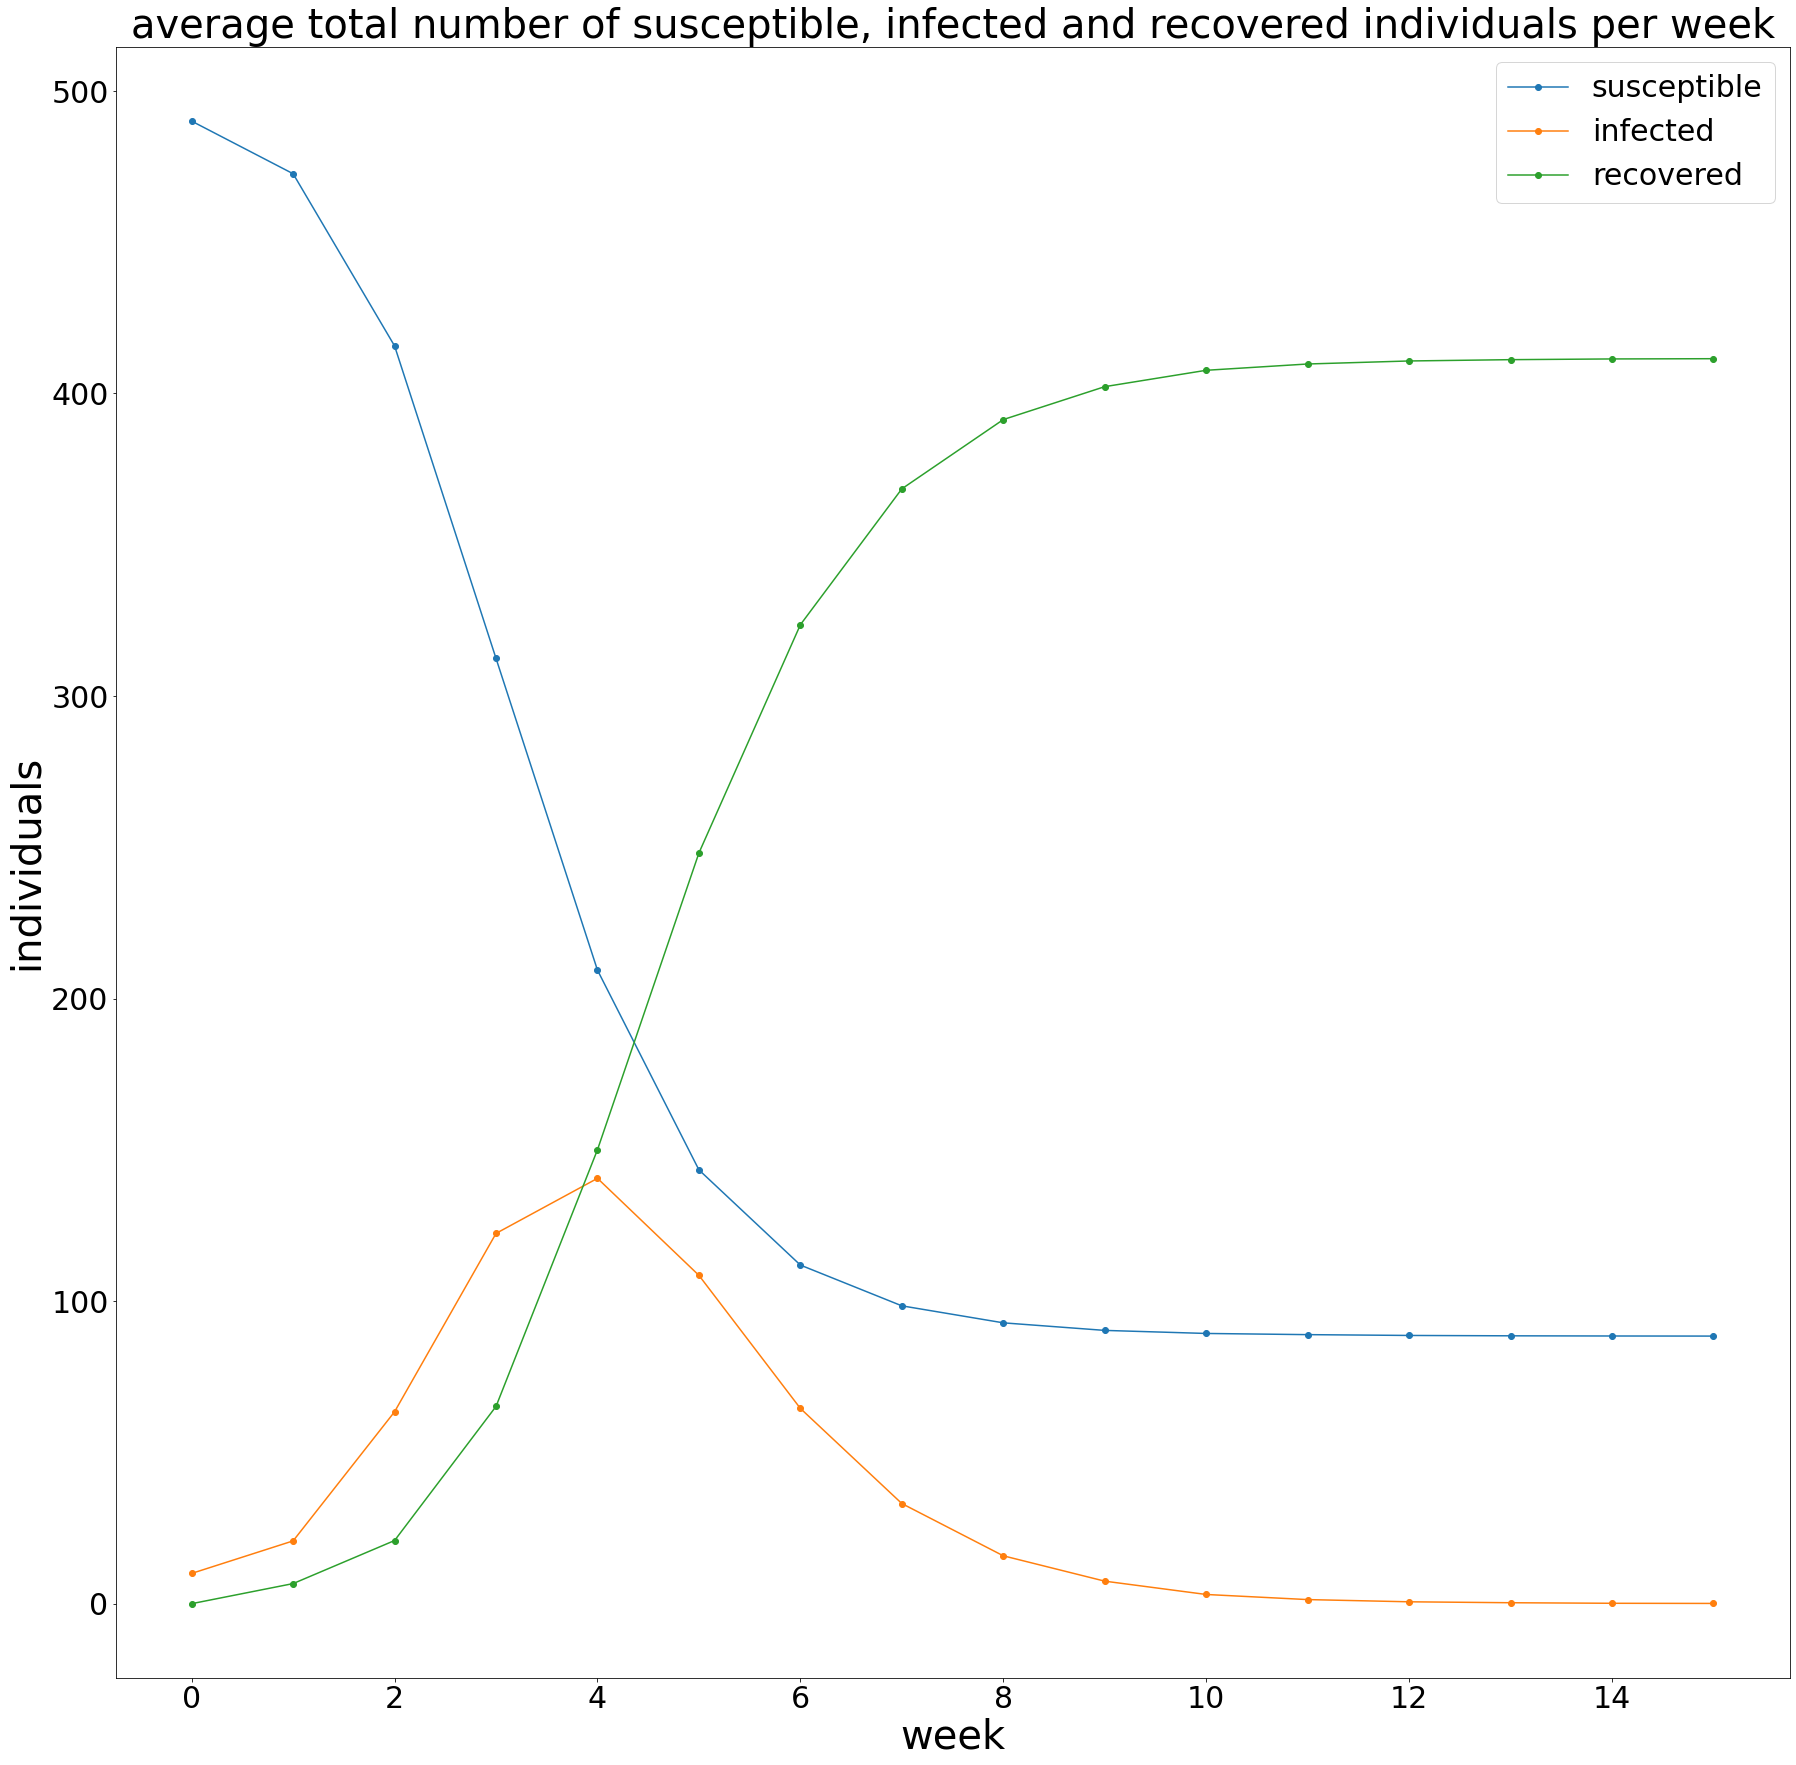

In [24]:
n_simulations = 100
stats = np.zeros((len(A), n_simulations, weeks+1))
cum_newly_infected = np.zeros((n_simulations, weeks))
A_rev = dict((v,k) for k,v in A.items())
for i in range(n_simulations):
    states = simulate(A, W, beta, ro, n_infected_initial, weeks)
    newly_infected = np.array([np.sum(np.logical_and(states[i-1]==A['susceptible'], states[i]==A['infected'])) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    n_susc_per_week = np.sum(states==A['susceptible'],axis=1)
    n_inf_per_week = np.sum(states==A['infected'],axis=1)
    n_rec_per_week = np.sum(states==A['recovered'],axis=1)
    cum_newly_infected[i] = newly_infected
    stats[0,i] = n_susc_per_week
    stats[1,i] = n_inf_per_week
    stats[2,i] = n_rec_per_week
    
avg_newly_infected = np.mean(cum_newly_infected,axis=0)
avg_stats = np.mean(stats,axis=1)

fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_infected, '-o')

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


fig = plt.figure(figsize=(30, 30))
for state in range(len(A)):
    plt.plot(np.arange(weeks+1), avg_stats[state], '-o', label = A_rev[state])

plt.title('average total number of susceptible, infected and recovered individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('individuals', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1

In [ ]:
n_steps = weeks

# Plot the infection spread

pos = nx.circular_layout(G)
for t in range(0,n_steps):
    plt.figure(figsize=(20,20))
    x = states[t]
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(0, len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==0).T[0]).tolist(),
        node_color = 'r',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==1).T[0]).tolist(),
        node_color = 'b',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==2).T[0]).tolist(),
        node_color = 'g',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    plt.title('jump step = {0}'.format(t+1), fontsize=30)

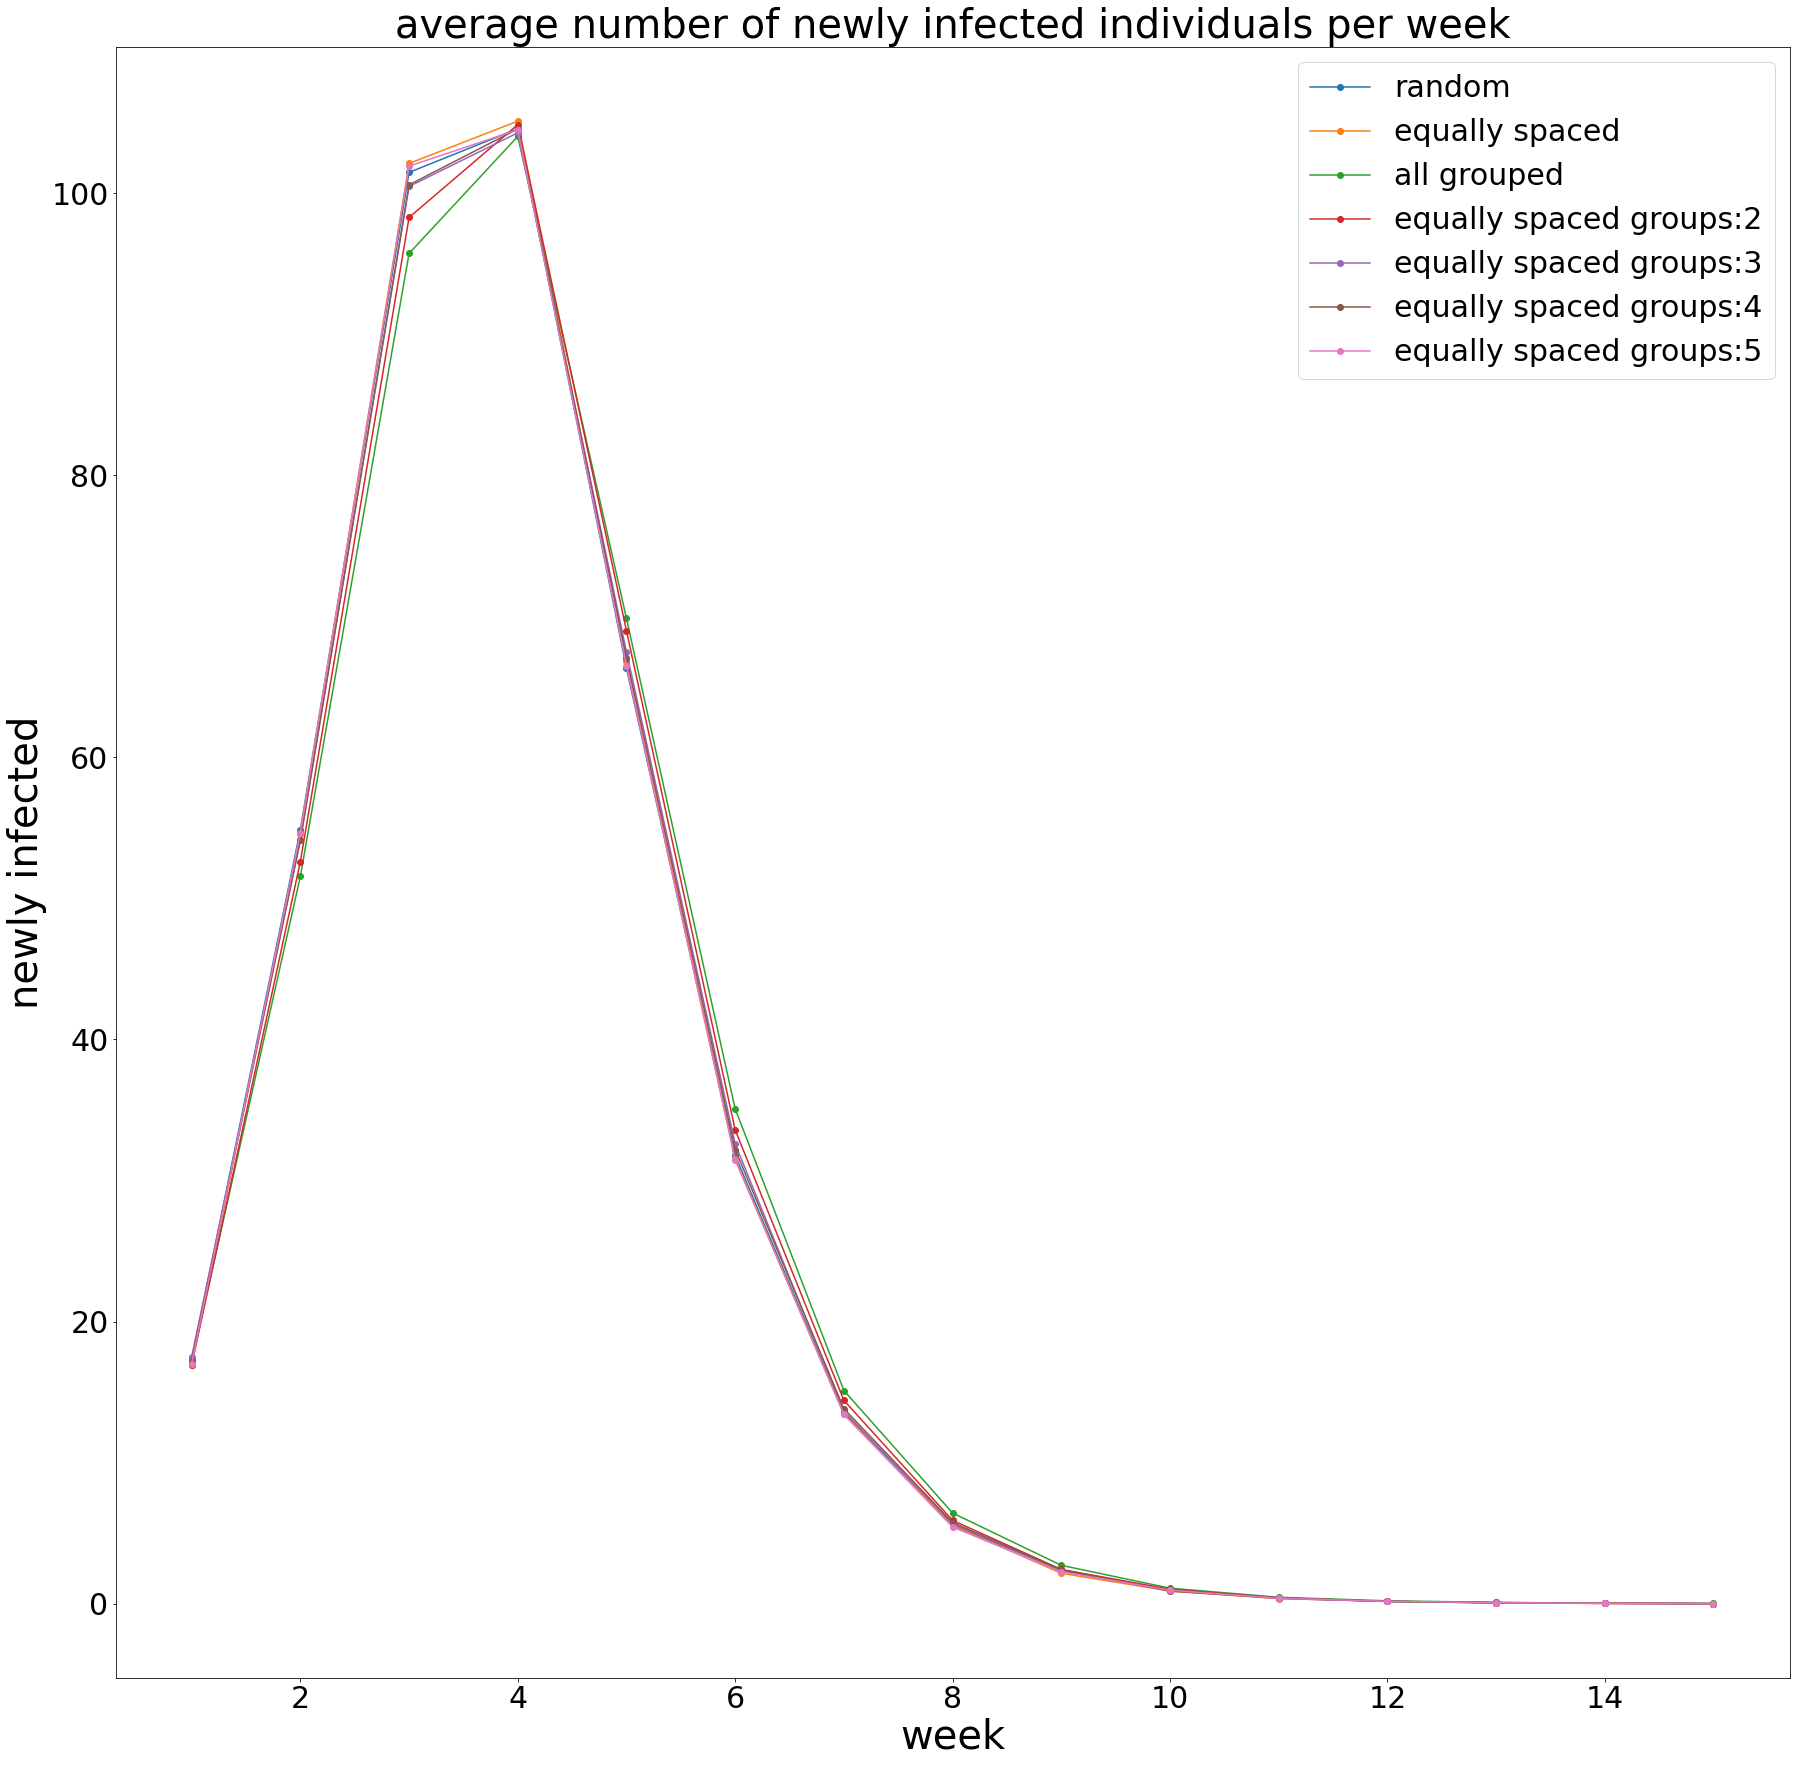

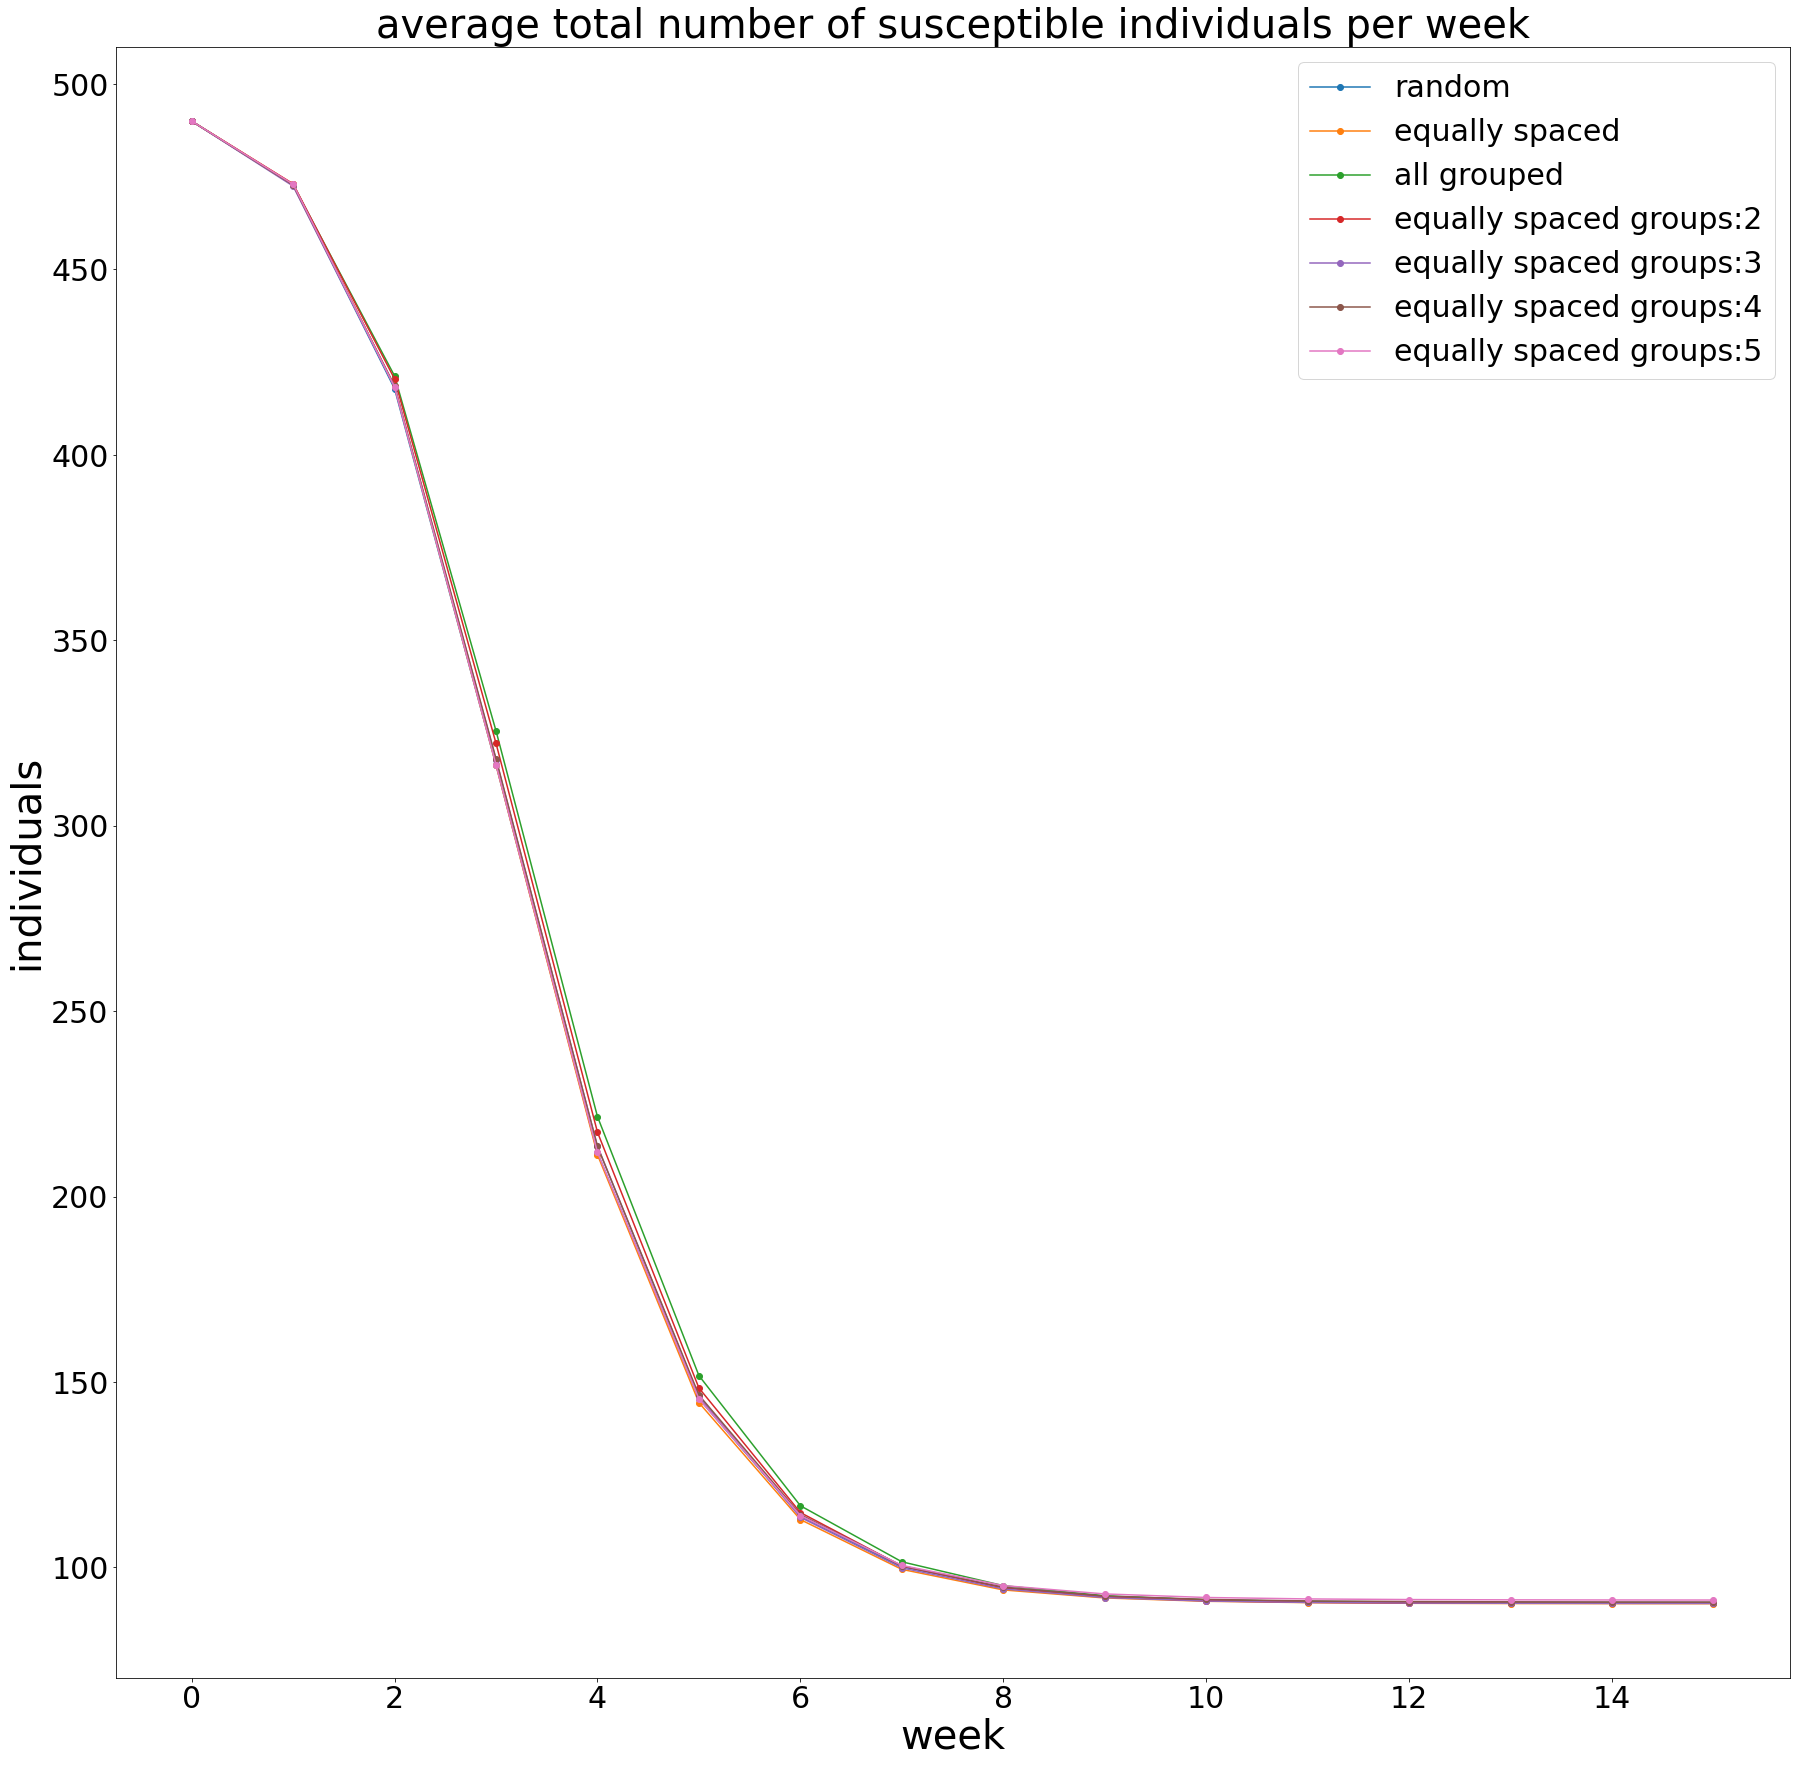

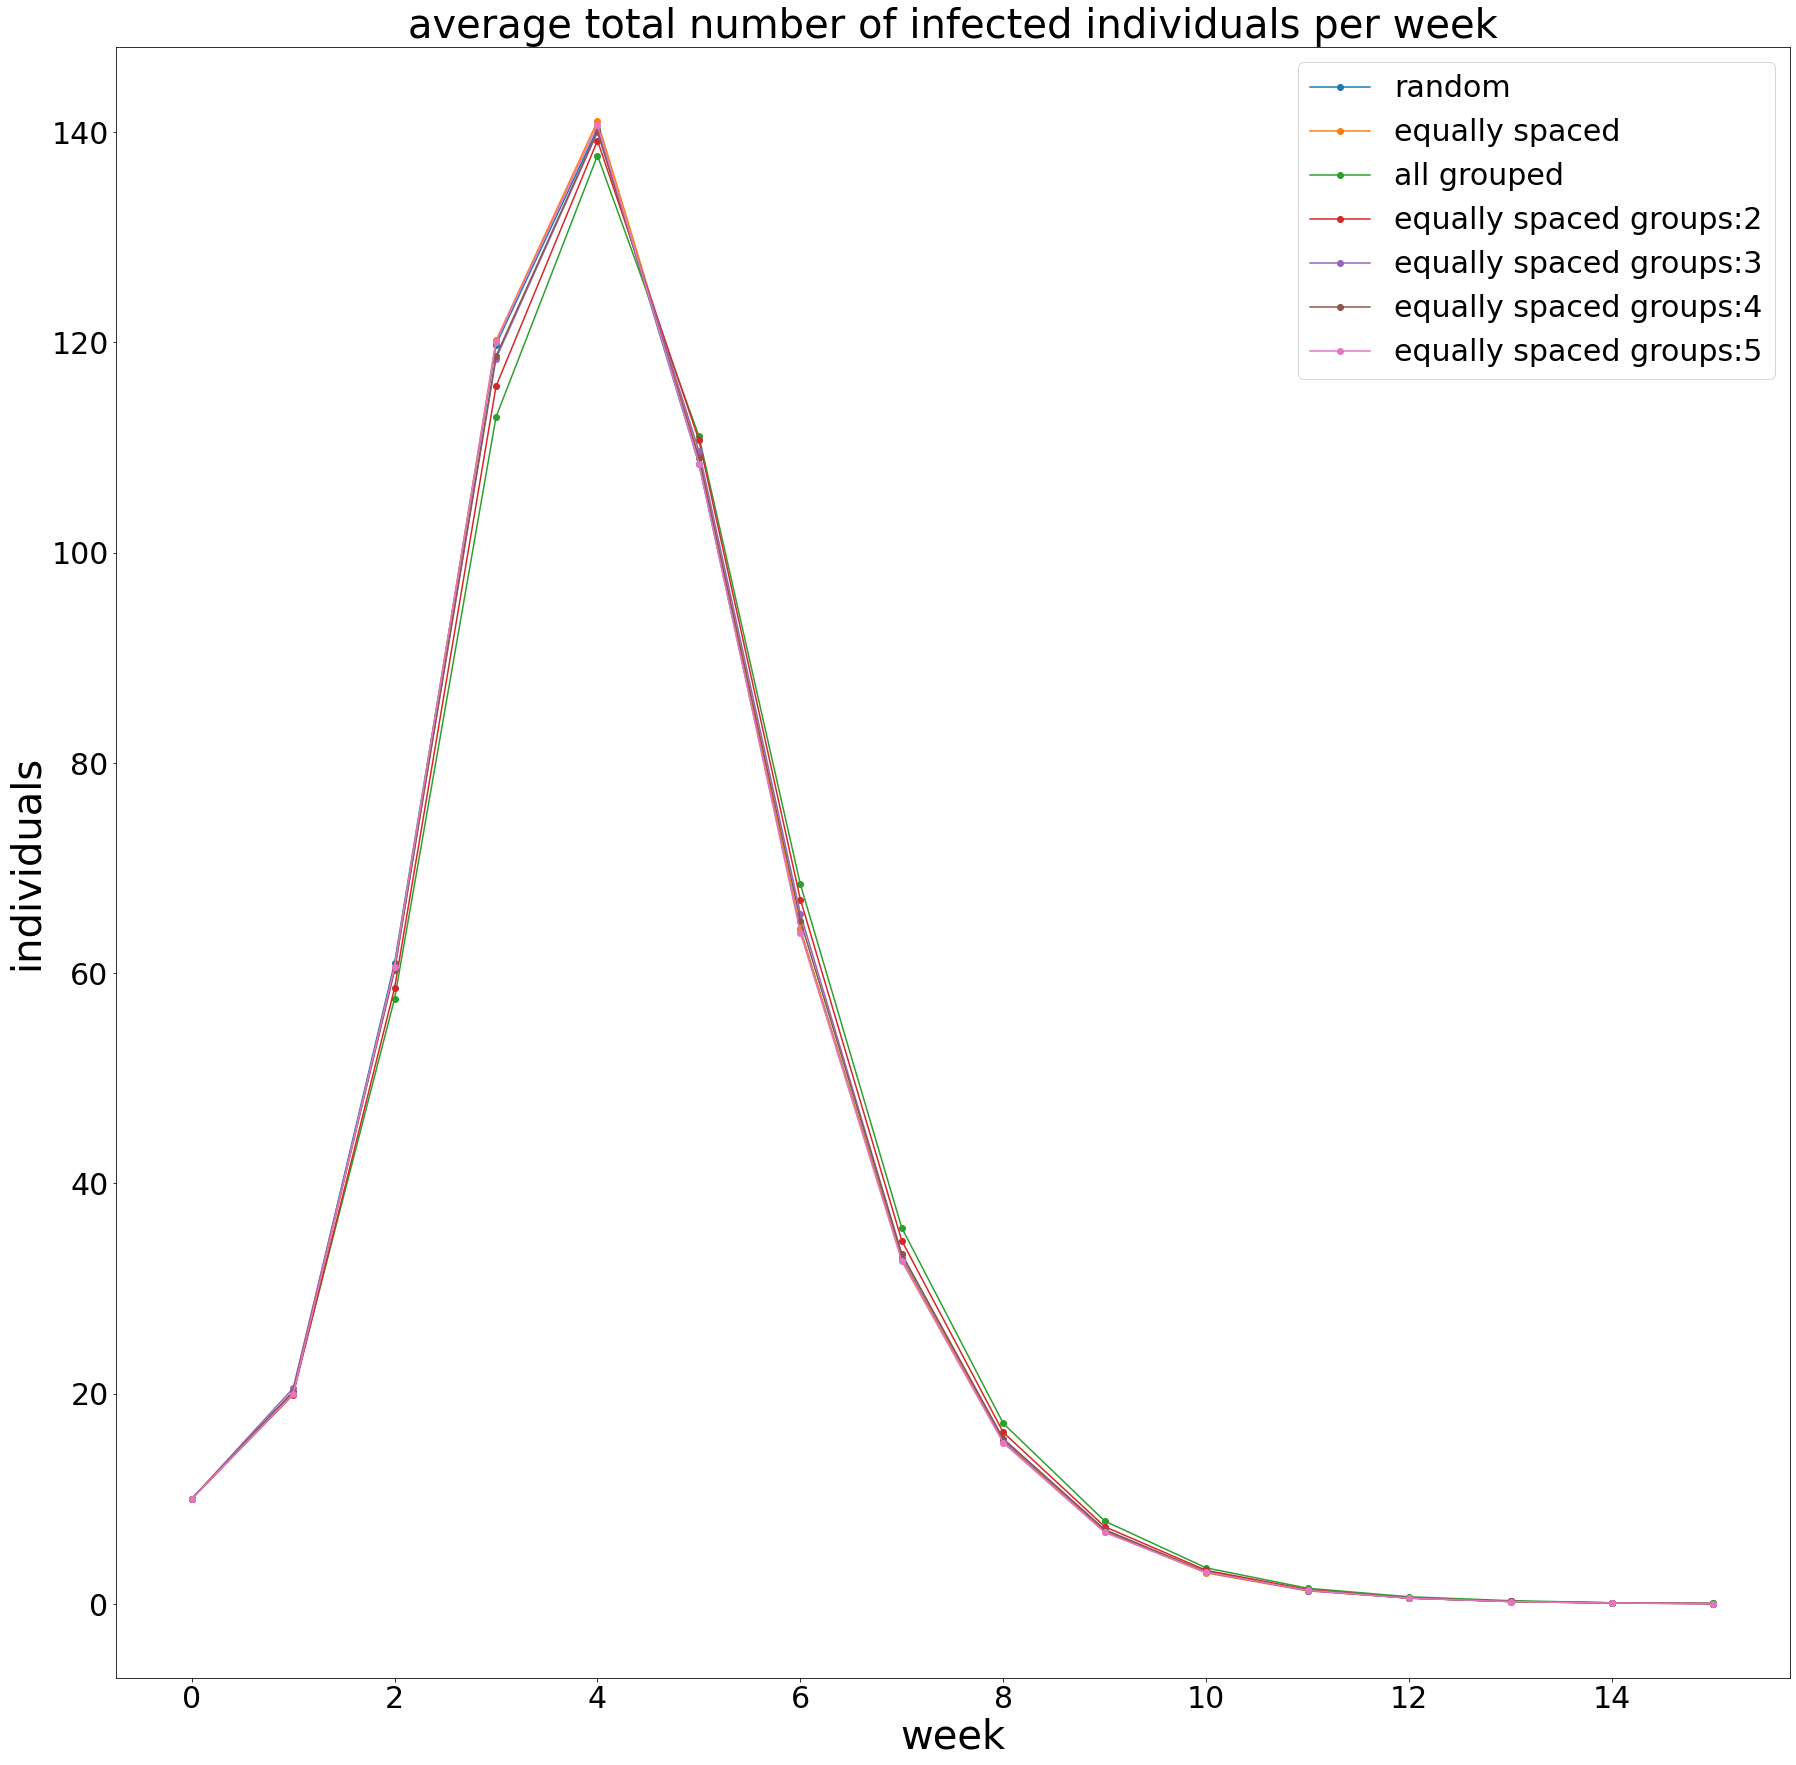

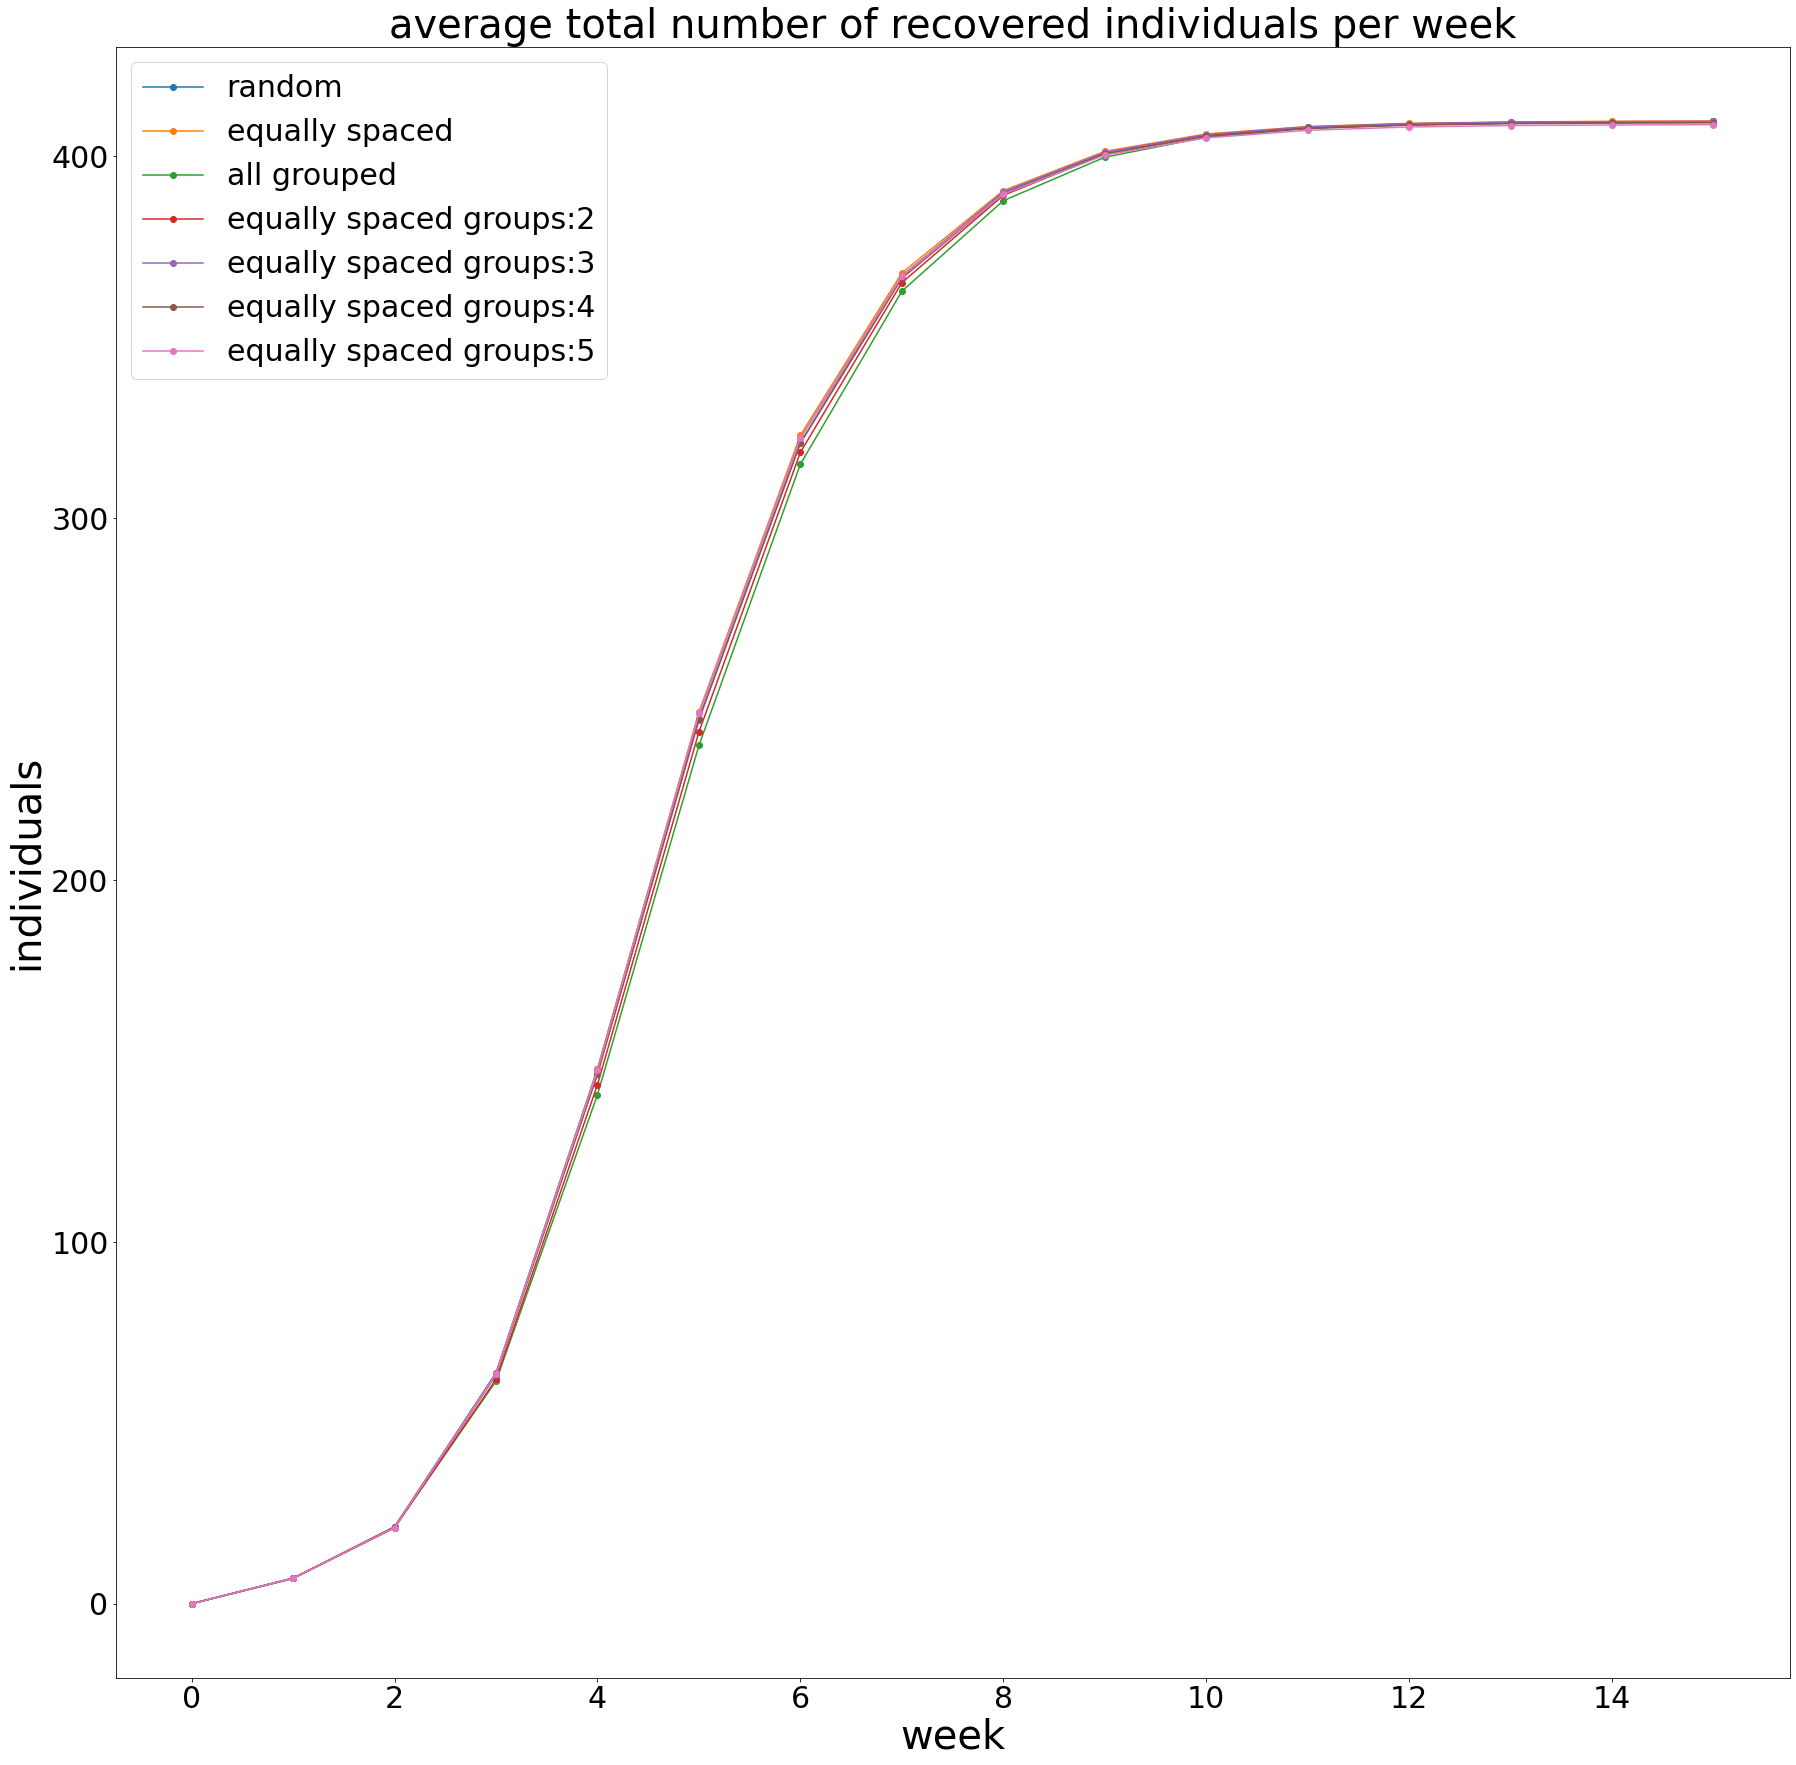

In [25]:
# Simulations with different initial configurations

init_conf = ['random','equally spaced','all grouped']
for n in range(2,6):
    init_conf.append('equally spaced groups:' + str(n))
avg_newly_infected = np.zeros((len(init_conf),weeks))
avg_stats = np.zeros((len(init_conf),len(A),weeks+1))
for c, initial_configuration in enumerate(init_conf):
    n_simulations = 1000
    stats = np.zeros((len(A),n_simulations, weeks+1))
    cum_newly_infected = np.zeros((n_simulations, weeks))
    A_rev = dict((v,k) for k,v in A.items())
    for i in range(n_simulations):
        states = simulate(A, W, beta, ro, n_infected_initial, weeks, initial_configuration)
        newly_infected = np.array([np.sum(np.logical_and(states[i-1]==A['susceptible'], states[i]==A['infected'])) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
        n_susc_per_week = np.sum(states==A['susceptible'],axis=1)
        n_inf_per_week = np.sum(states==A['infected'],axis=1)
        n_rec_per_week = np.sum(states==A['recovered'],axis=1)
        cum_newly_infected[i] = newly_infected
        stats[0,i] = n_susc_per_week
        stats[1,i] = n_inf_per_week
        stats[2,i] = n_rec_per_week

    avg_newly_infected[c] = np.mean(cum_newly_infected,axis=0)
    avg_stats[c] = np.mean(stats,axis=1)


fig = plt.figure(figsize=(30, 30))
for c, initial_configuration in enumerate(init_conf):
    plt.plot(np.arange(1,weeks+1), avg_newly_infected[c], '-o', label = initial_configuration)

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


for state in range(len(A)):
    fig = plt.figure(figsize=(30, 30))
    for c, initial_configuration in enumerate(init_conf):
        plt.plot(np.arange(weeks+1), avg_stats[c,state], '-o', label = initial_configuration)

    plt.title('average total number of ' + list(A.keys())[state] + ' individuals per week', fontsize = 40)
    plt.xlabel('week', fontsize = 40)
    plt.ylabel('individuals', fontsize = 40)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(fontsize = 30)
    fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
    img_counter += 1

In [26]:
for c, initial_configuration in enumerate(init_conf):
    print('Average number of newly infected individuals per week - initial configuration:', initial_configuration)
    print(avg_newly_infected[c])
print("\n")
for state in range(len(A)):
    for c, initial_configuration in enumerate(init_conf):
        print('Average total number of ' + list(A.keys())[state] + ' individuals per week - initial configuration:', initial_configuration)
        print(avg_stats[c,state])
    print()

Average number of newly infected individuals per week - initial configuration: random
[1.72840e+01 5.48780e+01 1.01468e+02 1.04561e+02 6.63190e+01 3.17810e+01
 1.35430e+01 5.56800e+00 2.39300e+00 9.61000e-01 4.05000e-01 1.66000e-01
 9.00000e-02 3.50000e-02 1.10000e-02]
Average number of newly infected individuals per week - initial configuration: equally spaced
[1.69560e+01 5.45860e+01 1.02103e+02 1.05102e+02 6.68450e+01 3.15190e+01
 1.34260e+01 5.54600e+00 2.15900e+00 9.03000e-01 3.60000e-01 1.81000e-01
 6.80000e-02 2.30000e-02 9.00000e-03]
Average number of newly infected individuals per week - initial configuration: all grouped
[1.71480e+01 5.15610e+01 9.57220e+01 1.04017e+02 6.98460e+01 3.50830e+01
 1.51150e+01 6.43500e+00 2.72400e+00 1.10400e+00 4.57000e-01 2.10000e-01
 9.70000e-02 3.30000e-02 2.30000e-02]
Average number of newly infected individuals per week - initial configuration: equally spaced groups:2
[1.69160e+01 5.26110e+01 9.82720e+01 1.04855e+02 6.89720e+01 3.35900e+01
 

# Pandemic simulation with vaccination

In [27]:
n_nodes = 500
k = 6

In [28]:
G = generate_gpa(n_nodes, k, demo=False)

In [ ]:
plt.figure(figsize=(20, 20))
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)

### Epidemic simulation

In [4]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
A['susceptible but vaccinated'] = 3
A['infected but vaccinated'] = 4
A['recovered but vaccinated'] = 5
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))
    
def is_vaccinated(n):
    return n>=3

def is_notVaccinated(n):
    return n<3

def administer_vaccinate(n):
    return n+3

def is_susceptible(n):
    return n%3==0

def is_infected(n):
    return n%3==1

def is_recovered(n):
    return n%3==2

def recover(n):
    return n+1

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2
susceptible but vaccinated: 3
infected but vaccinated: 4
recovered but vaccinated: 5


In [30]:
# Number of agents
n_agents = len(G)
ro = 0.7
beta = 0.3
# Adjacency matrix
W = nx.convert_matrix.to_numpy_matrix(G)

In [31]:
n_infected_initial = 10
weeks = 15
vacc = np.array([0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60])
vacc = np.insert(vacc,0,0) # by week i=0 0% of individuals is vaccinated
vacc = np.insert(vacc,0,0) # by week i<0 0% of individuals is vaccinated

In [32]:
# run 1 simulation and plot state values at each time unit.
states = simulate(A, W, beta, ro, 10, 15, vacc_percentage=vacc, vaccination=True)
A_rev = dict((v,k) for k,v in A.items())
for t in range(0,weeks+1):
    x = states[t]
    print("Time unit " + str(t))
    print("state:")
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(0, len(G)), columns=['state'])) 
    n_susc = np.sum(x==A['susceptible'])
    n_inf = np.sum(x==A['infected'])
    n_rec = np.sum(x==A['recovered'])
    n_susc_vacc = np.sum(x==A['susceptible but vaccinated'])
    n_inf_vacc = np.sum(x==A['infected but vaccinated'])
    n_rec_vacc = np.sum(x==A['recovered but vaccinated'])
    print("Susceptible agents =", n_susc)
    print("Infected agents =", n_inf)
    print("Recovered agents =", n_rec)
    print("Susceptible but vaccinated agents =", n_susc_vacc)
    print("Infected but vaccinated agents =", n_inf_vacc)
    print("Recovered but vaccinated agents =", n_rec_vacc)
    print()

Time unit 0
state:


state
0    susceptible
1    susceptible
2    susceptible
3    susceptible
4    susceptible
..           ...
495  susceptible
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 490
Infected agents = 10
Recovered agents = 0
Susceptible but vaccinated agents = 0
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 0

Time unit 1
state:


state
0    susceptible
1       infected
2       infected
3       infected
4    susceptible
..           ...
495     infected
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 475
Infected agents = 17
Recovered agents = 8
Susceptible but vaccinated agents = 0
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 0

Time unit 2
state:


state
0       infected
1      recovered
2      recovered
3      recovered
4       infected
..           ...
495    recovered
496  susceptible
497  susceptible
498  susceptible
499  susceptible

[500 rows x 1 columns]

Susceptible agents = 387
Infected agents = 68
Recovered agents = 20
Susceptible but vaccinated agents = 22
Infected but vaccinated agents = 2
Recovered but vaccinated agents = 1

Time unit 3
state:


state
0    recovered but vaccinated
1                   recovered
2                   recovered
3                   recovered
4                    infected
..                        ...
495                 recovered
496                  infected
497                  infected
498               susceptible
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 260
Infected agents = 107
Recovered agents = 58
Susceptible but vaccinated agents = 49
Infected but vaccinated agents = 11
Recovered but vaccinated agents = 15

Time unit 4
state:


state
0    recovered but vaccinated
1                   recovered
2                   recovered
3    recovered but vaccinated
4                    infected
..                        ...
495                 recovered
496  recovered but vaccinated
497                 recovered
498                  infected
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 163
Infected agents = 96
Recovered agents = 116
Susceptible but vaccinated agents = 64
Infected but vaccinated agents = 22
Recovered but vaccinated agents = 39

Time unit 5
state:


state
0    recovered but vaccinated
1                   recovered
2                   recovered
3    recovered but vaccinated
4                   recovered
..                        ...
495                 recovered
496  recovered but vaccinated
497                 recovered
498                 recovered
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 107
Infected agents = 63
Recovered agents = 155
Susceptible but vaccinated agents = 84
Infected but vaccinated agents = 19
Recovered but vaccinated agents = 72

Time unit 6
state:


state
0    recovered but vaccinated
1                   recovered
2                   recovered
3    recovered but vaccinated
4                   recovered
..                        ...
495                 recovered
496  recovered but vaccinated
497                 recovered
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 82
Infected agents = 28
Recovered agents = 165
Susceptible but vaccinated agents = 97
Infected but vaccinated agents = 14
Recovered but vaccinated agents = 114

Time unit 7
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 66
Infected agents = 11
Recovered agents = 148
Susceptible but vaccinated agents = 111
Infected but vaccinated agents = 6
Recovered but vaccinated agents = 158

Time unit 8
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 3
Recovered agents = 140
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 3
Recovered but vaccinated agents = 178

Time unit 9
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 3
Recovered agents = 140
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 1
Recovered but vaccinated agents = 180

Time unit 10
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 1
Recovered agents = 142
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181

Time unit 11
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 1
Recovered agents = 142
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181

Time unit 12
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 0
Recovered agents = 143
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181

Time unit 13
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 0
Recovered agents = 143
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181

Time unit 14
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 0
Recovered agents = 143
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181

Time unit 15
state:


state
0    recovered but vaccinated
1    recovered but vaccinated
2                   recovered
3    recovered but vaccinated
4    recovered but vaccinated
..                        ...
495                 recovered
496  recovered but vaccinated
497  recovered but vaccinated
498  recovered but vaccinated
499               susceptible

[500 rows x 1 columns]

Susceptible agents = 57
Infected agents = 0
Recovered agents = 143
Susceptible but vaccinated agents = 119
Infected but vaccinated agents = 0
Recovered but vaccinated agents = 181



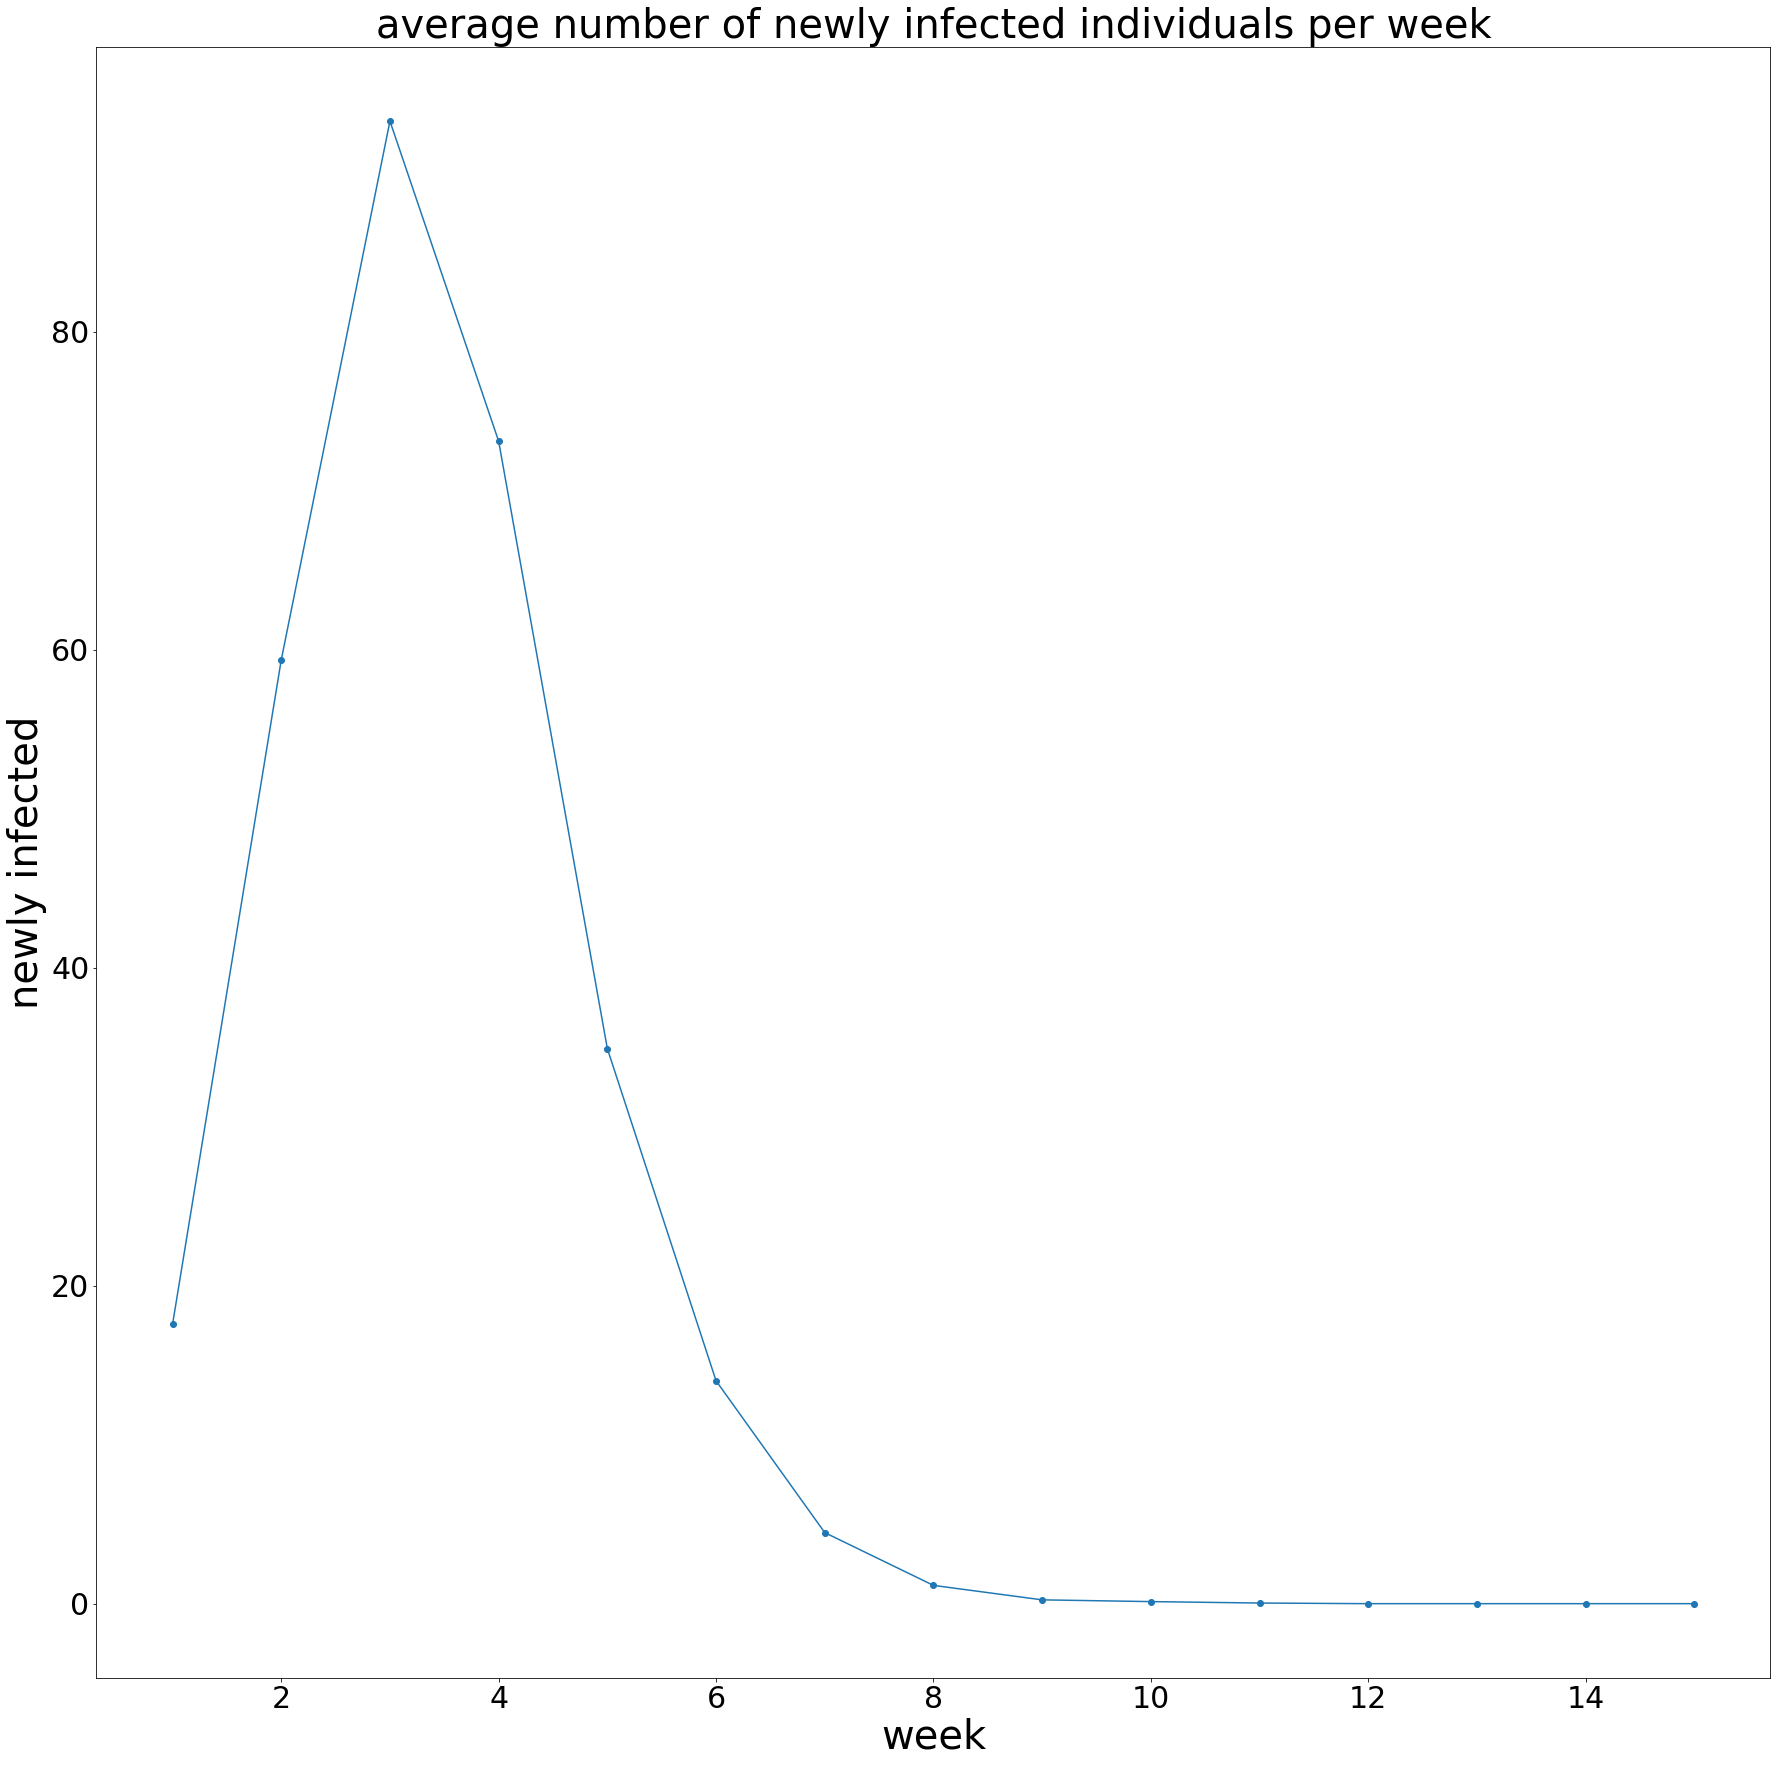

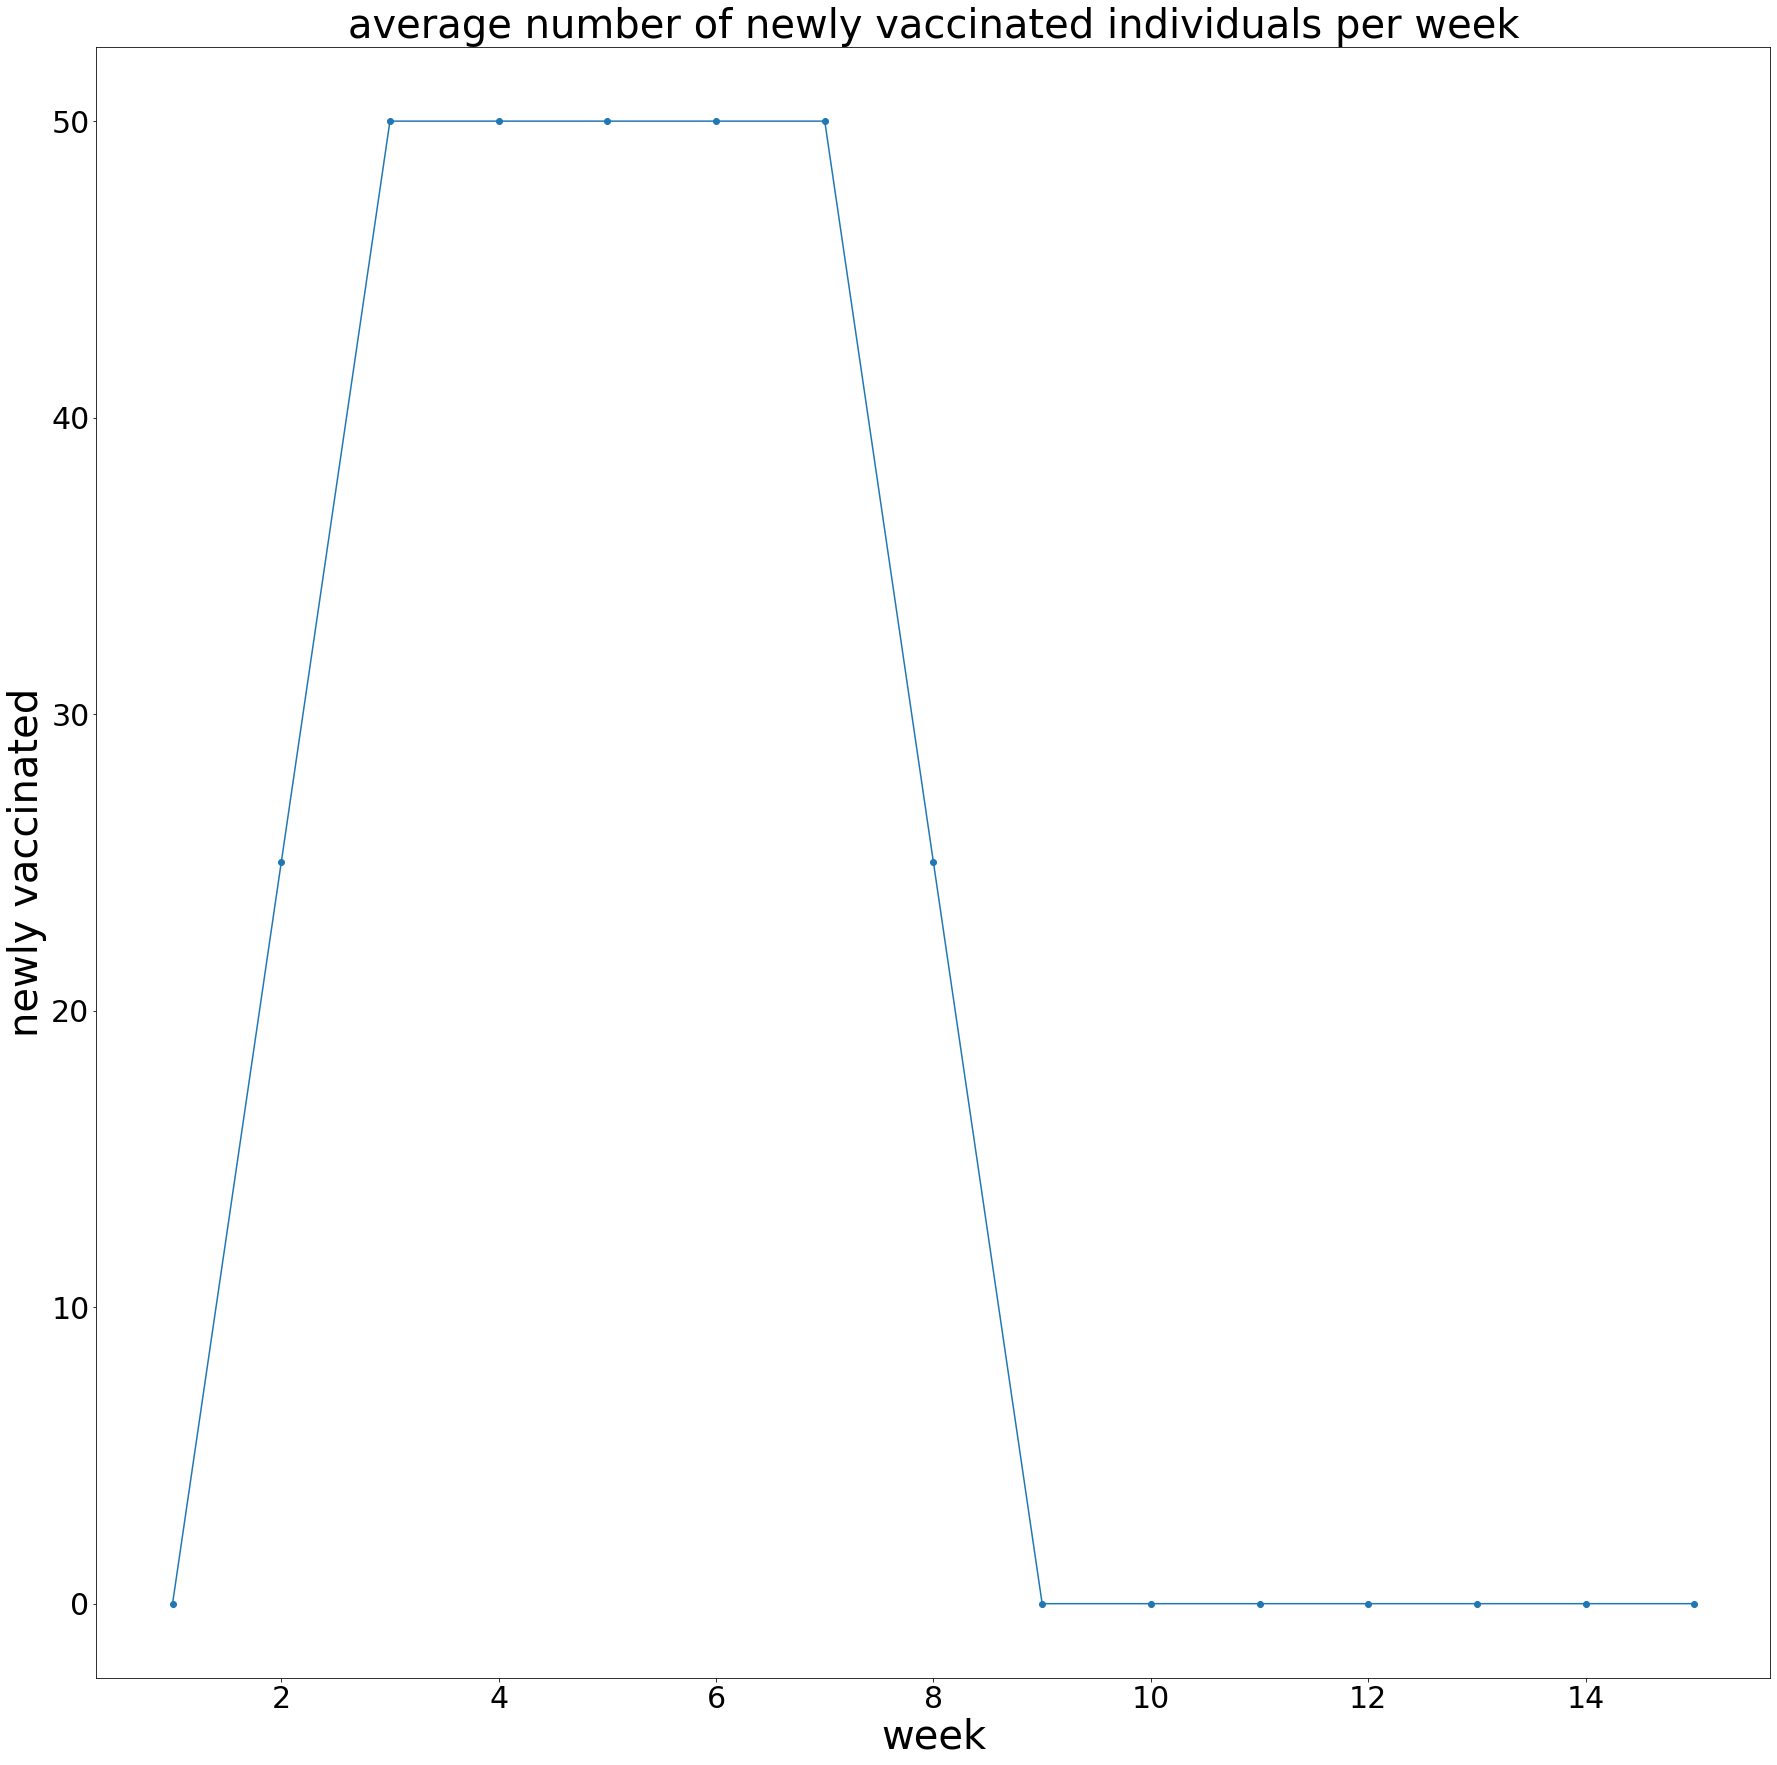

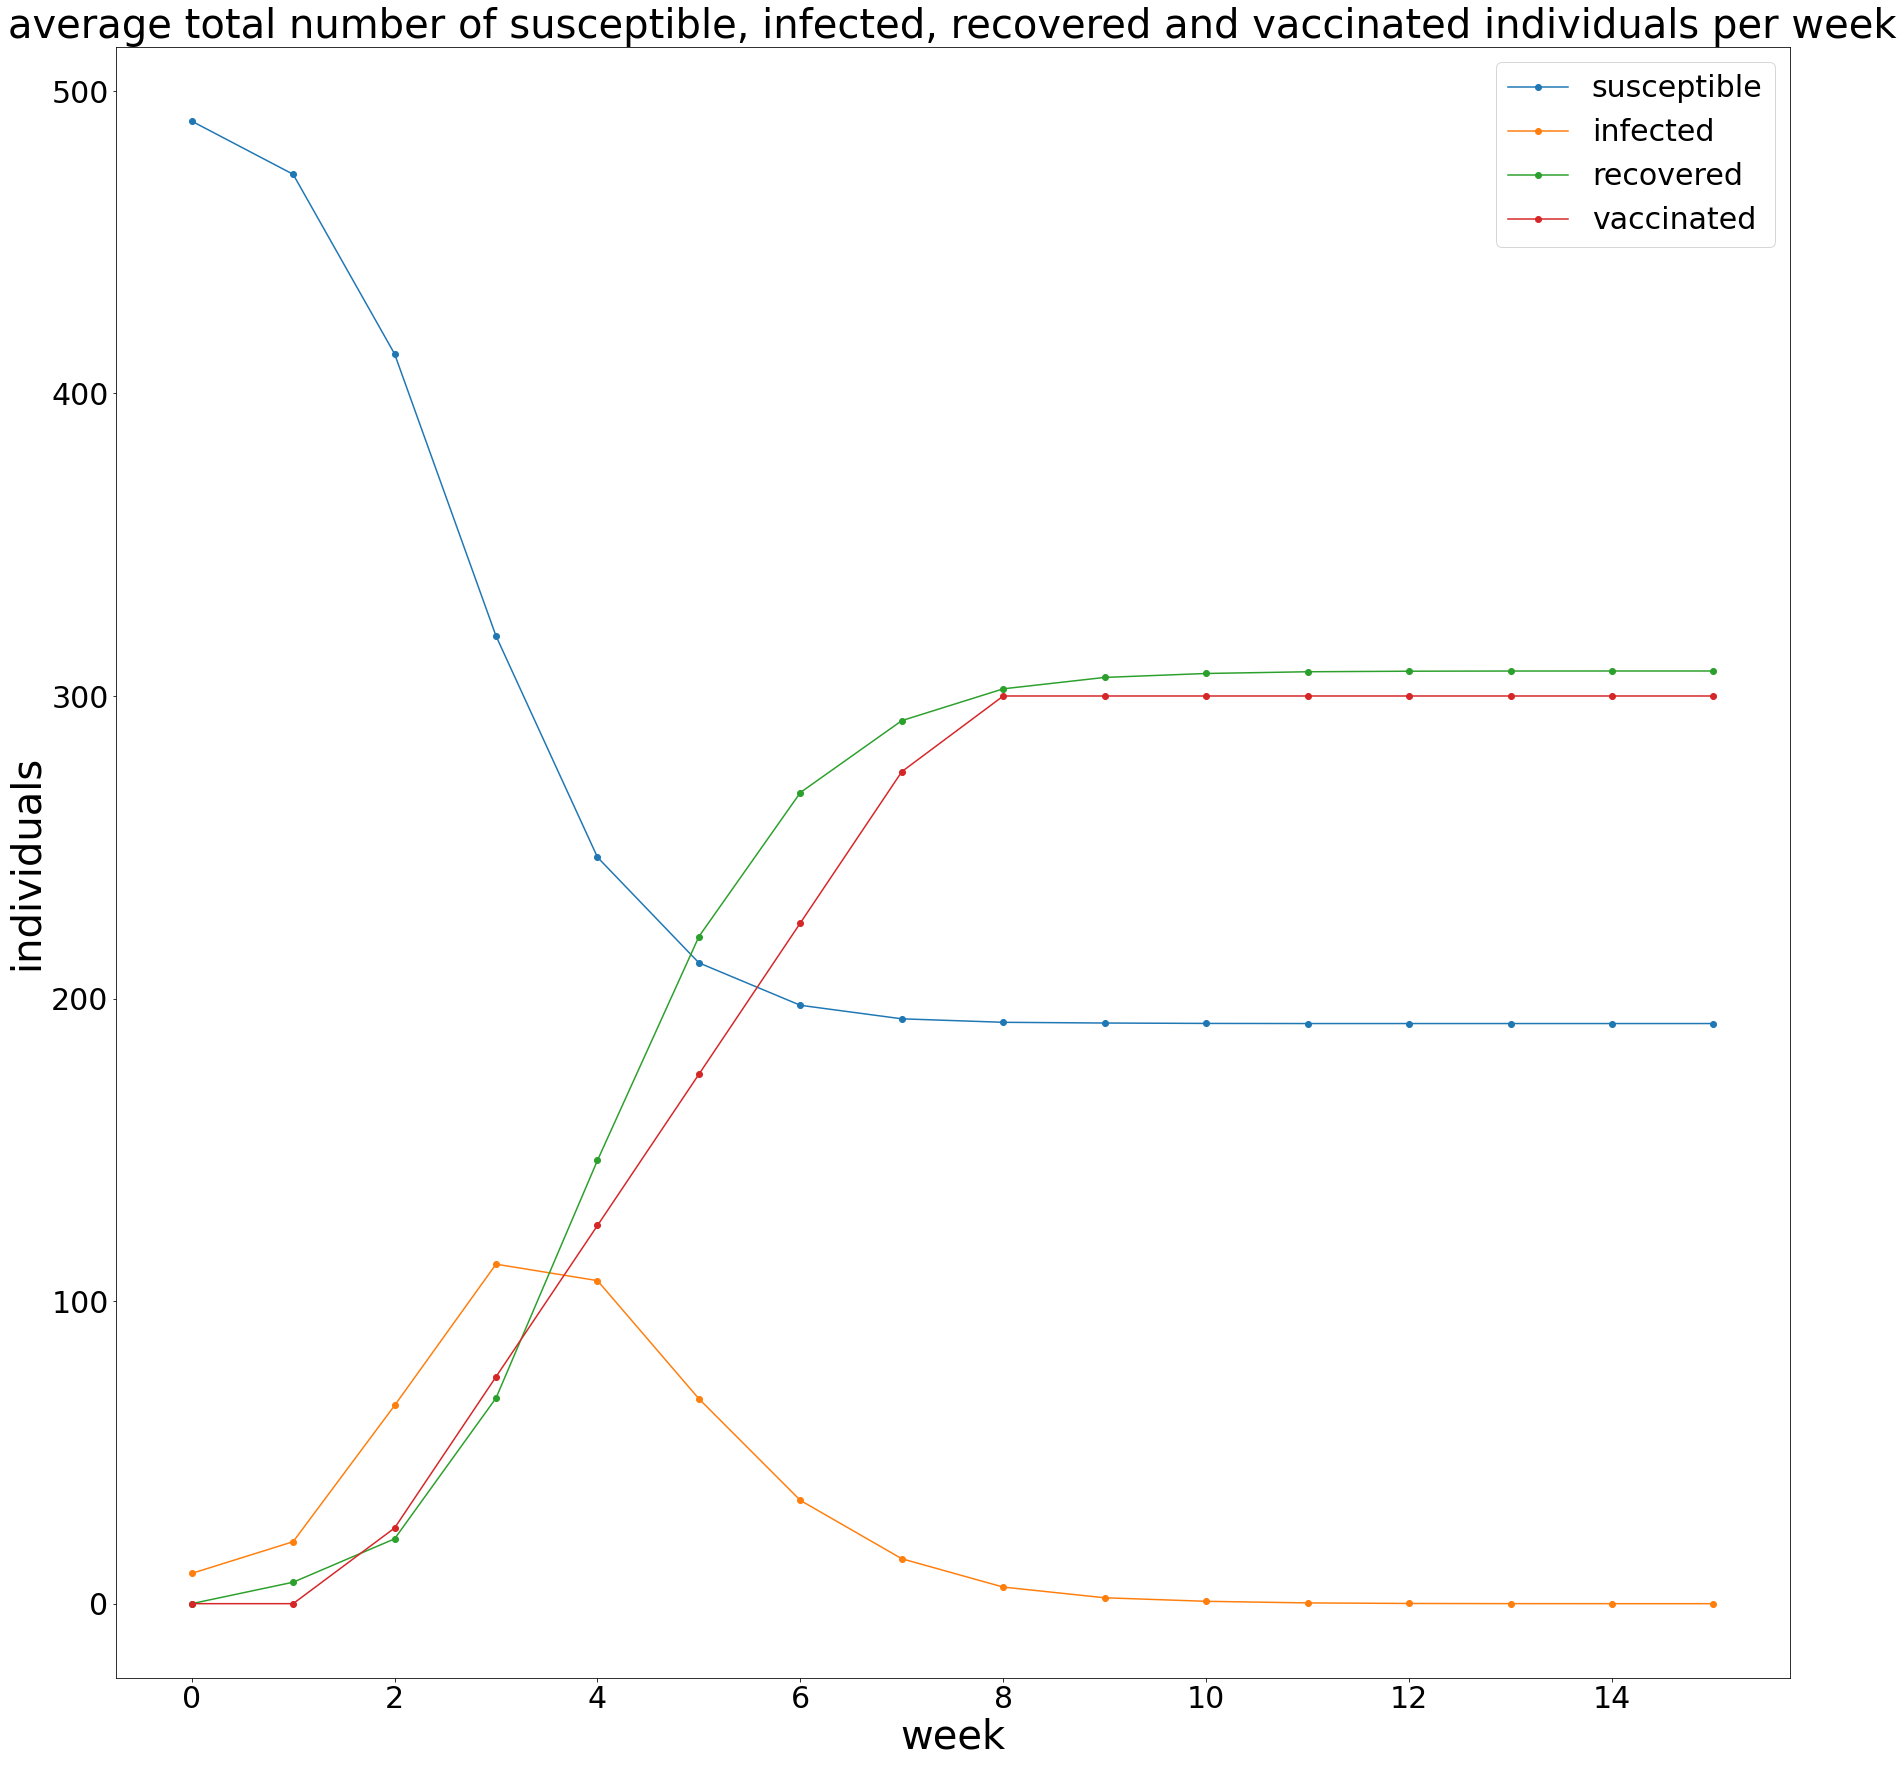

In [34]:
n_simulations = 100
stats = np.zeros((len(A)-2, n_simulations, weeks+1))
cum_newly_infected = np.zeros((n_simulations, weeks))
cum_newly_vaccinated = np.zeros((n_simulations, weeks))
A_rev = dict((v,k) for k,v in A.items())
for i in range(n_simulations):
    states = simulate(A, W, beta, ro, 10, 15, vacc_percentage=vacc, vaccination=True)
    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    newly_vaccinated = np.array([np.sum(np.logical_and(is_notVaccinated(states[i-1]), is_vaccinated(states[i]))) for i in range(1, weeks+1)]) # newly vaccinated agent are such that at time unit i-1 they were not vaccinated and at time unit i they are vaccinated
    n_susc_per_week = np.sum(is_susceptible(states),axis=1)
    n_inf_per_week = np.sum(is_infected(states),axis=1)
    n_rec_per_week = np.sum(is_recovered(states),axis=1)
    n_vac_per_week = np.sum(is_vaccinated(states),axis=1)
    cum_newly_infected[i] = newly_infected
    cum_newly_vaccinated[i] = newly_vaccinated
    stats[0,i] = n_susc_per_week
    stats[1,i] = n_inf_per_week
    stats[2,i] = n_rec_per_week
    stats[3,i] = n_vac_per_week
    
avg_newly_infected = np.mean(cum_newly_infected,axis=0)
avg_newly_vaccinated = np.mean(cum_newly_vaccinated,axis=0)
avg_stats = np.mean(stats,axis=1)

fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_infected, '-o')

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_vaccinated, '-o')

plt.title('average number of newly vaccinated individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly vaccinated', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1
    

fig = plt.figure(figsize=(30, 30))
for state in range(len(A)-2):
    lab = A_rev[state]
    if state==3:
        lab  ='vaccinated'
    plt.plot(np.arange(weeks+1), avg_stats[state], '-o', label = lab)

plt.title('average total number of susceptible, infected, recovered and vaccinated individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('individuals', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1

In [ ]:
n_steps = weeks

# Plot the infection spread

pos = nx.circular_layout(G)
for t in range(0,n_steps):
    plt.figure(figsize=(20,20))
    x = states[t]
    print("Jump step " + str(t))
    print("state:")
    A_rev = dict((v,k) for k,v in A.items())
    display(pd.DataFrame(data=[A_rev[z] for z in x], index=np.arange(0, len(G)), columns=['state']))
    print()
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==0).T[0]).tolist(),
        node_color = 'r',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==1).T[0]).tolist(),
        node_color = 'b',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    nx.draw(G,
        pos = pos,
        with_labels=True,
        nodelist=(np.argwhere(x==2).T[0]).tolist(),
        node_color = 'g',
        arrowsize=30, 
        node_size=3000,
        font_size=40, 
        font_color='white')
    plt.title('jump step = {0}'.format(t+1), fontsize=30)

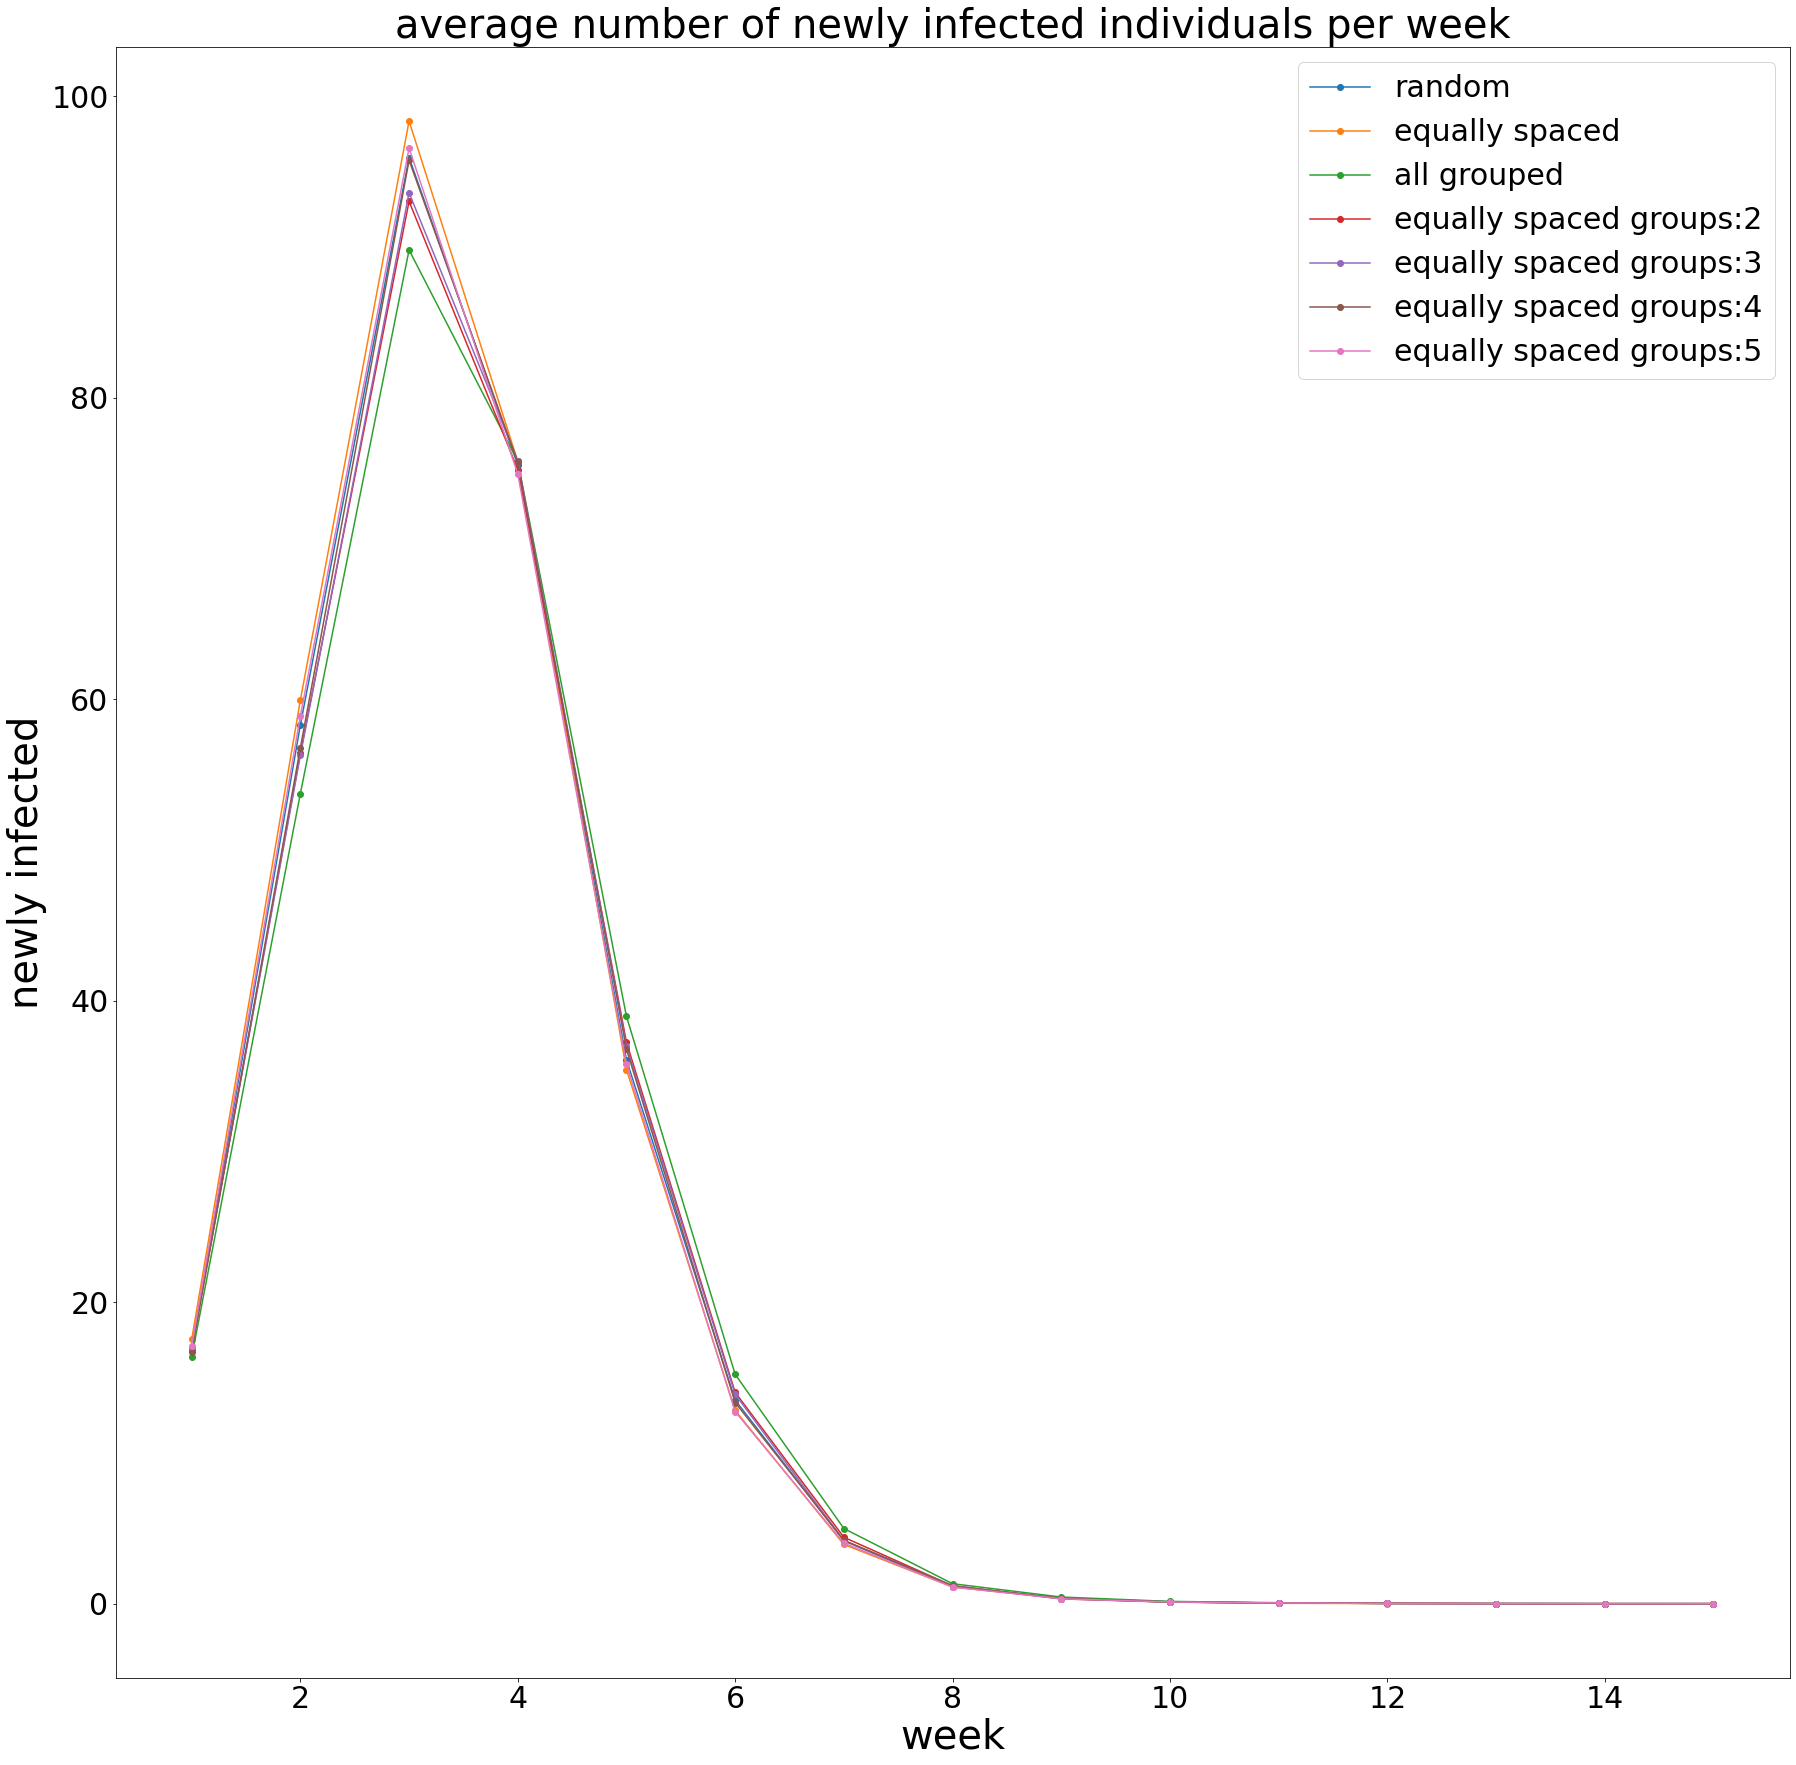

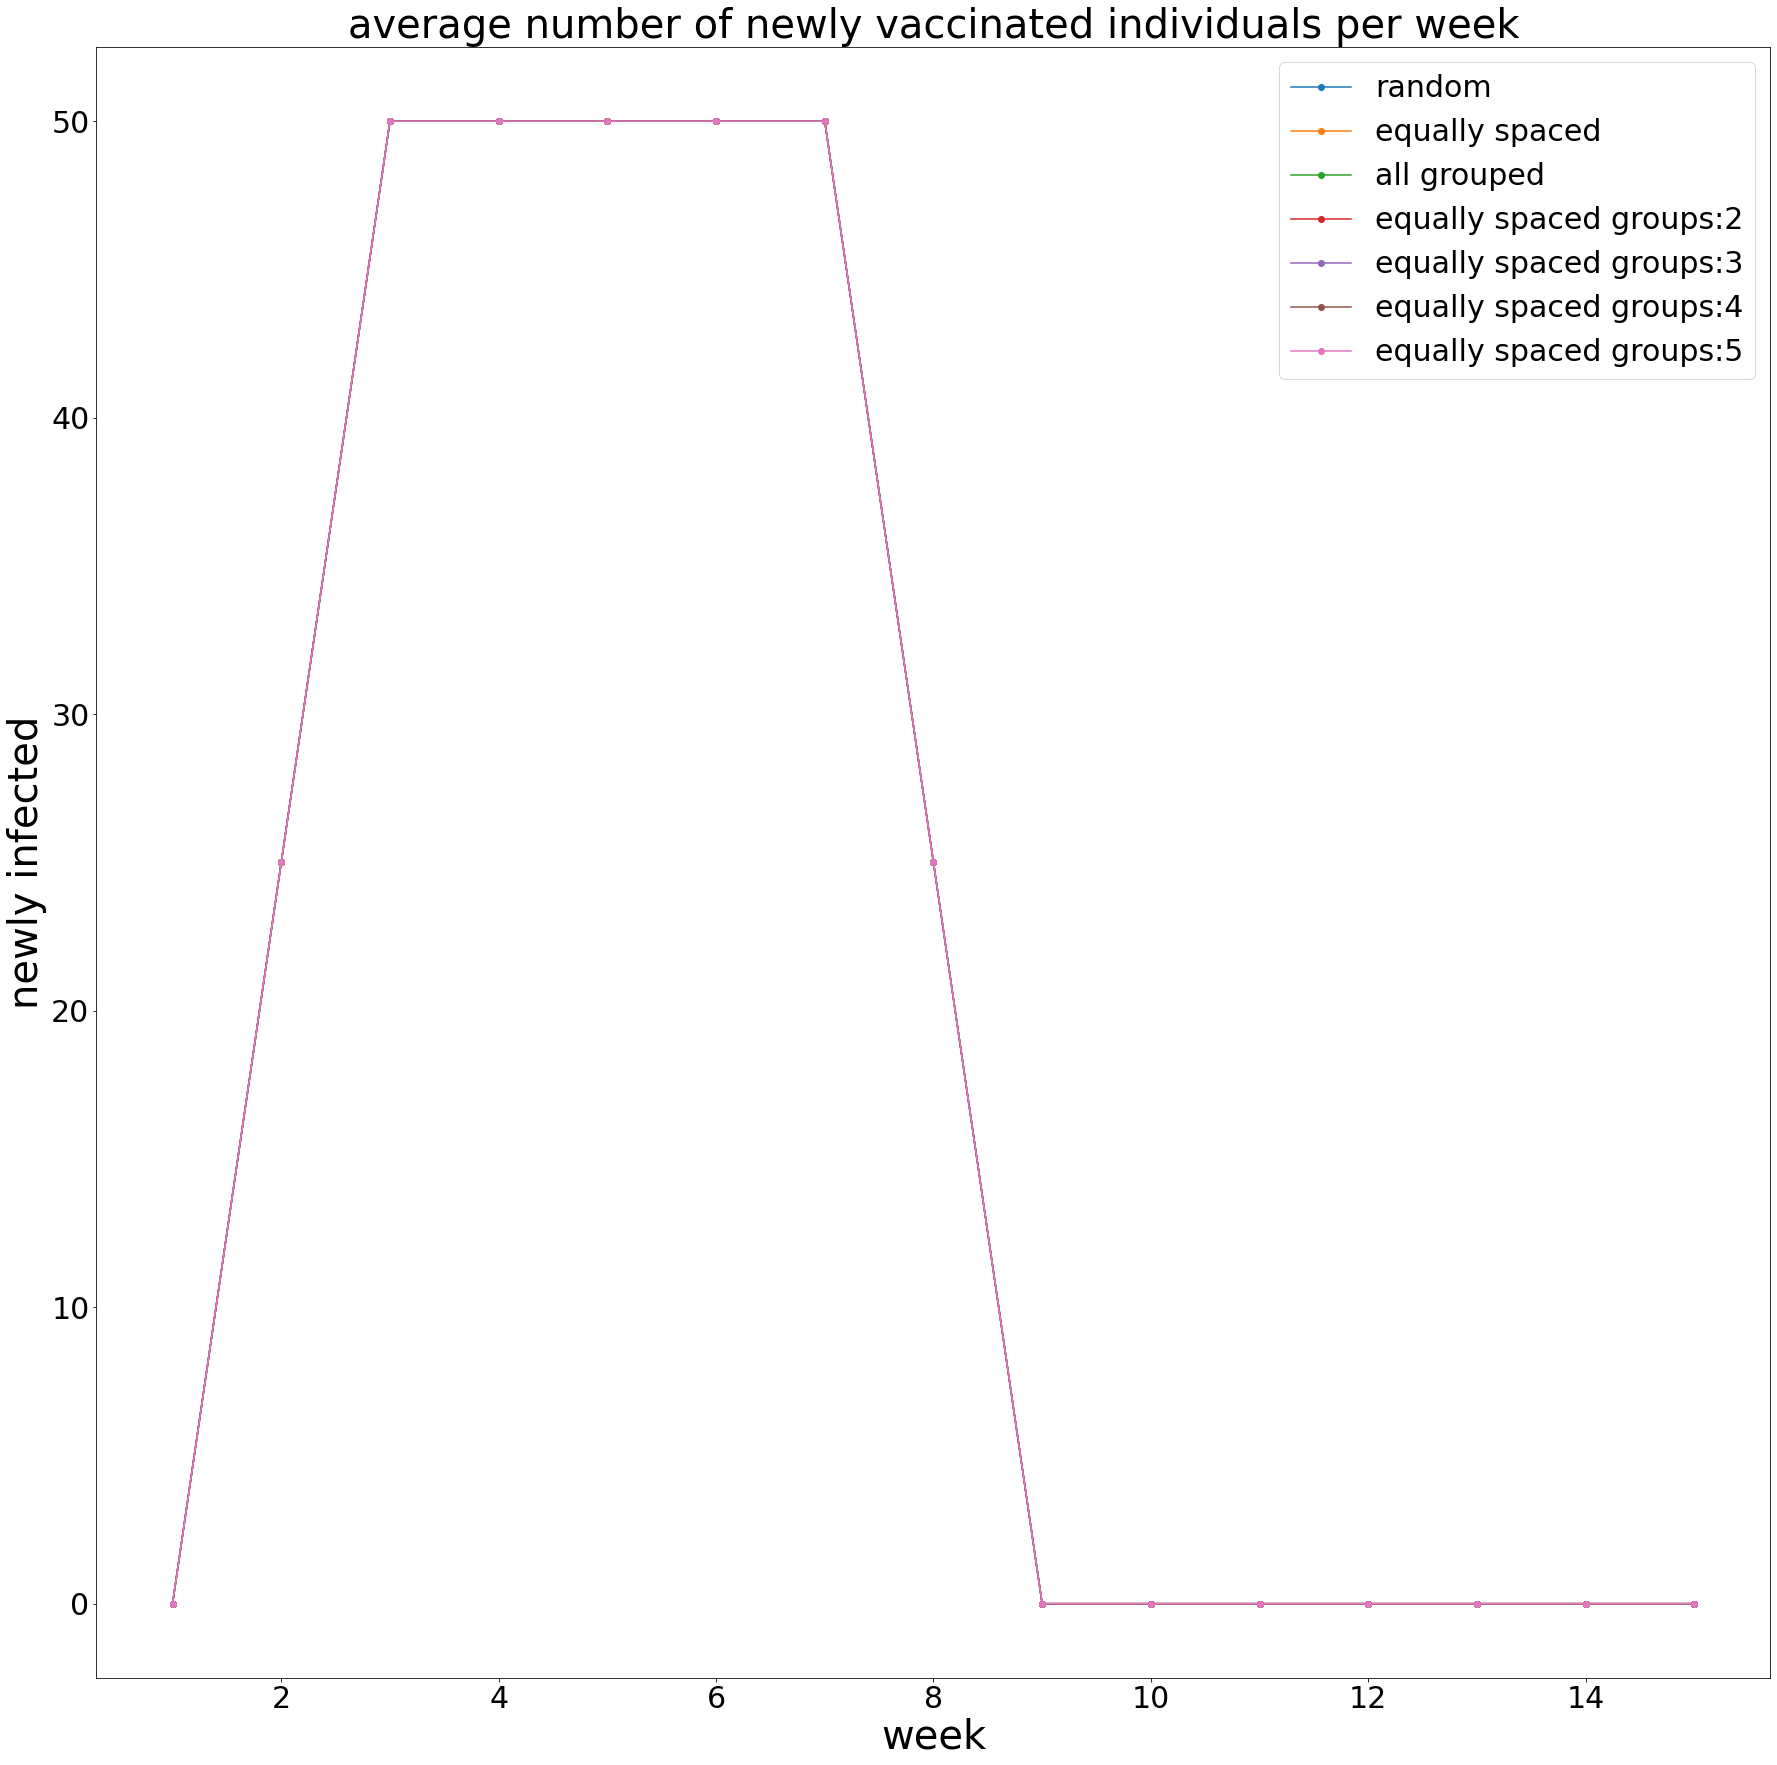

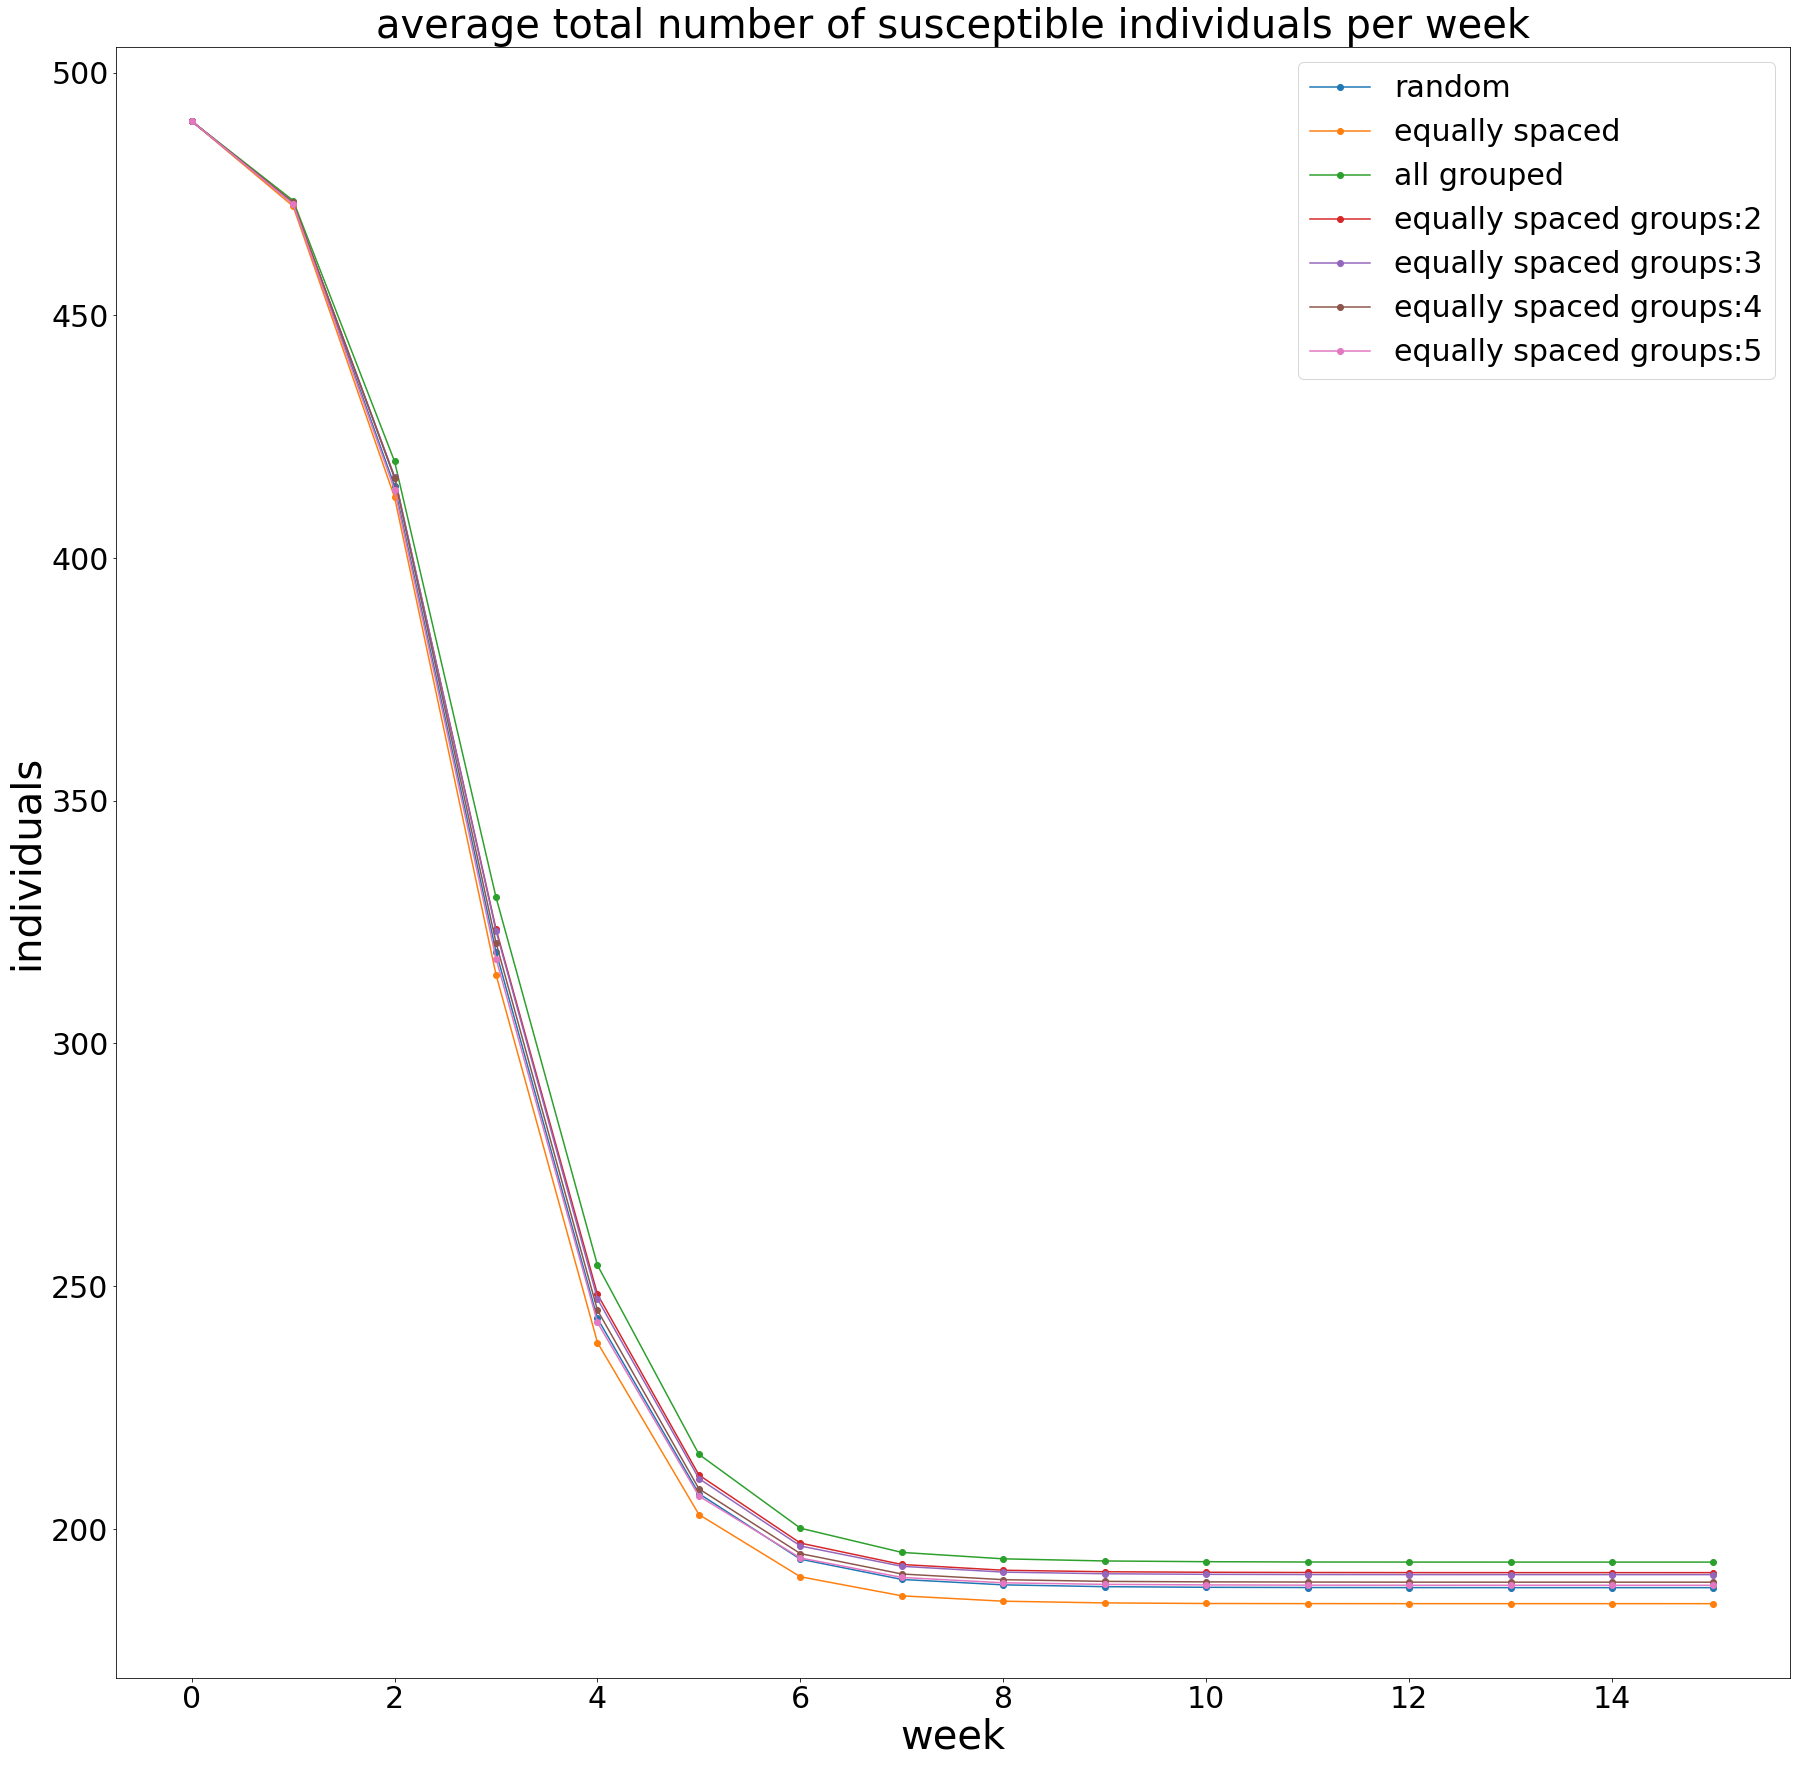

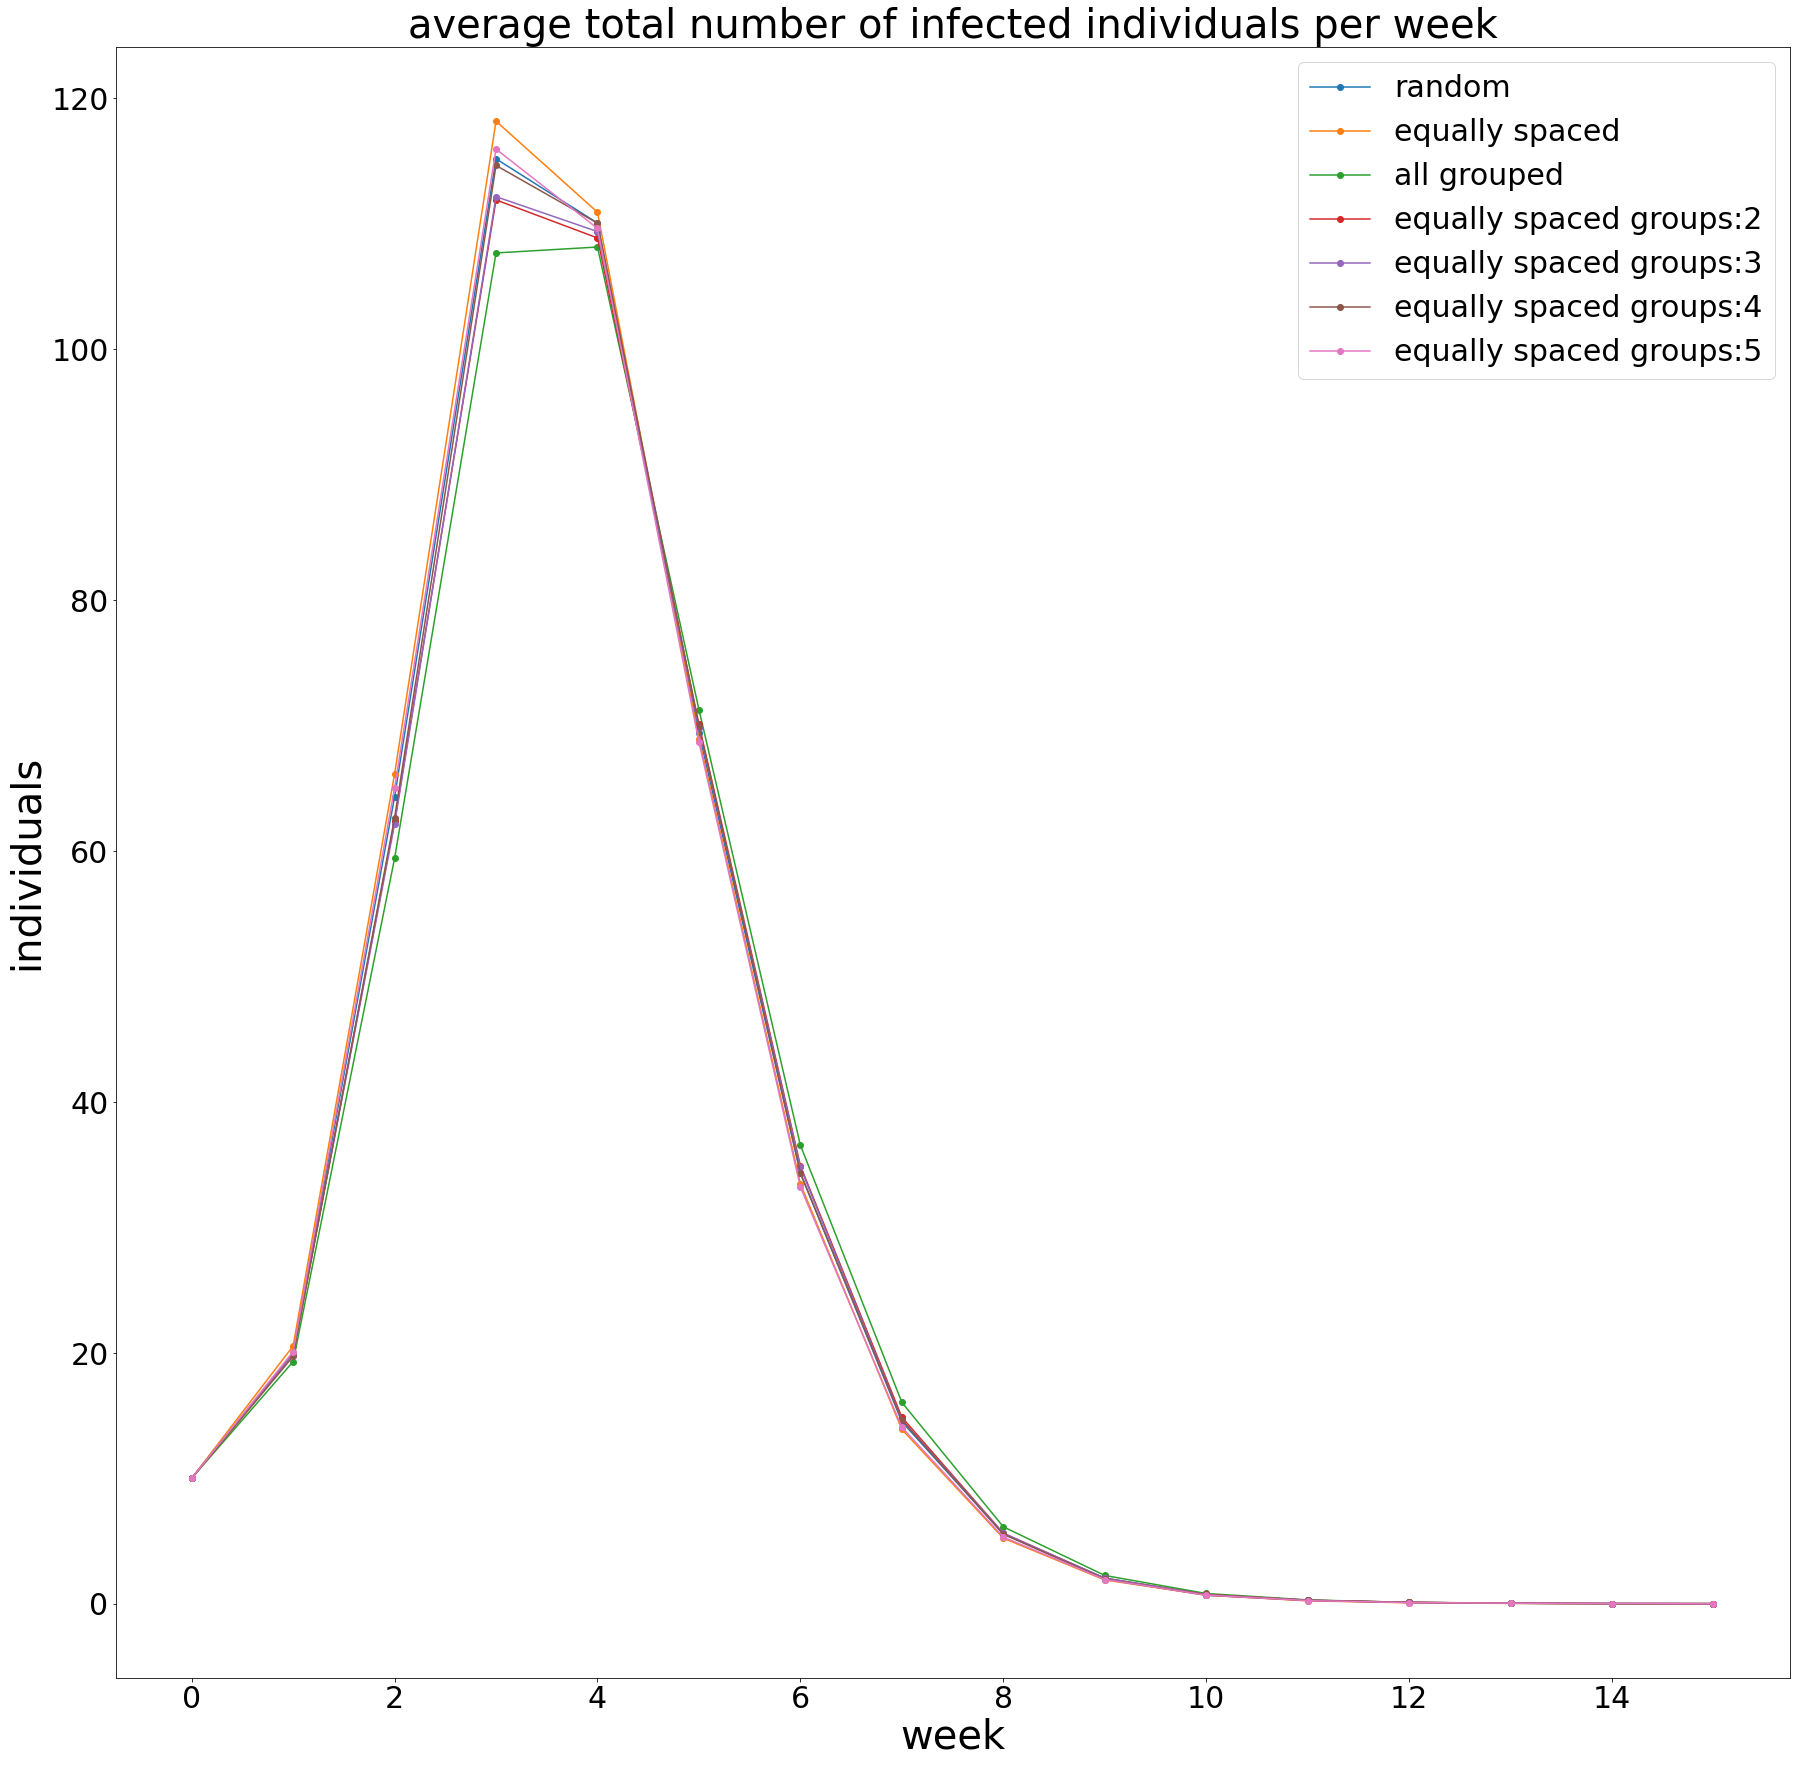

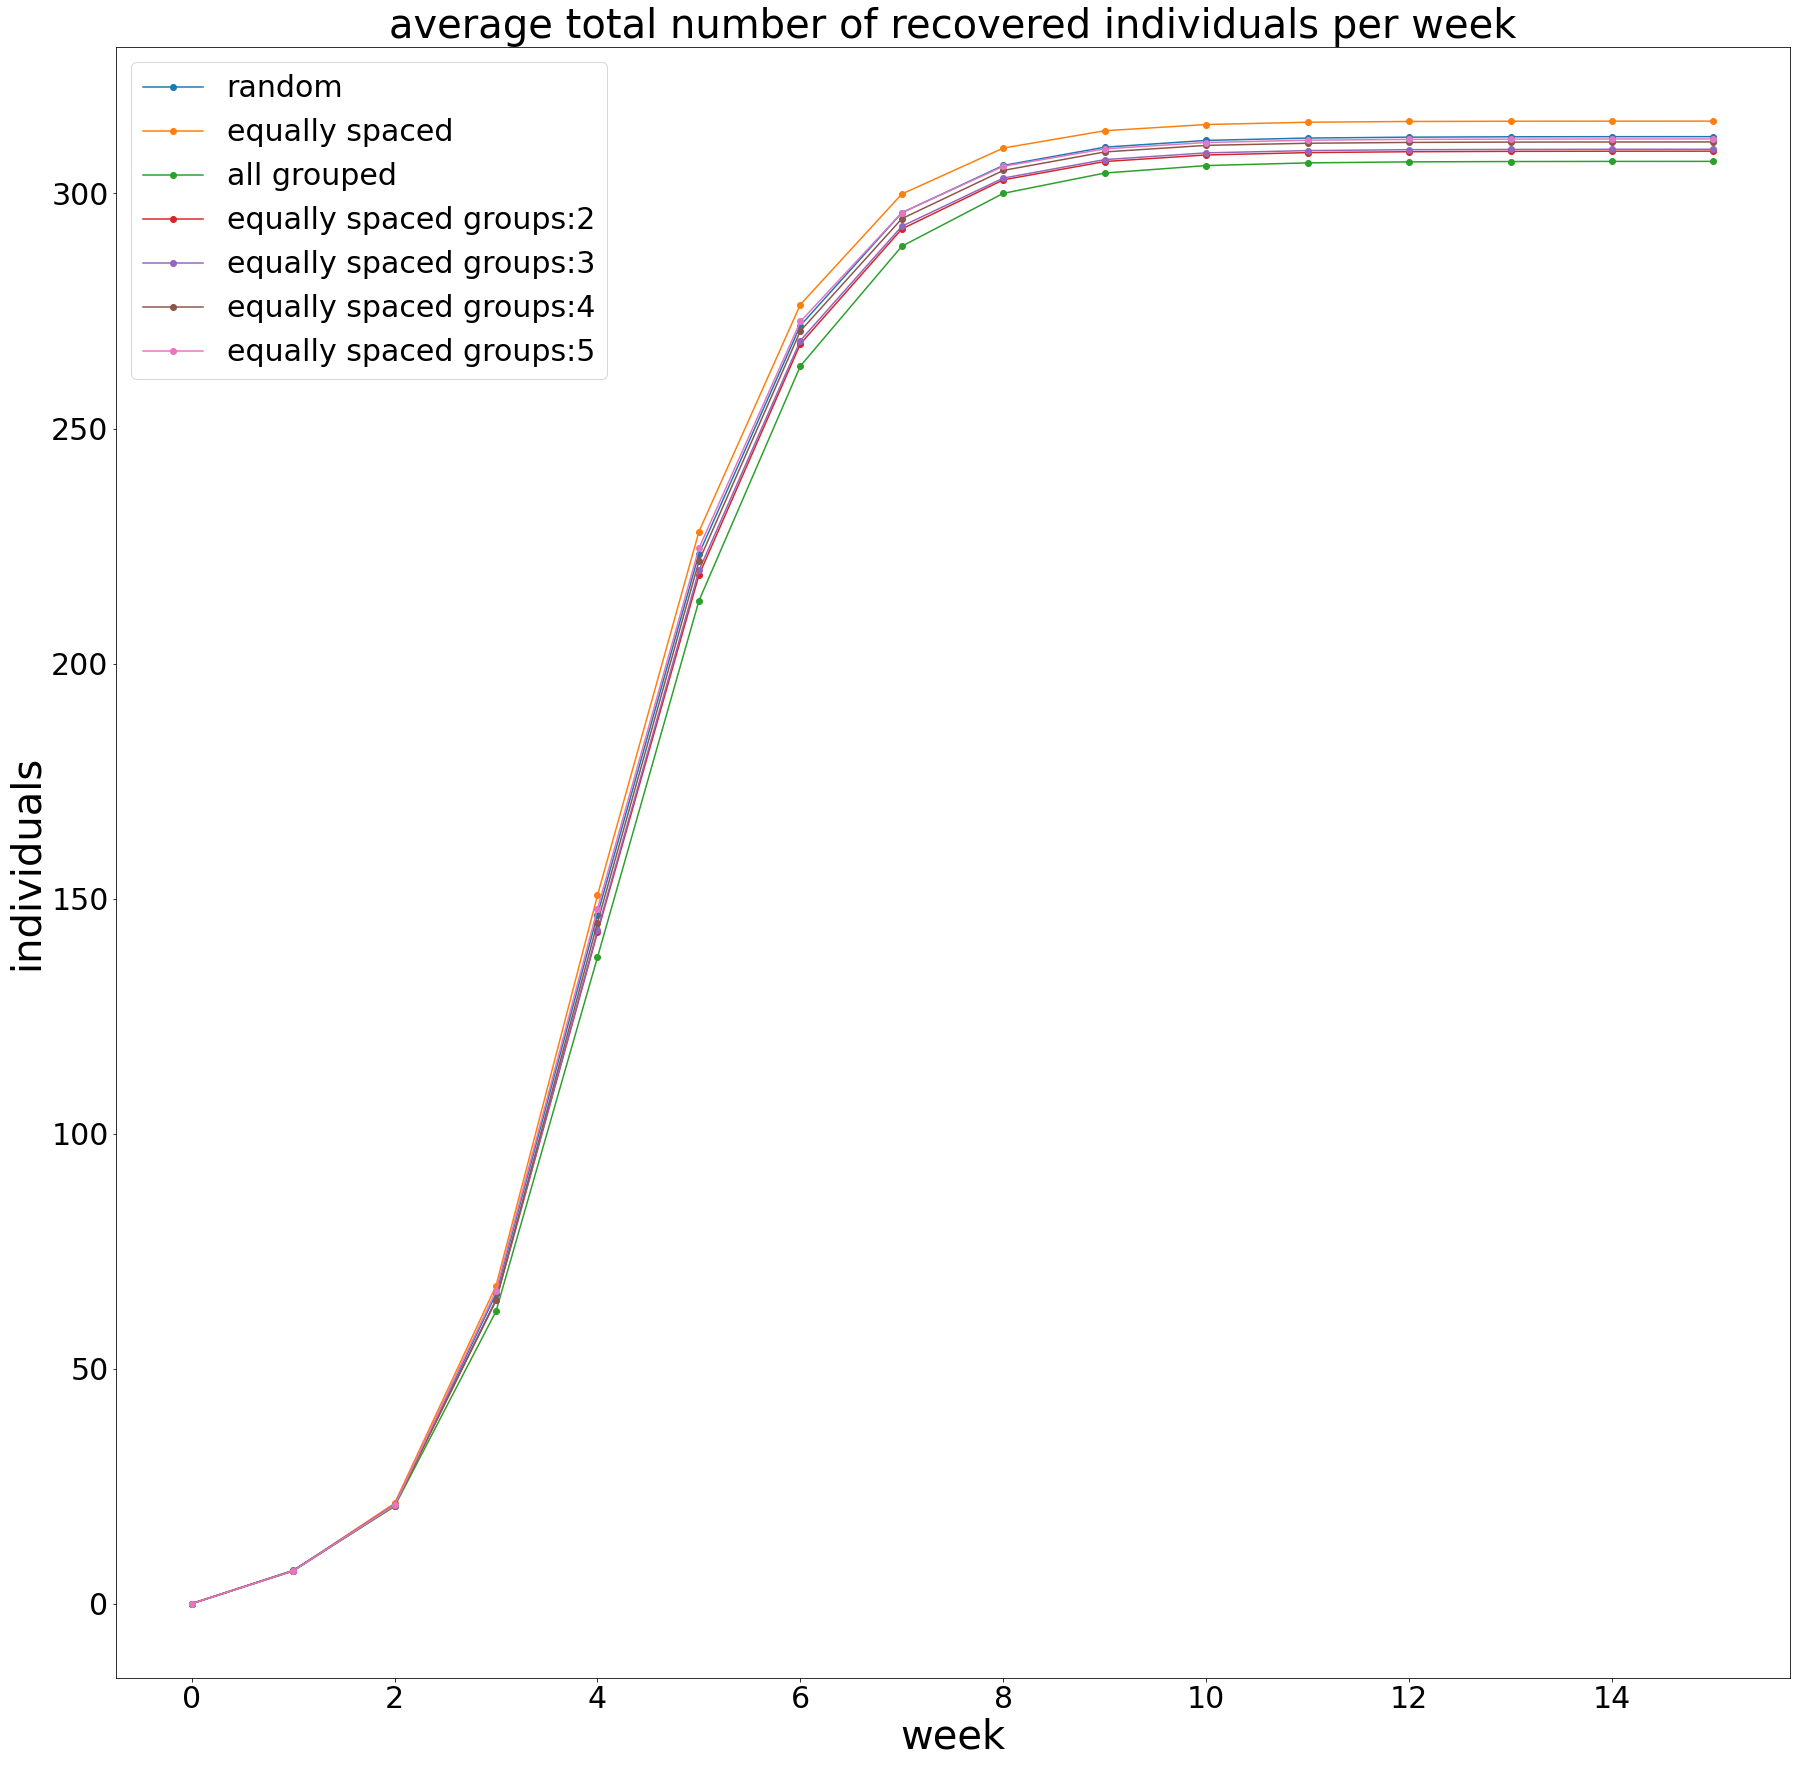

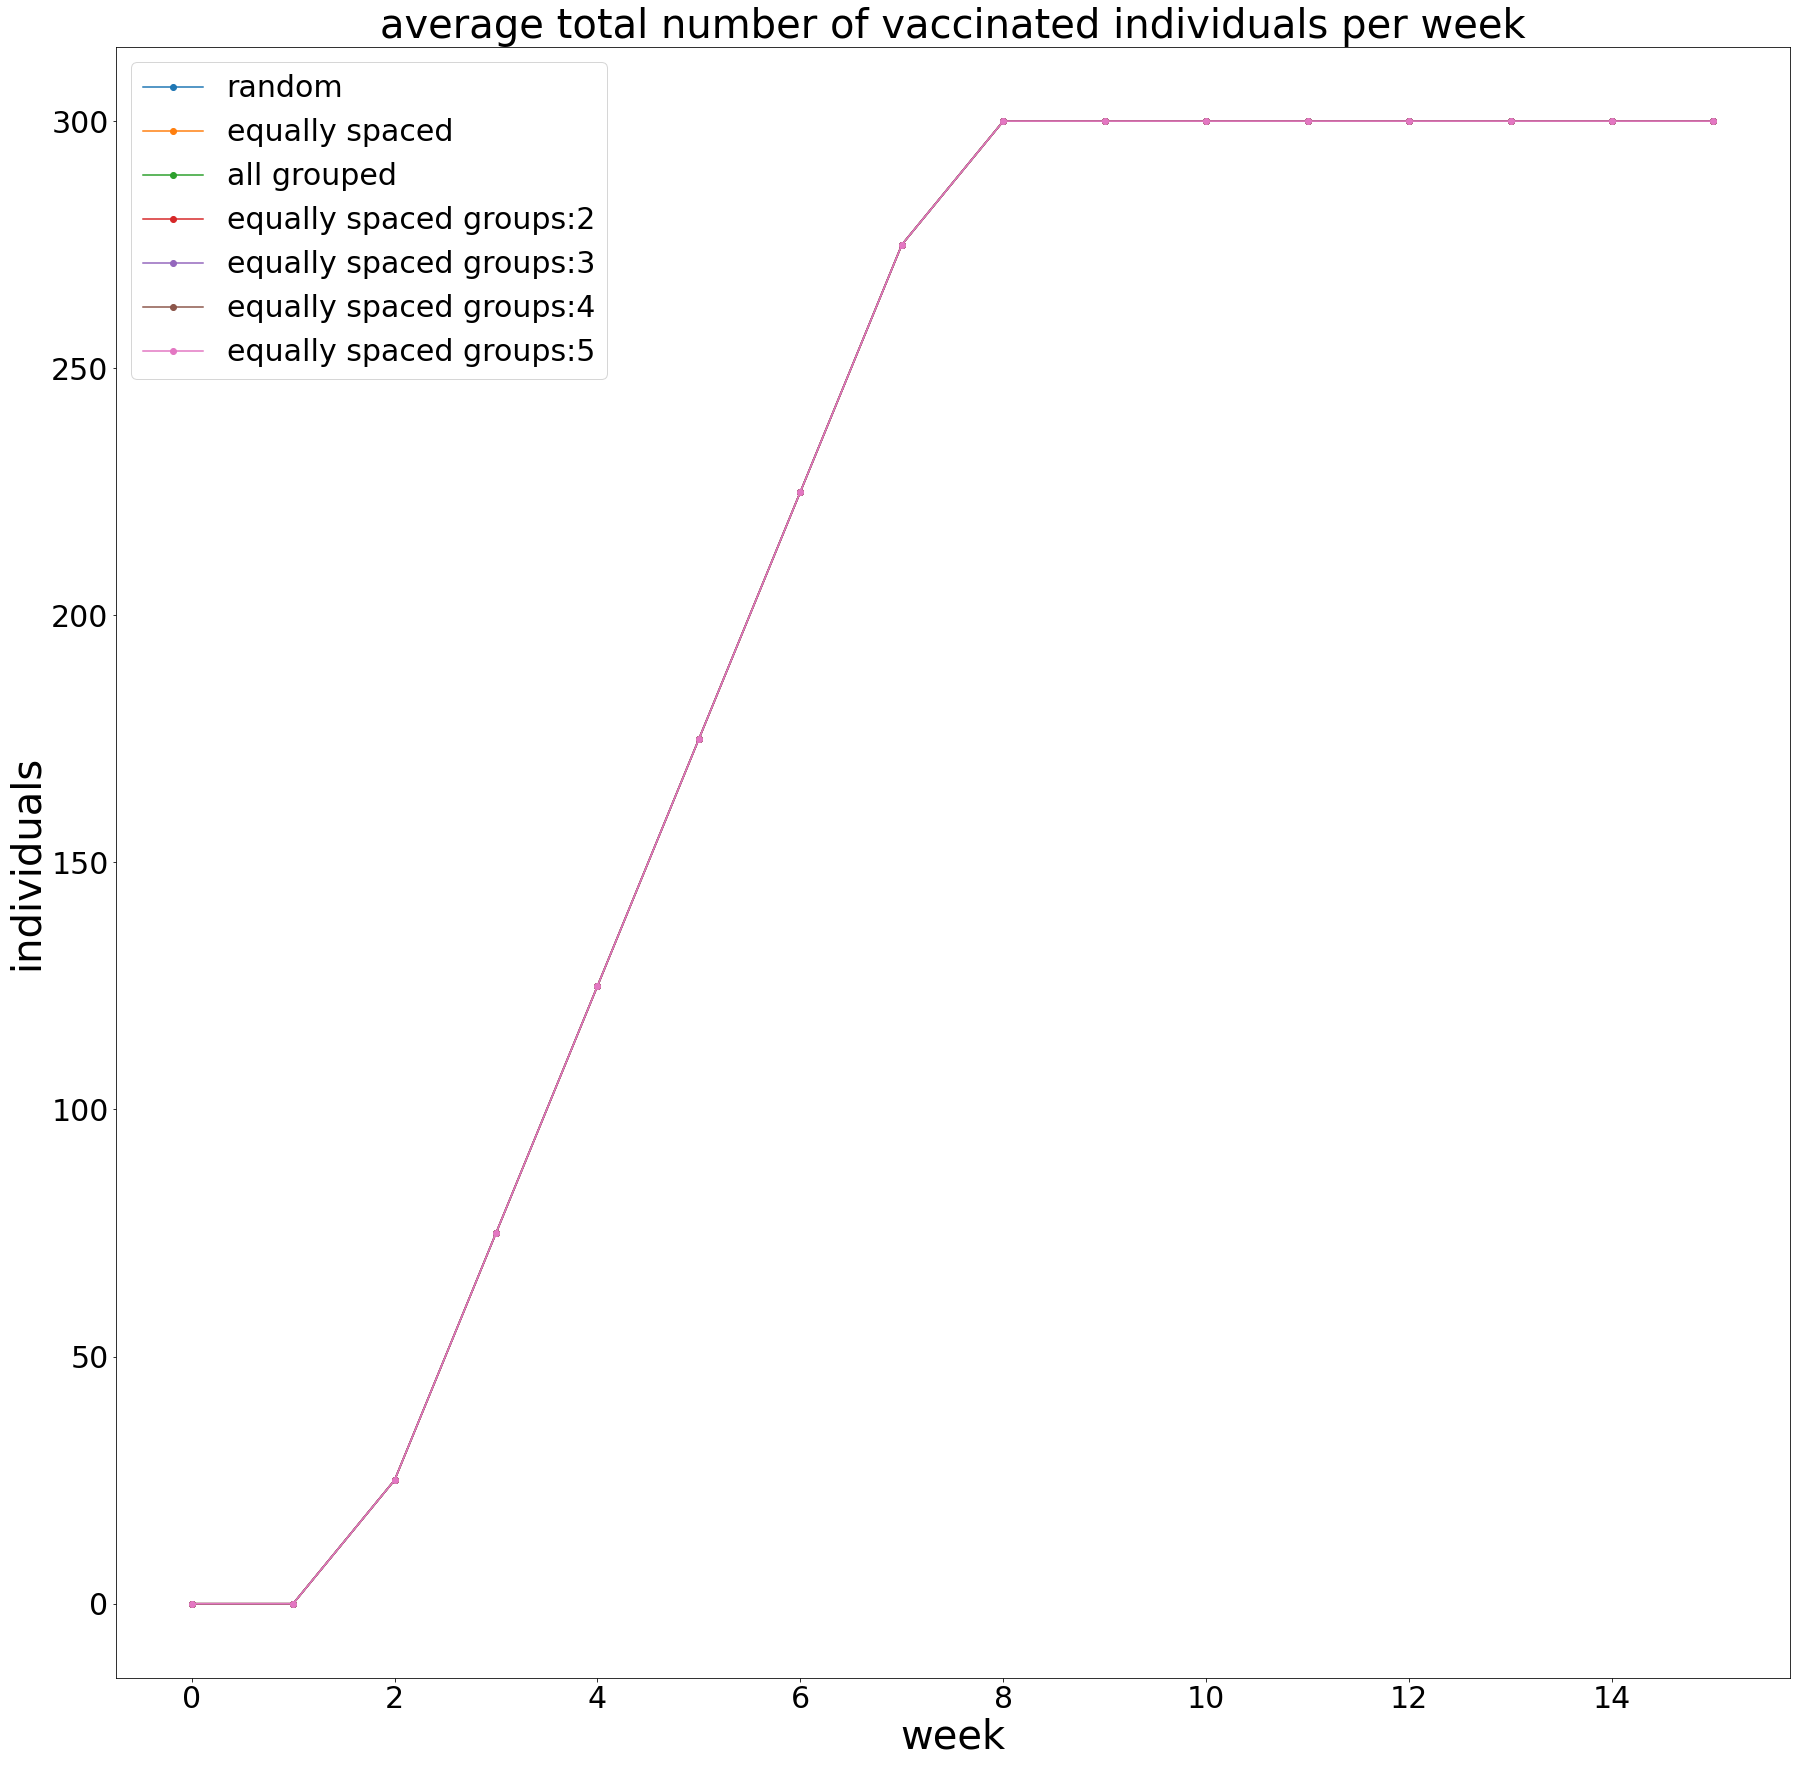

In [36]:
# Simulations with different initial configurations

init_conf = ['random','equally spaced','all grouped']
for n in range(2,6):
    init_conf.append('equally spaced groups:' + str(n))
avg_newly_infected = np.zeros((len(init_conf),weeks))
avg_newly_vaccinated = np.zeros((len(init_conf),weeks))
avg_stats = np.zeros((len(init_conf),len(A)-2,weeks+1))
for c, initial_configuration in enumerate(init_conf):
    n_simulations = 1000
    stats = np.zeros((len(A)-2,n_simulations, weeks+1))
    cum_newly_infected = np.zeros((n_simulations, weeks))
    cum_newly_vaccinated = np.zeros((n_simulations, weeks))
    A_rev = dict((v,k) for k,v in A.items())
    for i in range(n_simulations):
        states = simulate(A, W, beta, ro, 10, 15, initial_configuration, vacc_percentage=vacc, vaccination=True)
        newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
        newly_vaccinated = np.array([np.sum(np.logical_and(is_notVaccinated(states[i-1]), is_vaccinated(states[i]))) for i in range(1, weeks+1)]) # newly vaccinated agent are such that at time unit i-1 they were not vaccinated and at time unit i they are vaccinated
        n_susc_per_week = np.sum(is_susceptible(states),axis=1)
        n_inf_per_week = np.sum(is_infected(states),axis=1)
        n_rec_per_week = np.sum(is_recovered(states),axis=1)
        n_vac_per_week = np.sum(is_vaccinated(states),axis=1)
        cum_newly_infected[i] = newly_infected
        cum_newly_vaccinated[i] = newly_vaccinated
        stats[0,i] = n_susc_per_week
        stats[1,i] = n_inf_per_week
        stats[2,i] = n_rec_per_week
        stats[3,i] = n_vac_per_week

    avg_newly_infected[c] = np.mean(cum_newly_infected,axis=0)
    avg_newly_vaccinated[c] = np.mean(cum_newly_vaccinated,axis=0)
    avg_stats[c] = np.mean(stats,axis=1)


fig = plt.figure(figsize=(30, 30))
for c, initial_configuration in enumerate(init_conf):
    plt.plot(np.arange(1,weeks+1), avg_newly_infected[c], '-o', label = initial_configuration)

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1
    

fig = plt.figure(figsize=(30, 30))
for c, initial_configuration in enumerate(init_conf):
    plt.plot(np.arange(1,weeks+1), avg_newly_vaccinated[c], '-o', label = initial_configuration)

plt.title('average number of newly vaccinated individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1
    

for state in range(len(A)-2):
    fig = plt.figure(figsize=(30, 30))
    for c, initial_configuration in enumerate(init_conf):
        plt.plot(np.arange(weeks+1), avg_stats[c,state], '-o', label = initial_configuration)

    if state!=3:
        plt.title('average total number of ' + list(A.keys())[state] + ' individuals per week', fontsize = 40)
    else:
        plt.title('average total number of ' + 'vaccinated' + ' individuals per week', fontsize = 40)
    plt.xlabel('week', fontsize = 40)
    plt.ylabel('individuals', fontsize = 40)
    plt.xticks(fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.legend(fontsize = 30)
    fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
    img_counter += 1

In [37]:
for c, initial_configuration in enumerate(init_conf):
    print('Average number of newly infected individuals per week - initial configuration:', initial_configuration)
    print(avg_newly_infected[c])
print("\n")
for c, initial_configuration in enumerate(init_conf):
    print('Average number of newly vaccinated individuals per week - initial configuration:', initial_configuration)
    print(avg_newly_vaccinated[c])
print("\n")
for state in range(len(A)-2):
    for c, initial_configuration in enumerate(init_conf):
        if state!=3:
            print('Average total number of ' + list(A.keys())[state] + ' individuals per week - initial configuration:', initial_configuration)
        else:
            print('Average total number of ' + 'vaccinated' + ' individuals per week - initial configuration:', initial_configuration)
        print(avg_stats[c,state])
    print()

Average number of newly infected individuals per week - initial configuration: random
[1.6881e+01 5.8288e+01 9.5932e+01 7.5548e+01 3.6082e+01 1.3500e+01
 4.1730e+00 1.1150e+00 3.7400e-01 1.3000e-01 4.5000e-02 1.7000e-02
 1.0000e-02 0.0000e+00 0.0000e+00]
Average number of newly infected individuals per week - initial configuration: equally spaced
[1.7526e+01 5.9952e+01 9.8348e+01 7.5785e+01 3.5426e+01 1.2817e+01
 3.9260e+00 1.1060e+00 3.5400e-01 1.1800e-01 2.6000e-02 8.0000e-03
 1.0000e-03 0.0000e+00 2.0000e-03]
Average number of newly infected individuals per week - initial configuration: all grouped
[1.6355e+01 5.3736e+01 8.9802e+01 7.5784e+01 3.8958e+01 1.5213e+01
 4.9860e+00 1.3240e+00 4.4000e-01 1.5100e-01 6.4000e-02 1.3000e-02
 4.0000e-03 1.0000e-03 1.0000e-03]
Average number of newly infected individuals per week - initial configuration: equally spaced groups:2
[1.6968e+01 5.6436e+01 9.3026e+01 7.5233e+01 3.7240e+01 1.4015e+01
 4.4050e+00 1.1830e+00 3.1400e-01 1.0400e-01 4.9000e

# The H1N1 pandemic in Sweden 2009

In [39]:
n = 934
vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
vacc = np.insert(vacc,0,0) # by week i<0 0% of individuals is vaccinated
inf_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

n_simulations = 100

In [40]:
n_infected_initial = inf_0[0]
weeks = 15

In [5]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
A['susceptible but vaccinated'] = 3
A['infected but vaccinated'] = 4
A['recovered but vaccinated'] = 5
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))
    
def is_vaccinated(n):
    return n>=3

def is_notVaccinated(n):
    return n<3

def administer_vaccinate(n):
    return n+3

def is_susceptible(n):
    return n%3==0

def is_infected(n):
    return n%3==1

def is_recovered(n):
    return n%3==2

def recover(n):
    return n+1

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2
susceptible but vaccinated: 3
infected but vaccinated: 4
recovered but vaccinated: 5


Gradient-based search algorithm

In [50]:
import itertools

k0 = 10
beta0 = 0.3
ro0 = 0.6

delta_k = 1
delta_beta = 0.1
delta_ro = 0.1

def check_ranges(k, beta, ro):
    if k<1:
        return False
    if beta<0 or beta>1:
        return False
    if ro<0 or ro>1:
        return False
    return True

In [55]:
def RMSE(true_value, computed_value):
    return np.sqrt(np.sum((computed_value-true_value)**2)/(true_value.shape[0]))

In [24]:
prev_conf = (-1,-1,-1)
while not all([math.isclose(a, b) for a, b in zip(prev_conf, (k0, beta0, ro0))]):
    
    print("k0 =", k0, "beta0 =", beta0, "ro0 =", ro0)
    
    prev_conf = k0, beta0, ro0
    offsets = [-1,0,1]
    k = [k0+off*delta_k for off in offsets]
    beta = [beta0+off*delta_beta for off in offsets]
    ro = [ro0+off*delta_ro for off in offsets]

    err_conf = {}
    for (k_i, beta_i, ro_i) in itertools.product(k,beta,ro):
        if check_ranges(k_i, beta_i, ro_i):
            k_i = round(k_i)
            G = generate_gpa(n, k_i, demo=False)
            n_agents = len(G)
            W = nx.convert_matrix.to_numpy_matrix(G)

            cum_newly_infected = np.zeros((n_simulations, weeks))
            A_rev = dict((v,k) for k,v in A.items())
            for i in range(n_simulations):
                states = simulate(A, W, beta_i, ro_i, n_infected_initial, weeks, vacc_percentage=vacc, vaccination=True)
                newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
                cum_newly_infected[i] = newly_infected
            avg_newly_infected = np.mean(cum_newly_infected,axis=0)

            err = RMSE(inf_0[1:], avg_newly_infected)

            err_conf[(k_i, beta_i, ro_i)] = err

            print("\tk =", k_i, "beta =", beta_i, "ro =", ro_i)
            print("\tRMSE =", err)

    min_conf, min_err = min(err_conf.items(), key=lambda x: x[1])
    
    print("min: ", min_conf)
    print("min RMSE =", min_err)
    print()
    
    k0, beta0, ro0 = min_conf

k0 = 10 beta0 = 0.3 ro0 = 0.6
	k = 9 beta = 0.19999999999999998 ro = 0.5
	RMSE = 10.998558693453125
	k = 9 beta = 0.19999999999999998 ro = 0.6
	RMSE = 9.321350760485306
	k = 9 beta = 0.19999999999999998 ro = 0.7
	RMSE = 8.155298482173007
	k = 9 beta = 0.3 ro = 0.5
	RMSE = 36.31623980168285
	k = 9 beta = 0.3 ro = 0.6
	RMSE = 31.828152108890432
	k = 9 beta = 0.3 ro = 0.7
	RMSE = 30.03672163646803
	k = 9 beta = 0.4 ro = 0.5
	RMSE = 59.725326342069216
	k = 9 beta = 0.4 ro = 0.6
	RMSE = 60.972685086575176
	k = 9 beta = 0.4 ro = 0.7
	RMSE = 58.76090758318833
	k = 10 beta = 0.19999999999999998 ro = 0.5
	RMSE = 18.814876738014167
	k = 10 beta = 0.19999999999999998 ro = 0.6
	RMSE = 16.124974211865684
	k = 10 beta = 0.19999999999999998 ro = 0.7
	RMSE = 15.891795996677027
	k = 10 beta = 0.3 ro = 0.5
	RMSE = 43.25131196468688
	k = 10 beta = 0.3 ro = 0.6
	RMSE = 40.73353638792815
	k = 10 beta = 0.3 ro = 0.7
	RMSE = 39.296260127396344
	k = 10 beta = 0.4 ro = 0.5
	RMSE = 69.0336034116719
	k = 10 beta

Different values for $\Delta k, \Delta \beta, \Delta \rho$

In [54]:
k0 = 20
beta0 = 0.5
ro0 = 0.5

step = 0.75

delta_k = 20/step
delta_beta = 0.5/step
delta_ro = 0.5/step

In [55]:
for _ in range(8):
    delta_k *= step
    delta_beta *= step
    delta_ro *= step
    
    print("delta_k =", delta_k, "delta_beta =", delta_beta, "delta_ro =", delta_ro)
    prev_conf = (-1,-1,-1)
    while not all([math.isclose(a, b) for a, b in zip(prev_conf, (k0, beta0, ro0))]):

        print("k0 =", k0, "beta0 =", beta0, "ro0 =", ro0)

        prev_conf = k0, beta0, ro0
        offsets = [-1,0,1]
        k = [k0+off*delta_k for off in offsets]
        beta = [beta0+off*delta_beta for off in offsets]
        ro = [ro0+off*delta_ro for off in offsets]

        err_conf = {}
        for (k_i, beta_i, ro_i) in itertools.product(k,beta,ro):
            if check_ranges(k_i, beta_i, ro_i):
                k_i = round(k_i)
                G = generate_gpa(n, k_i, demo=False)
                n_agents = len(G)
                W = nx.convert_matrix.to_numpy_matrix(G)

                cum_newly_infected = np.zeros((n_simulations, weeks))
                A_rev = dict((v,k) for k,v in A.items())
                for i in range(n_simulations):
                    states = simulate(A, W, beta_i, ro_i, n_infected_initial, weeks, vacc_percentage=vacc, vaccination=True)
                    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
                    cum_newly_infected[i] = newly_infected
                avg_newly_infected = np.mean(cum_newly_infected,axis=0)

                err = RMSE(inf_0[1:], avg_newly_infected)

                err_conf[(k_i, beta_i, ro_i)] = err

                print("\tk =", k_i, "beta =", beta_i, "ro =", ro_i)
                print("\tRMSE =", err)

        min_conf, min_err = min(err_conf.items(), key=lambda x: x[1])

        print("min: ", min_conf)
        print("min RMSE =", min_err)
        print()

        k0, beta0, ro0 = min_conf

delta_k = 20.0 delta_beta = 0.5 delta_ro = 0.5
k0 = 20 beta0 = 0.5 ro0 = 0.5
	k = 20 beta = 0.0 ro = 0.0
	RMSE = 13.594116374373144
	k = 20 beta = 0.0 ro = 0.5
	RMSE = 13.594116374373144
	k = 20 beta = 0.0 ro = 1.0
	RMSE = 13.594116374373144
	k = 20 beta = 0.5 ro = 0.0
	RMSE = 124.54726184598894
	k = 20 beta = 0.5 ro = 0.5
	RMSE = 126.81731606264712
	k = 20 beta = 0.5 ro = 1.0
	RMSE = 127.86420103635993
	k = 20 beta = 1.0 ro = 0.0
	RMSE = 132.07089136772973
	k = 20 beta = 1.0 ro = 0.5
	RMSE = 141.06576995619218
	k = 20 beta = 1.0 ro = 1.0
	RMSE = 140.66555975077907
	k = 40 beta = 0.0 ro = 0.0
	RMSE = 13.594116374373144
	k = 40 beta = 0.0 ro = 0.5
	RMSE = 13.594116374373144
	k = 40 beta = 0.0 ro = 1.0
	RMSE = 13.594116374373144
	k = 40 beta = 0.5 ro = 0.0
	RMSE = 140.16789718048852
	k = 40 beta = 0.5 ro = 0.5
	RMSE = 137.489708487581
	k = 40 beta = 0.5 ro = 1.0
	RMSE = 136.63197605245998
	k = 40 beta = 1.0 ro = 0.0
	RMSE = 162.45006063402994
	k = 40 beta = 1.0 ro = 0.5
	RMSE = 166.22262

	k = 16 beta = 0.09375 ro = 0.46875
	RMSE = 4.994571052653071
	k = 16 beta = 0.09375 ro = 0.626953125
	RMSE = 6.023949424311817
	k = 16 beta = 0.251953125 ro = 0.310546875
	RMSE = 72.20924322181106
	k = 16 beta = 0.251953125 ro = 0.46875
	RMSE = 68.30665370225655
	k = 16 beta = 0.251953125 ro = 0.626953125
	RMSE = 66.6011119026302
	k = 22 beta = 0.09375 ro = 0.310546875
	RMSE = 26.04209156986692
	k = 22 beta = 0.09375 ro = 0.46875
	RMSE = 16.757339685443313
	k = 22 beta = 0.09375 ro = 0.626953125
	RMSE = 15.88001364399078
	k = 22 beta = 0.251953125 ro = 0.310546875
	RMSE = 91.62533103168943
	k = 22 beta = 0.251953125 ro = 0.46875
	RMSE = 89.76600674345866
	k = 22 beta = 0.251953125 ro = 0.626953125
	RMSE = 84.69135524558178
min:  (16, 0.09375, 0.46875)
min RMSE = 4.994571052653071

delta_k = 4.74609375 delta_beta = 0.11865234375 delta_ro = 0.11865234375
k0 = 16 beta0 = 0.09375 ro0 = 0.46875
	k = 11 beta = 0.09375 ro = 0.35009765625
	RMSE = 8.305824863712614
	k = 11 beta = 0.09375 ro = 

	k = 12 beta = 0.09375 ro = 0.58740234375
	RMSE = 9.493053249613634
	k = 12 beta = 0.09375 ro = 0.6763916015625
	RMSE = 11.262929755026738
	k = 12 beta = 0.1827392578125 ro = 0.4984130859375
	RMSE = 19.68667535839068
	k = 12 beta = 0.1827392578125 ro = 0.58740234375
	RMSE = 19.935032982164838
	k = 12 beta = 0.1827392578125 ro = 0.6763916015625
	RMSE = 19.010359105848934
	k = 16 beta = 0.0047607421875 ro = 0.4984130859375
	RMSE = 13.592651446032644
	k = 16 beta = 0.0047607421875 ro = 0.58740234375
	RMSE = 13.591090709235468
	k = 16 beta = 0.0047607421875 ro = 0.6763916015625
	RMSE = 13.593110264640197
	k = 16 beta = 0.09375 ro = 0.4984130859375
	RMSE = 5.0702268193839215
	k = 16 beta = 0.09375 ro = 0.58740234375
	RMSE = 5.399514793016128
	k = 16 beta = 0.09375 ro = 0.6763916015625
	RMSE = 5.872966882249549
	k = 16 beta = 0.1827392578125 ro = 0.4984130859375
	RMSE = 44.43246740841657
	k = 16 beta = 0.1827392578125 ro = 0.58740234375
	RMSE = 41.56289483020482
	k = 16 beta = 0.182739257812

Search for different local minima

In [77]:
k_start = 10
beta_start = 0.3
ro_start = 0.6

delta_k = 1
delta_beta = 0.1
delta_ro = 0.1

n_iterations = 50

incr = 3

In [79]:
import queue
fifo = queue.Queue()
fifo.put((k_start, beta_start, ro_start))

best_min_conf = ((-1,-1,-1),float("inf"))
for _ in range(n_iterations):
    k0, beta0, ro0 = fifo.get()
    
    print("k_start =", k0, "beta_start =", beta0, "ro_start =", ro0)
    
    prev_conf = (-1,-1,-1)
    while not all([math.isclose(a, b) for a, b in zip(prev_conf, (k0, beta0, ro0))]):

        print("\tk0 =", k0, "beta0 =", beta0, "ro0 =", ro0)

        prev_conf = k0, beta0, ro0
        offsets = [-1,0,1]
        k = [k0+off*delta_k for off in offsets]
        beta = [beta0+off*delta_beta for off in offsets]
        ro = [ro0+off*delta_ro for off in offsets]

        err_conf = {}
        for (k_i, beta_i, ro_i) in itertools.product(k,beta,ro):
            if check_ranges(k_i, beta_i, ro_i):
                k_i = round(k_i)
                G = generate_gpa(n, k_i, demo=False)
                n_agents = len(G)
                W = nx.convert_matrix.to_numpy_matrix(G)

                cum_newly_infected = np.zeros((n_simulations, weeks))
                A_rev = dict((v,k) for k,v in A.items())
                for i in range(n_simulations):
                    states = simulate(A, W, beta_i, ro_i, n_infected_initial, weeks, vacc_percentage=vacc, vaccination=True)
                    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
                    cum_newly_infected[i] = newly_infected
                avg_newly_infected = np.mean(cum_newly_infected,axis=0)

                err = RMSE(inf_0[1:], avg_newly_infected)

                err_conf[(k_i, beta_i, ro_i)] = err

                print("\t\tk =", k_i, "beta =", beta_i, "ro =", ro_i)
                print("\t\tRMSE =", err)

        min_conf, min_err = min(err_conf.items(), key=lambda x: x[1])

        print("\tmin: ", min_conf)
        print("\tmin RMSE =", min_err)
        print()

        k0, beta0, ro0 = min_conf
        
    if min_err<best_min_conf[1]:
        best_min_conf = (min_conf, min_err)
        
    print("\tlocal min: ", min_conf)
    print("\tlocal min RMSE =", min_err)
    print()
            
    # generate new neighbours
    k1 = k0
    beta1 = beta0
    ro1 = ro0 + incr*delta_ro
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    k1 = k0
    beta1 = beta0
    ro1 = ro0 - incr*delta_ro
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    k1 = k0
    beta1 = beta0 +  incr*delta_beta
    ro1 = ro0
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    k1 = k0
    beta1 = beta0 -  incr*delta_beta
    ro1 = ro0
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    k1 = k0 + incr*delta_k
    beta1 = beta0 
    ro1 = ro0
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    k1 = k0 - incr*delta_k
    beta1 = beta0 
    ro1 = ro0
    if check_ranges(k1, beta1, ro1):
        fifo.put((k1, beta1, ro1))
        
    print()
    print()

min_conf, min_err = best_min_conf

print("\\n\n(potential) global min: ", min_conf)
print("(potential) global min RMSE =", min_err)

k_start = 10 beta_start = 0.3 ro_start = 0.6
	k0 = 10 beta0 = 0.3 ro0 = 0.6
		k = 9 beta = 0.19999999999999998 ro = 0.5
		RMSE = 10.155925035826787
		k = 9 beta = 0.19999999999999998 ro = 0.6
		RMSE = 9.153519905843142
		k = 9 beta = 0.19999999999999998 ro = 0.7
		RMSE = 9.234170960802778
		k = 9 beta = 0.3 ro = 0.5
		RMSE = 34.74187444568874
		k = 9 beta = 0.3 ro = 0.6
		RMSE = 37.256206462816365
		k = 9 beta = 0.3 ro = 0.7
		RMSE = 27.663772941038488
		k = 9 beta = 0.4 ro = 0.5
		RMSE = 61.895442481656104
		k = 9 beta = 0.4 ro = 0.6
		RMSE = 57.897773014166965
		k = 9 beta = 0.4 ro = 0.7
		RMSE = 53.16739408070828
		k = 10 beta = 0.19999999999999998 ro = 0.5
		RMSE = 15.923457329780277
		k = 10 beta = 0.19999999999999998 ro = 0.6
		RMSE = 16.592724911840126
		k = 10 beta = 0.19999999999999998 ro = 0.7
		RMSE = 11.555410853794857
		k = 10 beta = 0.3 ro = 0.5
		RMSE = 43.05895756595446
		k = 10 beta = 0.3 ro = 0.6
		RMSE = 47.25446229369949
		k = 10 beta = 0.3 ro = 0.7
		RMSE = 36.0073

		k = 6 beta = 0.3 ro = 0.6
		RMSE = 11.2660158589154
		k = 7 beta = 0.09999999999999998 ro = 0.4
		RMSE = 12.55665003095969
		k = 7 beta = 0.09999999999999998 ro = 0.5
		RMSE = 12.473502582140538
		k = 7 beta = 0.09999999999999998 ro = 0.6
		RMSE = 12.91776399639917
		k = 7 beta = 0.19999999999999998 ro = 0.4
		RMSE = 5.754490999790222
		k = 7 beta = 0.19999999999999998 ro = 0.5
		RMSE = 6.0431068168616715
		k = 7 beta = 0.19999999999999998 ro = 0.6
		RMSE = 6.659476455898517
		k = 7 beta = 0.3 ro = 0.4
		RMSE = 23.282362136747782
		k = 7 beta = 0.3 ro = 0.5
		RMSE = 16.390188528506926
		k = 7 beta = 0.3 ro = 0.6
		RMSE = 18.584135707640538
		k = 8 beta = 0.09999999999999998 ro = 0.4
		RMSE = 11.128857683218586
		k = 8 beta = 0.09999999999999998 ro = 0.5
		RMSE = 12.137374235531068
		k = 8 beta = 0.09999999999999998 ro = 0.6
		RMSE = 12.435357118581946
		k = 8 beta = 0.19999999999999998 ro = 0.4
		RMSE = 8.127276296521485
		k = 8 beta = 0.19999999999999998 ro = 0.5
		RMSE = 5.13977690

		k = 7 beta = 0.3 ro = 0.6000000000000001
		RMSE = 15.097877555029601
		k = 7 beta = 0.3 ro = 0.7000000000000001
		RMSE = 16.871597434742213
		k = 8 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 11.964138080112583
		k = 8 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 12.61362992956429
		k = 8 beta = 0.09999999999999998 ro = 0.7000000000000001
		RMSE = 12.667803019203184
		k = 8 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 6.023584204331061
		k = 8 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 5.104374594404294
		k = 8 beta = 0.19999999999999998 ro = 0.7000000000000001
		RMSE = 6.227074219353205
		k = 8 beta = 0.3 ro = 0.5000000000000001
		RMSE = 26.084015156157736
		k = 8 beta = 0.3 ro = 0.6000000000000001
		RMSE = 23.67813252771426
		k = 8 beta = 0.3 ro = 0.7000000000000001
		RMSE = 20.735110641936142
		k = 9 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 11.266400489952415
		k = 9 beta = 0.09999999999999998 ro = 0

		k = 6 beta = 0.3 ro = 0.30000000000000004
		RMSE = 14.781092652439465
		k = 6 beta = 0.3 ro = 0.4
		RMSE = 13.193217954691722
		k = 6 beta = 0.3 ro = 0.5
		RMSE = 10.508966013203521
		k = 7 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 11.540058058779428
		k = 7 beta = 0.09999999999999998 ro = 0.4
		RMSE = 12.339199866009679
		k = 7 beta = 0.09999999999999998 ro = 0.5
		RMSE = 12.7132104521242
		k = 7 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 5.914804026057555
		k = 7 beta = 0.19999999999999998 ro = 0.4
		RMSE = 7.141571722433841
		k = 7 beta = 0.19999999999999998 ro = 0.5
		RMSE = 6.1999381717347255
		k = 7 beta = 0.3 ro = 0.30000000000000004
		RMSE = 21.198459535227236
		k = 7 beta = 0.3 ro = 0.4
		RMSE = 22.425319470039515
		k = 7 beta = 0.3 ro = 0.5
		RMSE = 13.15906404979726
		k = 8 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 11.034745730343465
		k = 8 beta = 0.09999999999999998 ro = 0.4
		RMSE = 12.509932320626945
		k = 8 beta 

		k = 6 beta = 0.09999999999999998 ro = 0.5
		RMSE = 13.17967652612663
		k = 6 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 6.453068520737506
		k = 6 beta = 0.19999999999999998 ro = 0.4
		RMSE = 7.288039516907135
		k = 6 beta = 0.19999999999999998 ro = 0.5
		RMSE = 7.914989576746137
		k = 6 beta = 0.3 ro = 0.30000000000000004
		RMSE = 12.53306187649291
		k = 6 beta = 0.3 ro = 0.4
		RMSE = 11.813875739993206
		k = 6 beta = 0.3 ro = 0.5
		RMSE = 9.353750406476895
		k = 7 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 11.592344312806908
		k = 7 beta = 0.09999999999999998 ro = 0.4
		RMSE = 12.300825988526137
		k = 7 beta = 0.09999999999999998 ro = 0.5
		RMSE = 12.518291150685597
		k = 7 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 5.723253154165615
		k = 7 beta = 0.19999999999999998 ro = 0.4
		RMSE = 5.520223425430049
		k = 7 beta = 0.19999999999999998 ro = 0.5
		RMSE = 6.026052881723935
		k = 7 beta = 0.3 ro = 0.30000000000000004
		RMSE = 22.7

		k = 9 beta = 0.3 ro = 0.5
		RMSE = 39.45491781768148
		k = 10 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 9.312573937066666
		k = 10 beta = 0.09999999999999998 ro = 0.4
		RMSE = 9.010780950246952
		k = 10 beta = 0.09999999999999998 ro = 0.5
		RMSE = 9.817945134633147
		k = 10 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 17.826650461224247
		k = 10 beta = 0.19999999999999998 ro = 0.4
		RMSE = 14.544373253369612
		k = 10 beta = 0.19999999999999998 ro = 0.5
		RMSE = 14.82263584297116
		k = 10 beta = 0.3 ro = 0.30000000000000004
		RMSE = 49.71785520984052
		k = 10 beta = 0.3 ro = 0.4
		RMSE = 44.85695107784299
		k = 10 beta = 0.3 ro = 0.5
		RMSE = 46.19992236645714
		k = 11 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 7.249617001377843
		k = 11 beta = 0.09999999999999998 ro = 0.4
		RMSE = 8.460184789156006
		k = 11 beta = 0.09999999999999998 ro = 0.5
		RMSE = 8.323339073552955
		k = 11 beta = 0.19999999999999998 ro = 0.30000000000000004
		

		k = 13 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.730858574419718
		k = 13 beta = 0.09999999999999998 ro = 0.5
		RMSE = 5.865067206207728
		k = 13 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 41.38548956659407
		k = 13 beta = 0.19999999999999998 ro = 0.4
		RMSE = 33.2281166082782
		k = 13 beta = 0.19999999999999998 ro = 0.5
		RMSE = 31.963180067070926
		k = 14 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 6.298193921011537
		k = 14 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.53937120378598
		k = 14 beta = 0.09999999999999998 ro = 0.5
		RMSE = 5.353038389550368
		k = 14 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 45.1595646568919
		k = 14 beta = 0.19999999999999998 ro = 0.4
		RMSE = 41.78270399738788
		k = 14 beta = 0.19999999999999998 ro = 0.5
		RMSE = 33.51420007499309
	min:  (14, 0.09999999999999998, 0.5)
	min RMSE = 5.353038389550368

	k0 = 14 beta0 = 0.09999999999999998 ro0 = 0.5
		k = 13 beta = 0.09999999999999998 ro = 0.4
	

		k = 5 beta = 0.3 ro = 0.4
		RMSE = 5.972187204031703
		k = 5 beta = 0.3 ro = 0.5
		RMSE = 6.704162885849358
		k = 5 beta = 0.3 ro = 0.6
		RMSE = 6.108710174824142
		k = 5 beta = 0.4 ro = 0.4
		RMSE = 19.29073335395348
		k = 5 beta = 0.4 ro = 0.5
		RMSE = 16.853834182958686
		k = 5 beta = 0.4 ro = 0.6
		RMSE = 12.862830948123356
		k = 6 beta = 0.19999999999999998 ro = 0.4
		RMSE = 7.602091378912341
		k = 6 beta = 0.19999999999999998 ro = 0.5
		RMSE = 7.930701103937785
		k = 6 beta = 0.19999999999999998 ro = 0.6
		RMSE = 8.259036666988873
		k = 6 beta = 0.3 ro = 0.4
		RMSE = 9.298787734609999
		k = 6 beta = 0.3 ro = 0.5
		RMSE = 11.287550959648716
		k = 6 beta = 0.3 ro = 0.6
		RMSE = 10.319661170148304
		k = 6 beta = 0.4 ro = 0.4
		RMSE = 31.465303748732513
		k = 6 beta = 0.4 ro = 0.5
		RMSE = 30.116807378383694
		k = 6 beta = 0.4 ro = 0.6
		RMSE = 34.569335544670224
	min:  (5, 0.3, 0.4)
	min RMSE = 5.972187204031703

	k0 = 5 beta0 = 0.3 ro0 = 0.4
		k = 4 beta = 0.19999999999999998 ro 

		k = 6 beta = 0.20000000000000004 ro = 0.4
		RMSE = 7.464045373209714
		k = 6 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 17.081213071676146
		k = 6 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 13.74255264982941
		k = 6 beta = 0.30000000000000004 ro = 0.4
		RMSE = 11.291006155343288
		k = 6 beta = 0.4 ro = 0.20000000000000004
		RMSE = 29.369344788968878
		k = 6 beta = 0.4 ro = 0.30000000000000004
		RMSE = 29.258534025704932
		k = 6 beta = 0.4 ro = 0.4
		RMSE = 30.573406963132737
	min:  (5, 0.30000000000000004, 0.30000000000000004)
	min RMSE = 5.733948610396388

	local min:  (5, 0.30000000000000004, 0.30000000000000004)
	local min RMSE = 5.733948610396388



k_start = 8 beta_start = 0.19999999999999998 ro_start = 0.9000000000000001
	k0 = 8 beta0 = 0.19999999999999998 ro0 = 0.9000000000000001
		k = 7 beta = 0.09999999999999998 ro = 0.8000000000000002
		RMSE = 13.193936738770073
		k = 7 beta = 0.09999999999999998 ro = 0.9000000000000001
		RMSE = 13.295452

		k = 8 beta = 0.19999999999999998 ro = 0.20000000000000004
		RMSE = 10.538865214054121
		k = 8 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 8.049638501199915
		k = 8 beta = 0.19999999999999998 ro = 0.4
		RMSE = 7.187644027542451
		k = 8 beta = 0.3 ro = 0.20000000000000004
		RMSE = 36.92923701712055
		k = 8 beta = 0.3 ro = 0.30000000000000004
		RMSE = 31.635141535956496
		k = 8 beta = 0.3 ro = 0.4
		RMSE = 28.286543561677284
		k = 9 beta = 0.09999999999999998 ro = 0.20000000000000004
		RMSE = 8.831010889662254
		k = 9 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 10.136215927718457
		k = 9 beta = 0.09999999999999998 ro = 0.4
		RMSE = 10.375348347565653
		k = 9 beta = 0.19999999999999998 ro = 0.20000000000000004
		RMSE = 17.32332685523578
		k = 9 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 10.824237617495283
		k = 9 beta = 0.19999999999999998 ro = 0.4
		RMSE = 11.829345994883516
		k = 9 beta = 0.3 ro = 0.20000000000000004
		RMSE = 43.51996

		k = 7 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 17.16674556616173
		k = 7 beta = 0.4 ro = 0.5000000000000001
		RMSE = 40.84056374080391
		k = 7 beta = 0.4 ro = 0.6000000000000001
		RMSE = 36.15141988912745
		k = 7 beta = 0.4 ro = 0.7000000000000001
		RMSE = 31.314172403774837
		k = 7 beta = 0.5 ro = 0.5000000000000001
		RMSE = 62.75829368829802
		k = 7 beta = 0.5 ro = 0.6000000000000001
		RMSE = 59.32723416217322
		k = 7 beta = 0.5 ro = 0.7000000000000001
		RMSE = 53.50646098058315
		k = 8 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 25.256988735793502
		k = 8 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 31.831152874712743
		k = 8 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 23.089894181943176
		k = 8 beta = 0.4 ro = 0.5000000000000001
		RMSE = 43.905643448953874
		k = 8 beta = 0.4 ro = 0.6000000000000001
		RMSE = 48.90879948093866
		k = 8 beta = 0.4 ro = 0.7000000000000001
		RMSE = 43.97734174170452
		k = 8 beta = 0.5 ro

		k = 8 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 20.391176850131366
	min:  (8, 0.20000000000000004, 0.5000000000000001)
	min RMSE = 5.373431554106432

	k0 = 8 beta0 = 0.20000000000000004 ro0 = 0.5000000000000001
		k = 7 beta = 0.10000000000000003 ro = 0.40000000000000013
		RMSE = 12.492235188307975
		k = 7 beta = 0.10000000000000003 ro = 0.5000000000000001
		RMSE = 12.45468372407211
		k = 7 beta = 0.10000000000000003 ro = 0.6000000000000001
		RMSE = 12.823596219469795
		k = 7 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 5.496867592850799
		k = 7 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 5.436562026379048
		k = 7 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 6.534515539298483
		k = 7 beta = 0.30000000000000004 ro = 0.40000000000000013
		RMSE = 19.158769445521983
		k = 7 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 17.581345606447005
		k = 7 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 14.196

		k = 12 beta = 0.09999999999999998 ro = 0.40000000000000013
		RMSE = 6.229923488026692
		k = 12 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 7.912809867550211
		k = 12 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 7.622307174777638
		k = 12 beta = 0.19999999999999998 ro = 0.40000000000000013
		RMSE = 29.954422600566566
		k = 12 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 28.782184999289637
		k = 12 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 23.446883232816536
		k = 13 beta = 0.09999999999999998 ro = 0.40000000000000013
		RMSE = 5.984191396226116
		k = 13 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 7.373526519470405
		k = 13 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 7.141146499920957
		k = 13 beta = 0.19999999999999998 ro = 0.40000000000000013
		RMSE = 31.726394374400634
		k = 13 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 34.98002954067745
		k = 13 beta = 0.19999999999999998

		k = 14 beta = 0.09999999999999998 ro = 0.7000000000000001
		RMSE = 7.486372953573714
		k = 14 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 42.08575697311384
		k = 14 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 37.62799587186824
		k = 14 beta = 0.19999999999999998 ro = 0.7000000000000001
		RMSE = 35.7612889402307
		k = 15 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 5.439196631856583
		k = 15 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 5.0592285314396825
		k = 15 beta = 0.09999999999999998 ro = 0.7000000000000001
		RMSE = 6.240714702660265
		k = 15 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 50.49630171276572
		k = 15 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 40.815707270608456
		k = 15 beta = 0.19999999999999998 ro = 0.7000000000000001
		RMSE = 36.53140521067684
		k = 16 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 6.471833846239668
		k = 16 beta = 0.09999999999999998 ro = 0

		k = 3 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 12.364165425400401
		k = 3 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 12.101347032458825
		k = 3 beta = 0.4 ro = 0.5000000000000001
		RMSE = 8.424608794082568
		k = 3 beta = 0.4 ro = 0.6000000000000001
		RMSE = 9.065771892122589
		k = 3 beta = 0.4 ro = 0.7000000000000001
		RMSE = 11.40180921316145
		k = 3 beta = 0.5 ro = 0.5000000000000001
		RMSE = 7.8463061372852385
		k = 3 beta = 0.5 ro = 0.6000000000000001
		RMSE = 8.579029859683049
		k = 3 beta = 0.5 ro = 0.7000000000000001
		RMSE = 7.579811783063393
		k = 4 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 8.303844089737394
		k = 4 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 9.20526986749076
		k = 4 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 9.685213127925135
		k = 4 beta = 0.4 ro = 0.5000000000000001
		RMSE = 7.047845533683798
		k = 4 beta = 0.4 ro = 0.6000000000000001
		RMSE = 7.692186945206154
		k = 4 

		k = 6 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 9.265980070487238
		k = 6 beta = 0.30000000000000004 ro = 0.40000000000000013
		RMSE = 11.436359560629421
		k = 6 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 13.458791426672256
		k = 6 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 7.5873284714274325
		k = 6 beta = 0.4 ro = 0.40000000000000013
		RMSE = 28.92160553404093
		k = 6 beta = 0.4 ro = 0.5000000000000001
		RMSE = 30.606983407930507
		k = 6 beta = 0.4 ro = 0.6000000000000001
		RMSE = 23.683019233197435
	min:  (5, 0.30000000000000004, 0.6000000000000001)
	min RMSE = 6.328759752115733

	k0 = 5 beta0 = 0.30000000000000004 ro0 = 0.6000000000000001
		k = 4 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 11.87507978920563
		k = 4 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 12.451187627424677
		k = 4 beta = 0.20000000000000004 ro = 0.7000000000000001
		RMSE = 12.963672319215728
		k = 4 beta = 0.30000000000000004 

		k = 6 beta = 0.3 ro = 0.6000000000000001
		RMSE = 11.075961959727623
		k = 7 beta = 0.09999999999999998 ro = 0.40000000000000013
		RMSE = 12.224160230188957
		k = 7 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 12.731156271132642
		k = 7 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 12.792959000950484
		k = 7 beta = 0.19999999999999998 ro = 0.40000000000000013
		RMSE = 5.763727960270158
		k = 7 beta = 0.19999999999999998 ro = 0.5000000000000001
		RMSE = 6.4650171435709805
		k = 7 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 7.048301923158514
		k = 7 beta = 0.3 ro = 0.40000000000000013
		RMSE = 20.32443521150506
		k = 7 beta = 0.3 ro = 0.5000000000000001
		RMSE = 18.273059769325258
		k = 7 beta = 0.3 ro = 0.6000000000000001
		RMSE = 16.647682120944047
		k = 8 beta = 0.09999999999999998 ro = 0.40000000000000013
		RMSE = 11.635840322039487
		k = 8 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 12.329858609624576
		k = 8 beta = 0.09

		k = 4 beta = 0.3 ro = 0.19999999999999998
		RMSE = 6.091839350037612
		k = 4 beta = 0.3 ro = 0.3
		RMSE = 7.206235725629112
		k = 4 beta = 0.3 ro = 0.4
		RMSE = 7.69424936776378
		k = 4 beta = 0.4 ro = 0.19999999999999998
		RMSE = 9.25310074155325
		k = 4 beta = 0.4 ro = 0.3
		RMSE = 6.887213756907313
		k = 4 beta = 0.4 ro = 0.4
		RMSE = 8.160409303460213
		k = 5 beta = 0.19999999999999998 ro = 0.19999999999999998
		RMSE = 7.268023114988009
		k = 5 beta = 0.19999999999999998 ro = 0.3
		RMSE = 8.257716795014629
		k = 5 beta = 0.19999999999999998 ro = 0.4
		RMSE = 9.577206969327401
		k = 5 beta = 0.3 ro = 0.19999999999999998
		RMSE = 6.496748417477777
		k = 5 beta = 0.3 ro = 0.3
		RMSE = 7.453035175908761
		k = 5 beta = 0.3 ro = 0.4
		RMSE = 7.267556214666203
		k = 5 beta = 0.4 ro = 0.19999999999999998
		RMSE = 21.125471040113325
		k = 5 beta = 0.4 ro = 0.3
		RMSE = 17.21458877425385
		k = 5 beta = 0.4 ro = 0.4
		RMSE = 18.115979870453227
		k = 6 beta = 0.19999999999999998 ro = 0.19999

		k = 7 beta = 0.5 ro = 0.30000000000000004
		RMSE = 60.314943753600566
		k = 7 beta = 0.5 ro = 0.4
		RMSE = 56.911507623678354
		k = 7 beta = 0.5 ro = 0.5
		RMSE = 56.595855678662545
		k = 7 beta = 0.6 ro = 0.30000000000000004
		RMSE = 77.70650298827421
		k = 7 beta = 0.6 ro = 0.4
		RMSE = 70.93651584339338
		k = 7 beta = 0.6 ro = 0.5
		RMSE = 71.13565224273971
		k = 8 beta = 0.4 ro = 0.30000000000000004
		RMSE = 60.580151259852975
		k = 8 beta = 0.4 ro = 0.4
		RMSE = 49.368647270644686
		k = 8 beta = 0.4 ro = 0.5
		RMSE = 53.37582848693467
		k = 8 beta = 0.5 ro = 0.30000000000000004
		RMSE = 68.16588785211168
		k = 8 beta = 0.5 ro = 0.4
		RMSE = 76.20306104962802
		k = 8 beta = 0.5 ro = 0.5
		RMSE = 67.8188840958033
		k = 8 beta = 0.6 ro = 0.30000000000000004
		RMSE = 87.67286117531847
		k = 8 beta = 0.6 ro = 0.4
		RMSE = 84.04469525199077
		k = 8 beta = 0.6 ro = 0.5
		RMSE = 85.72662348030123
	min:  (6, 0.4, 0.4)
	min RMSE = 25.386680891102454

	k0 = 6 beta0 = 0.4 ro0 = 0.4
		k = 5 

		k = 10 beta = 0.19999999999999998 ro = 0.4
		RMSE = 20.315012839441344
		k = 10 beta = 0.19999999999999998 ro = 0.5
		RMSE = 16.37227432785887
		k = 10 beta = 0.3 ro = 0.30000000000000004
		RMSE = 48.297493171661266
		k = 10 beta = 0.3 ro = 0.4
		RMSE = 45.5574068621119
		k = 10 beta = 0.3 ro = 0.5
		RMSE = 43.503359487132336
		k = 11 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 7.0286793448935585
		k = 11 beta = 0.09999999999999998 ro = 0.4
		RMSE = 7.114624375186648
		k = 11 beta = 0.09999999999999998 ro = 0.5
		RMSE = 8.979327740241285
		k = 11 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 28.409259288713137
		k = 11 beta = 0.19999999999999998 ro = 0.4
		RMSE = 25.787177563018922
		k = 11 beta = 0.19999999999999998 ro = 0.5
		RMSE = 21.875388758450292
		k = 11 beta = 0.3 ro = 0.30000000000000004
		RMSE = 55.54819198977887
		k = 11 beta = 0.3 ro = 0.4
		RMSE = 50.71491332274298
		k = 11 beta = 0.3 ro = 0.5
		RMSE = 49.21553833225167
	min:  (11, 0.0999

		k = 14 beta = 0.19999999999999998 ro = 0.5
		RMSE = 37.12752087962064
		k = 14 beta = 0.19999999999999998 ro = 0.6
		RMSE = 35.27313859960107
		k = 15 beta = 0.09999999999999998 ro = 0.4
		RMSE = 6.333542978986301
		k = 15 beta = 0.09999999999999998 ro = 0.5
		RMSE = 5.258187900788636
		k = 15 beta = 0.09999999999999998 ro = 0.6
		RMSE = 6.232624380360705
		k = 15 beta = 0.19999999999999998 ro = 0.4
		RMSE = 42.900656793729084
		k = 15 beta = 0.19999999999999998 ro = 0.5
		RMSE = 43.731900408435635
		k = 15 beta = 0.19999999999999998 ro = 0.6
		RMSE = 45.749185347938166
	min:  (15, 0.09999999999999998, 0.5)
	min RMSE = 5.258187900788636

	k0 = 15 beta0 = 0.09999999999999998 ro0 = 0.5
		k = 14 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.231224203440975
		k = 14 beta = 0.09999999999999998 ro = 0.5
		RMSE = 5.724247257645906
		k = 14 beta = 0.09999999999999998 ro = 0.6
		RMSE = 6.161697817971927
		k = 14 beta = 0.19999999999999998 ro = 0.4
		RMSE = 41.14967760100517
		k = 14 beta = 0

		k = 4 beta = 0.20000000000000004 ro = 0.8
		RMSE = 13.02351232706958
		k = 4 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 9.050450817500751
		k = 4 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 9.589283949631833
		k = 4 beta = 0.30000000000000004 ro = 0.8
		RMSE = 11.179353588945412
		k = 4 beta = 0.4 ro = 0.6000000000000001
		RMSE = 7.404186203313186
		k = 4 beta = 0.4 ro = 0.7000000000000001
		RMSE = 8.816775676704797
		k = 4 beta = 0.4 ro = 0.8
		RMSE = 7.594347020426882
		k = 5 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 10.667497675962561
		k = 5 beta = 0.20000000000000004 ro = 0.7000000000000001
		RMSE = 11.450932130908239
		k = 5 beta = 0.20000000000000004 ro = 0.8
		RMSE = 11.60678278708905
		k = 5 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 6.057443355079765
		k = 5 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 8.504855475942355
		k = 5 beta = 0.30000000000000004 ro = 0.8
		RMSE = 7.81923653562162
		k

		k = 7 beta = 0.30000000000000004 ro = 0.19999999999999998
		RMSE = 28.554461647875623
		k = 7 beta = 0.30000000000000004 ro = 0.3
		RMSE = 22.785380985769507
	min:  (7, 0.20000000000000004, 0.3)
	min RMSE = 6.535212824894585

	k0 = 7 beta0 = 0.20000000000000004 ro0 = 0.3
		k = 6 beta = 0.10000000000000003 ro = 0.19999999999999998
		RMSE = 12.656928800726764
		k = 6 beta = 0.10000000000000003 ro = 0.3
		RMSE = 12.775720462397937
		k = 6 beta = 0.10000000000000003 ro = 0.4
		RMSE = 12.786064810305527
		k = 6 beta = 0.20000000000000004 ro = 0.19999999999999998
		RMSE = 6.598841312432559
		k = 6 beta = 0.20000000000000004 ro = 0.3
		RMSE = 7.255502279879274
		k = 6 beta = 0.20000000000000004 ro = 0.4
		RMSE = 7.2930779967491555
		k = 6 beta = 0.30000000000000004 ro = 0.19999999999999998
		RMSE = 17.863857366201735
		k = 6 beta = 0.30000000000000004 ro = 0.3
		RMSE = 13.850176653506384
		k = 6 beta = 0.30000000000000004 ro = 0.4
		RMSE = 13.533351888328822
		k = 7 beta = 0.100000000000000

		k = 4 beta = 0.6000000000000001 ro = 0.5
		RMSE = 27.12009513257651
		k = 5 beta = 0.40000000000000013 ro = 0.30000000000000004
		RMSE = 20.19182012598171
		k = 5 beta = 0.40000000000000013 ro = 0.4
		RMSE = 14.181858834440568
		k = 5 beta = 0.40000000000000013 ro = 0.5
		RMSE = 17.41805251264714
		k = 5 beta = 0.5000000000000001 ro = 0.30000000000000004
		RMSE = 34.77178453861695
		k = 5 beta = 0.5000000000000001 ro = 0.4
		RMSE = 30.850564662579515
		k = 5 beta = 0.5000000000000001 ro = 0.5
		RMSE = 30.340326519886588
		k = 5 beta = 0.6000000000000001 ro = 0.30000000000000004
		RMSE = 52.17873487670368
		k = 5 beta = 0.6000000000000001 ro = 0.4
		RMSE = 43.196244126852825
		k = 5 beta = 0.6000000000000001 ro = 0.5
		RMSE = 47.77868925228764
	min:  (3, 0.40000000000000013, 0.30000000000000004)
	min RMSE = 6.695573164412439

	k0 = 3 beta0 = 0.40000000000000013 ro0 = 0.30000000000000004
		k = 2 beta = 0.30000000000000016 ro = 0.20000000000000004
		RMSE = 13.00119353495414
		k = 2 beta

		k = 6 beta = 0.2 ro = 0.4
		RMSE = 7.401569653346062
		k = 7 beta = 0.0 ro = 0.20000000000000004
		RMSE = 13.594116374373144
		k = 7 beta = 0.0 ro = 0.30000000000000004
		RMSE = 13.594116374373144
		k = 7 beta = 0.0 ro = 0.4
		RMSE = 13.594116374373144
		k = 7 beta = 0.1 ro = 0.20000000000000004
		RMSE = 11.572600399218839
		k = 7 beta = 0.1 ro = 0.30000000000000004
		RMSE = 11.897241416956003
		k = 7 beta = 0.1 ro = 0.4
		RMSE = 11.7799001127627
		k = 7 beta = 0.2 ro = 0.20000000000000004
		RMSE = 7.9591599221693405
		k = 7 beta = 0.2 ro = 0.30000000000000004
		RMSE = 7.061615490334583
		k = 7 beta = 0.2 ro = 0.4
		RMSE = 6.388399903992653
	min:  (6, 0.2, 0.30000000000000004)
	min RMSE = 5.986404040267691

	k0 = 6 beta0 = 0.2 ro0 = 0.30000000000000004
		k = 5 beta = 0.1 ro = 0.20000000000000004
		RMSE = 12.835507781151474
		k = 5 beta = 0.1 ro = 0.30000000000000004
		RMSE = 12.953883587557826
		k = 5 beta = 0.1 ro = 0.4
		RMSE = 13.188452777587926
		k = 5 beta = 0.2 ro = 0.200000000

		k = 4 beta = 0.5 ro = 0.4
		RMSE = 16.2755886734295
		k = 4 beta = 0.6 ro = 0.20000000000000004
		RMSE = 35.3299699971568
		k = 4 beta = 0.6 ro = 0.30000000000000004
		RMSE = 32.00509063675131
		k = 4 beta = 0.6 ro = 0.4
		RMSE = 34.02587779911048
	min:  (3, 0.5, 0.20000000000000004)
	min RMSE = 5.601320677602143

	k0 = 3 beta0 = 0.5 ro0 = 0.20000000000000004
		k = 2 beta = 0.4 ro = 0.10000000000000003
		RMSE = 11.679347584518581
		k = 2 beta = 0.4 ro = 0.20000000000000004
		RMSE = 12.429606590717182
		k = 2 beta = 0.4 ro = 0.30000000000000004
		RMSE = 12.776599965040257
		k = 2 beta = 0.5 ro = 0.10000000000000003
		RMSE = 11.112467472768294
		k = 2 beta = 0.5 ro = 0.20000000000000004
		RMSE = 12.671939867281568
		k = 2 beta = 0.5 ro = 0.30000000000000004
		RMSE = 12.299028145887517
		k = 2 beta = 0.6 ro = 0.10000000000000003
		RMSE = 9.86795520865392
		k = 2 beta = 0.6 ro = 0.20000000000000004
		RMSE = 11.547380655369425
		k = 2 beta = 0.6 ro = 0.30000000000000004
		RMSE = 11.437125

		k = 3 beta = 0.4 ro = 0.4
		RMSE = 8.146625068088012
		k = 3 beta = 0.4 ro = 0.5
		RMSE = 8.961490575419546
		k = 3 beta = 0.5 ro = 0.30000000000000004
		RMSE = 7.667339390775221
		k = 3 beta = 0.5 ro = 0.4
		RMSE = 8.456776769747052
		k = 3 beta = 0.5 ro = 0.5
		RMSE = 8.398017623225137
		k = 3 beta = 0.6 ro = 0.30000000000000004
		RMSE = 11.66671619037108
		k = 3 beta = 0.6 ro = 0.4
		RMSE = 9.8333981918765
		k = 3 beta = 0.6 ro = 0.5
		RMSE = 14.010816535805468
		k = 4 beta = 0.4 ro = 0.30000000000000004
		RMSE = 8.337072227906708
		k = 4 beta = 0.4 ro = 0.4
		RMSE = 9.328834153669291
		k = 4 beta = 0.4 ro = 0.5
		RMSE = 7.707880383088466
		k = 4 beta = 0.5 ro = 0.30000000000000004
		RMSE = 18.403101187933878
		k = 4 beta = 0.5 ro = 0.4
		RMSE = 17.899218977374403
		k = 4 beta = 0.5 ro = 0.5
		RMSE = 17.57583208082432
		k = 4 beta = 0.6 ro = 0.30000000000000004
		RMSE = 31.19815966794623
		k = 4 beta = 0.6 ro = 0.4
		RMSE = 26.34965515270867
		k = 4 beta = 0.6 ro = 0.5
		RMSE = 26

		k = 3 beta = 0.4 ro = 0.30000000000000004
		RMSE = 7.606325876093747
		k = 3 beta = 0.5 ro = 0.10000000000000003
		RMSE = 10.081210575455046
		k = 3 beta = 0.5 ro = 0.20000000000000004
		RMSE = 10.24702298231052
		k = 3 beta = 0.5 ro = 0.30000000000000004
		RMSE = 5.601218914962469
		k = 3 beta = 0.6 ro = 0.10000000000000003
		RMSE = 19.00207953532104
		k = 3 beta = 0.6 ro = 0.20000000000000004
		RMSE = 12.940081143485925
		k = 3 beta = 0.6 ro = 0.30000000000000004
		RMSE = 17.127466635008616
		k = 4 beta = 0.4 ro = 0.10000000000000003
		RMSE = 12.054213647794146
		k = 4 beta = 0.4 ro = 0.20000000000000004
		RMSE = 8.146097225052007
		k = 4 beta = 0.4 ro = 0.30000000000000004
		RMSE = 7.3851829135551315
		k = 4 beta = 0.5 ro = 0.10000000000000003
		RMSE = 21.005305520272728
		k = 4 beta = 0.5 ro = 0.20000000000000004
		RMSE = 15.65968347913414
		k = 4 beta = 0.5 ro = 0.30000000000000004
		RMSE = 21.899816437586868
		k = 4 beta = 0.6 ro = 0.10000000000000003
		RMSE = 35.71788356925234

		k = 1 beta = 0.4 ro = 0.4
		RMSE = 13.298756332830527
		k = 1 beta = 0.4 ro = 0.5
		RMSE = 13.336137621765406
		k = 2 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 13.443338127117089
		k = 2 beta = 0.20000000000000004 ro = 0.4
		RMSE = 13.460276866889973
		k = 2 beta = 0.20000000000000004 ro = 0.5
		RMSE = 13.536809077474647
		k = 2 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 13.228306517968704
		k = 2 beta = 0.30000000000000004 ro = 0.4
		RMSE = 13.093353784776966
		k = 2 beta = 0.30000000000000004 ro = 0.5
		RMSE = 13.360704073264003
		k = 2 beta = 0.4 ro = 0.30000000000000004
		RMSE = 12.648770691256917
		k = 2 beta = 0.4 ro = 0.4
		RMSE = 12.719182101587089
		k = 2 beta = 0.4 ro = 0.5
		RMSE = 12.846837743195794
		k = 3 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 12.499322114952207
		k = 3 beta = 0.20000000000000004 ro = 0.4
		RMSE = 12.940578039639497
		k = 3 beta = 0.20000000000000004 ro = 0.5
		RMSE = 13.159496444266653
		k = 3 

		k = 2 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 13.074565384746064
		k = 2 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 13.15835932021922
		k = 2 beta = 0.4 ro = 0.10000000000000003
		RMSE = 11.968584711652422
		k = 2 beta = 0.4 ro = 0.20000000000000004
		RMSE = 12.53265308437656
		k = 2 beta = 0.4 ro = 0.30000000000000004
		RMSE = 12.017815941343088
		k = 2 beta = 0.5 ro = 0.10000000000000003
		RMSE = 11.97284872812927
		k = 2 beta = 0.5 ro = 0.20000000000000004
		RMSE = 11.57558321064933
		k = 2 beta = 0.5 ro = 0.30000000000000004
		RMSE = 11.834366621553235
		k = 3 beta = 0.30000000000000004 ro = 0.10000000000000003
		RMSE = 9.783629524193293
		k = 3 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 8.854129733256302
		k = 3 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 9.927879934809848
		k = 3 beta = 0.4 ro = 0.10000000000000003
		RMSE = 5.772070685637868
		k = 3 beta = 0.4 ro = 0.20000000000000004
		RMSE = 7.071835216

		k = 15 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 37.90456674333583
		k = 15 beta = 0.19999999999999998 ro = 0.7000000000000001
		RMSE = 38.92945140464565
		k = 15 beta = 0.19999999999999998 ro = 0.8
		RMSE = 36.438160674399214
		k = 16 beta = 0.09999999999999998 ro = 0.6000000000000001
		RMSE = 5.537598757584374
		k = 16 beta = 0.09999999999999998 ro = 0.7000000000000001
		RMSE = 6.105407985275568
		k = 16 beta = 0.09999999999999998 ro = 0.8
		RMSE = 5.779476908279273
		k = 16 beta = 0.19999999999999998 ro = 0.6000000000000001
		RMSE = 51.4599775229903
		k = 16 beta = 0.19999999999999998 ro = 0.7000000000000001
		RMSE = 43.63832001043732
		k = 16 beta = 0.19999999999999998 ro = 0.8
		RMSE = 41.77053690501635
	min:  (15, 0.09999999999999998, 0.6000000000000001)
	min RMSE = 5.253311971191761

	k0 = 15 beta0 = 0.09999999999999998 ro0 = 0.6000000000000001
		k = 14 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 5.495304055888688
		k = 14 beta = 0.09999999999

		k = 13 beta = 0.19999999999999998 ro = 0.29999999999999993
		RMSE = 32.96072683260084
		k = 13 beta = 0.19999999999999998 ro = 0.3999999999999999
		RMSE = 31.149306894375673
		k = 13 beta = 0.19999999999999998 ro = 0.4999999999999999
		RMSE = 33.09347700076255
		k = 14 beta = 0.09999999999999998 ro = 0.29999999999999993
		RMSE = 6.53159500683664
		k = 14 beta = 0.09999999999999998 ro = 0.3999999999999999
		RMSE = 5.906807372289477
		k = 14 beta = 0.09999999999999998 ro = 0.4999999999999999
		RMSE = 5.631022997644389
		k = 14 beta = 0.19999999999999998 ro = 0.29999999999999993
		RMSE = 40.06196475461482
		k = 14 beta = 0.19999999999999998 ro = 0.3999999999999999
		RMSE = 43.01741298590606
		k = 14 beta = 0.19999999999999998 ro = 0.4999999999999999
		RMSE = 37.068135642354605
		k = 15 beta = 0.09999999999999998 ro = 0.29999999999999993
		RMSE = 8.585327405909846
		k = 15 beta = 0.09999999999999998 ro = 0.3999999999999999
		RMSE = 5.324229521724247
		k = 15 beta = 0.09999999999999998 ro

		k = 14 beta = 0.09999999999999998 ro = 0.3999999999999999
		RMSE = 5.952192313201358
		k = 14 beta = 0.09999999999999998 ro = 0.4999999999999999
		RMSE = 5.38063255265277
		k = 14 beta = 0.09999999999999998 ro = 0.5999999999999999
		RMSE = 5.918419270942764
		k = 14 beta = 0.19999999999999998 ro = 0.3999999999999999
		RMSE = 42.27171859924
		k = 14 beta = 0.19999999999999998 ro = 0.4999999999999999
		RMSE = 38.12377377262994
		k = 14 beta = 0.19999999999999998 ro = 0.5999999999999999
		RMSE = 33.236236650178476
		k = 15 beta = 0.09999999999999998 ro = 0.3999999999999999
		RMSE = 5.514282062668418
		k = 15 beta = 0.09999999999999998 ro = 0.4999999999999999
		RMSE = 6.223248347928918
		k = 15 beta = 0.09999999999999998 ro = 0.5999999999999999
		RMSE = 5.058856260724025
		k = 15 beta = 0.19999999999999998 ro = 0.3999999999999999
		RMSE = 47.175679963303125
		k = 15 beta = 0.19999999999999998 ro = 0.4999999999999999
		RMSE = 42.62699809588598
		k = 15 beta = 0.19999999999999998 ro = 0.59

		k = 15 beta = 0.30000000000000004 ro = 0.6
		RMSE = 79.3602094251269
		k = 15 beta = 0.4 ro = 0.4
		RMSE = 96.4799370853858
		k = 15 beta = 0.4 ro = 0.5
		RMSE = 93.70777025768282
		k = 15 beta = 0.4 ro = 0.6
		RMSE = 87.10152026993177
		k = 15 beta = 0.5 ro = 0.4
		RMSE = 110.05125115145216
		k = 15 beta = 0.5 ro = 0.5
		RMSE = 111.48369342643792
		k = 15 beta = 0.5 ro = 0.6
		RMSE = 108.26696024180231
	min:  (13, 0.30000000000000004, 0.6)
	min RMSE = 62.68487547513622

	k0 = 13 beta0 = 0.30000000000000004 ro0 = 0.6
		k = 12 beta = 0.20000000000000004 ro = 0.5
		RMSE = 24.538065666768976
		k = 12 beta = 0.20000000000000004 ro = 0.6
		RMSE = 20.54328763043215
		k = 12 beta = 0.20000000000000004 ro = 0.7
		RMSE = 21.002165285195396
		k = 12 beta = 0.30000000000000004 ro = 0.5
		RMSE = 60.91614257868489
		k = 12 beta = 0.30000000000000004 ro = 0.6
		RMSE = 59.59607928938503
		k = 12 beta = 0.30000000000000004 ro = 0.7
		RMSE = 51.945783081978846
		k = 12 beta = 0.4 ro = 0.5
		RMSE = 77

		k = 15 beta = 2.7755575615628914e-17 ro = 0.5
		RMSE = 13.594116374373144
		k = 15 beta = 0.10000000000000003 ro = 0.30000000000000004
		RMSE = 6.806199624851841
		k = 15 beta = 0.10000000000000003 ro = 0.4
		RMSE = 6.779792523865805
		k = 15 beta = 0.10000000000000003 ro = 0.5
		RMSE = 5.411680576924942
		k = 15 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 47.059744014036745
		k = 15 beta = 0.20000000000000004 ro = 0.4
		RMSE = 42.09533188688108
		k = 15 beta = 0.20000000000000004 ro = 0.5
		RMSE = 50.37063953005428
	min:  (15, 0.10000000000000003, 0.5)
	min RMSE = 5.411680576924942

	k0 = 15 beta0 = 0.10000000000000003 ro0 = 0.5
		k = 14 beta = 2.7755575615628914e-17 ro = 0.4
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.5
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.6
		RMSE = 13.594116374373144
		k = 14 beta = 0.10000000000000003 ro = 0.4
		RMSE = 5.130307982957749
		k = 14 beta = 0.10000000000000003 ro = 0.

		k = 10 beta = 0.09999999999999998 ro = 0.5
		RMSE = 10.681156616521763
		k = 10 beta = 0.09999999999999998 ro = 0.6
		RMSE = 10.863697344826944
		k = 10 beta = 0.19999999999999998 ro = 0.4
		RMSE = 19.798359528001303
		k = 10 beta = 0.19999999999999998 ro = 0.5
		RMSE = 15.804735577246039
		k = 10 beta = 0.19999999999999998 ro = 0.6
		RMSE = 10.257007685805185
		k = 11 beta = 0.09999999999999998 ro = 0.4
		RMSE = 8.800876850253806
		k = 11 beta = 0.09999999999999998 ro = 0.5
		RMSE = 9.73792448796628
		k = 11 beta = 0.09999999999999998 ro = 0.6
		RMSE = 10.127809569036469
		k = 11 beta = 0.19999999999999998 ro = 0.4
		RMSE = 22.890924111242576
		k = 11 beta = 0.19999999999999998 ro = 0.5
		RMSE = 22.069949252320452
		k = 11 beta = 0.19999999999999998 ro = 0.6
		RMSE = 18.11552354565921
		k = 12 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.744241174138379
		k = 12 beta = 0.09999999999999998 ro = 0.5
		RMSE = 8.086387326859876
		k = 12 beta = 0.09999999999999998 ro = 0.6
		RMSE = 7.3

		k = 5 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 5.55195160881889
		k = 5 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 7.293654319566656
		k = 5 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 5.936492791764062
		k = 5 beta = 0.4 ro = 0.5000000000000001
		RMSE = 15.581364510208981
		k = 5 beta = 0.4 ro = 0.6000000000000001
		RMSE = 17.337283139715595
		k = 5 beta = 0.4 ro = 0.7000000000000001
		RMSE = 15.972934608267826
		k = 5 beta = 0.5 ro = 0.5000000000000001
		RMSE = 30.550449314753674
		k = 5 beta = 0.5 ro = 0.6000000000000001
		RMSE = 30.78336563795453
		k = 5 beta = 0.5 ro = 0.7000000000000001
		RMSE = 27.837164486827078
	min:  (5, 0.30000000000000004, 0.5000000000000001)
	min RMSE = 5.55195160881889

	k0 = 5 beta0 = 0.30000000000000004 ro0 = 0.5000000000000001
		k = 4 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 11.929122348270221
		k = 4 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 12.532496425958664


		k = 4 beta = 0.4 ro = 0.0
		RMSE = 15.148704455057095
		k = 4 beta = 0.4 ro = 0.1
		RMSE = 12.664818724850875
		k = 5 beta = 0.20000000000000004 ro = 0.0
		RMSE = 8.404591205605024
		k = 5 beta = 0.20000000000000004 ro = 0.1
		RMSE = 8.496040646481552
		k = 5 beta = 0.30000000000000004 ro = 0.0
		RMSE = 14.852373547685902
		k = 5 beta = 0.30000000000000004 ro = 0.1
		RMSE = 12.95746785962957
		k = 5 beta = 0.4 ro = 0.0
		RMSE = 27.18866773737421
		k = 5 beta = 0.4 ro = 0.1
		RMSE = 22.599618285861972
		k = 6 beta = 0.20000000000000004 ro = 0.0
		RMSE = 12.071430183150076
		k = 6 beta = 0.20000000000000004 ro = 0.1
		RMSE = 8.076837664994057
		k = 6 beta = 0.30000000000000004 ro = 0.0
		RMSE = 22.418953885793453
		k = 6 beta = 0.30000000000000004 ro = 0.1
		RMSE = 16.711865844363402
		k = 6 beta = 0.4 ro = 0.0
		RMSE = 39.94078491967828
		k = 6 beta = 0.4 ro = 0.1
		RMSE = 35.187098014281695
	min:  (4, 0.30000000000000004, 0.1)
	min RMSE = 6.470647571920448

	k0 = 4 beta0 = 0.30000000

		k = 4 beta = 0.7000000000000001 ro = 0.30000000000000004
		RMSE = 39.226393325582876
		k = 4 beta = 0.7000000000000001 ro = 0.4
		RMSE = 40.49516967079737
		k = 5 beta = 0.5000000000000001 ro = 0.20000000000000004
		RMSE = 35.105218890263785
		k = 5 beta = 0.5000000000000001 ro = 0.30000000000000004
		RMSE = 38.87442861316421
		k = 5 beta = 0.5000000000000001 ro = 0.4
		RMSE = 33.89013632312505
		k = 5 beta = 0.6000000000000001 ro = 0.20000000000000004
		RMSE = 49.18773573429323
		k = 5 beta = 0.6000000000000001 ro = 0.30000000000000004
		RMSE = 49.473126981557705
		k = 5 beta = 0.6000000000000001 ro = 0.4
		RMSE = 51.881129324639794
		k = 5 beta = 0.7000000000000001 ro = 0.20000000000000004
		RMSE = 58.62344485499523
		k = 5 beta = 0.7000000000000001 ro = 0.30000000000000004
		RMSE = 56.123696005638585
		k = 5 beta = 0.7000000000000001 ro = 0.4
		RMSE = 59.14904248309237
		k = 6 beta = 0.5000000000000001 ro = 0.20000000000000004
		RMSE = 50.495795534545906
		k = 6 beta = 0.500000000

		k = 4 beta = 0.6000000000000001 ro = 0.20000000000000004
		RMSE = 26.37649736665832
		k = 4 beta = 0.6000000000000001 ro = 0.30000000000000004
		RMSE = 30.72447450052374
		k = 4 beta = 0.6000000000000001 ro = 0.4
		RMSE = 29.539417055859445
	min:  (3, 0.5000000000000001, 0.4)
	min RMSE = 6.194911890683623

	k0 = 3 beta0 = 0.5000000000000001 ro0 = 0.4
		k = 2 beta = 0.40000000000000013 ro = 0.30000000000000004
		RMSE = 12.653452493292098
		k = 2 beta = 0.40000000000000013 ro = 0.4
		RMSE = 12.343922931278101
		k = 2 beta = 0.40000000000000013 ro = 0.5
		RMSE = 12.887504542514558
		k = 2 beta = 0.5000000000000001 ro = 0.30000000000000004
		RMSE = 11.61806352194719
		k = 2 beta = 0.5000000000000001 ro = 0.4
		RMSE = 12.324244669214691
		k = 2 beta = 0.5000000000000001 ro = 0.5
		RMSE = 12.92325578172931
		k = 2 beta = 0.6000000000000001 ro = 0.30000000000000004
		RMSE = 10.45634321038351
		k = 2 beta = 0.6000000000000001 ro = 0.4
		RMSE = 11.570138575949152
		k = 2 beta = 0.600000000000

		k = 4 beta = 0.5000000000000001 ro = 0.4
		RMSE = 12.946046243287306
		k = 4 beta = 0.5000000000000001 ro = 0.5
		RMSE = 12.85856497955092
		k = 4 beta = 0.6000000000000001 ro = 0.30000000000000004
		RMSE = 30.7474373999959
		k = 4 beta = 0.6000000000000001 ro = 0.4
		RMSE = 27.351440668942224
		k = 4 beta = 0.6000000000000001 ro = 0.5
		RMSE = 28.849980704788464
	min:  (4, 0.40000000000000013, 0.4)
	min RMSE = 6.312131705427785

	k0 = 4 beta0 = 0.40000000000000013 ro0 = 0.4
		k = 3 beta = 0.30000000000000016 ro = 0.30000000000000004
		RMSE = 9.830582892178874
		k = 3 beta = 0.30000000000000016 ro = 0.4
		RMSE = 10.943752860269948
		k = 3 beta = 0.30000000000000016 ro = 0.5
		RMSE = 12.400008064513507
		k = 3 beta = 0.40000000000000013 ro = 0.30000000000000004
		RMSE = 6.987566576904055
		k = 3 beta = 0.40000000000000013 ro = 0.4
		RMSE = 8.353735691294046
		k = 3 beta = 0.40000000000000013 ro = 0.5
		RMSE = 9.335750639343363
		k = 3 beta = 0.5000000000000001 ro = 0.30000000000000004

		k = 7 beta = 0.20000000000000004 ro = 0.4
		RMSE = 5.894294416354401
		k = 7 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 29.590556827023942
		k = 7 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 26.64146755217012
		k = 7 beta = 0.30000000000000004 ro = 0.4
		RMSE = 19.410992761834724
		k = 7 beta = 0.4 ro = 0.20000000000000004
		RMSE = 46.198856623658266
		k = 7 beta = 0.4 ro = 0.30000000000000004
		RMSE = 38.99848270552757
		k = 7 beta = 0.4 ro = 0.4
		RMSE = 42.28935193008597
		k = 8 beta = 0.20000000000000004 ro = 0.20000000000000004
		RMSE = 12.582053621461538
		k = 8 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 6.9879305472602775
		k = 8 beta = 0.20000000000000004 ro = 0.4
		RMSE = 6.048247680113639
		k = 8 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 31.57383347013789
		k = 8 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 27.45482507684214
		k = 8 beta = 0.30000000000000004 ro = 0.4
		RMSE = 26.7931873

		k = 4 beta = 0.4 ro = 0.10000000000000003
		RMSE = 11.118546667618029
		k = 4 beta = 0.4 ro = 0.20000000000000004
		RMSE = 9.351163563963578
		k = 4 beta = 0.4 ro = 0.30000000000000004
		RMSE = 11.415383772202608
		k = 4 beta = 0.5 ro = 0.10000000000000003
		RMSE = 20.988682664712428
		k = 4 beta = 0.5 ro = 0.20000000000000004
		RMSE = 17.017864730923208
		k = 4 beta = 0.5 ro = 0.30000000000000004
		RMSE = 18.70045133145187
	min:  (3, 0.4, 0.20000000000000004)
	min RMSE = 6.260379115250663

	local min:  (3, 0.4, 0.20000000000000004)
	local min RMSE = 6.260379115250663



k_start = 8 beta_start = 0.19999999999999998 ro_start = 0.40000000000000013
	k0 = 8 beta0 = 0.19999999999999998 ro0 = 0.40000000000000013
		k = 7 beta = 0.09999999999999998 ro = 0.30000000000000016
		RMSE = 11.767125392380247
		k = 7 beta = 0.09999999999999998 ro = 0.40000000000000013
		RMSE = 12.276988230017981
		k = 7 beta = 0.09999999999999998 ro = 0.5000000000000001
		RMSE = 12.251455695821075
		k = 7 beta = 0.19

		k = 7 beta = 0.30000000000000004 ro = 0.7000000000000002
		RMSE = 16.710324951957098
		k = 7 beta = 0.30000000000000004 ro = 0.8000000000000002
		RMSE = 13.264936235554748
		k = 7 beta = 0.30000000000000004 ro = 0.9000000000000001
		RMSE = 12.01910839732576
		k = 7 beta = 0.4 ro = 0.7000000000000002
		RMSE = 33.617091288013995
		k = 7 beta = 0.4 ro = 0.8000000000000002
		RMSE = 33.2759425611557
		k = 7 beta = 0.4 ro = 0.9000000000000001
		RMSE = 32.95654775609848
		k = 7 beta = 0.5 ro = 0.7000000000000002
		RMSE = 57.80722769112296
		k = 7 beta = 0.5 ro = 0.8000000000000002
		RMSE = 54.711731953332766
		k = 7 beta = 0.5 ro = 0.9000000000000001
		RMSE = 53.14279700329418
		k = 8 beta = 0.30000000000000004 ro = 0.7000000000000002
		RMSE = 23.009968998965064
		k = 8 beta = 0.30000000000000004 ro = 0.8000000000000002
		RMSE = 23.097981297074426
		k = 8 beta = 0.30000000000000004 ro = 0.9000000000000001
		RMSE = 24.6847880282574
		k = 8 beta = 0.4 ro = 0.7000000000000002
		RMSE = 45.73989

		k = 8 beta = 0.20000000000000004 ro = 0.5000000000000002
		RMSE = 6.09504115381239
		k = 8 beta = 0.20000000000000004 ro = 0.6000000000000002
		RMSE = 5.776267537663631
		k = 8 beta = 0.30000000000000004 ro = 0.40000000000000024
		RMSE = 33.021429405766185
		k = 8 beta = 0.30000000000000004 ro = 0.5000000000000002
		RMSE = 24.714992211206543
		k = 8 beta = 0.30000000000000004 ro = 0.6000000000000002
		RMSE = 25.612247330785586
	min:  (8, 0.20000000000000004, 0.6000000000000002)
	min RMSE = 5.776267537663631

	k0 = 8 beta0 = 0.20000000000000004 ro0 = 0.6000000000000002
		k = 7 beta = 0.10000000000000003 ro = 0.5000000000000002
		RMSE = 12.938300249002314
		k = 7 beta = 0.10000000000000003 ro = 0.6000000000000002
		RMSE = 12.443269398889237
		k = 7 beta = 0.10000000000000003 ro = 0.7000000000000002
		RMSE = 13.124709012647354
		k = 7 beta = 0.20000000000000004 ro = 0.5000000000000002
		RMSE = 5.3308423349410745
		k = 7 beta = 0.20000000000000004 ro = 0.6000000000000002
		RMSE = 5.82217

		k = 6 beta = 0.10000000000000003 ro = 0.6000000000000002
		RMSE = 13.314131339795823
		k = 6 beta = 0.20000000000000004 ro = 0.40000000000000024
		RMSE = 6.5926732059157915
		k = 6 beta = 0.20000000000000004 ro = 0.5000000000000002
		RMSE = 8.888872069428531
		k = 6 beta = 0.20000000000000004 ro = 0.6000000000000002
		RMSE = 8.546422643422218
		k = 6 beta = 0.30000000000000004 ro = 0.40000000000000024
		RMSE = 13.662227734402126
		k = 6 beta = 0.30000000000000004 ro = 0.5000000000000002
		RMSE = 8.606918147629846
		k = 6 beta = 0.30000000000000004 ro = 0.6000000000000002
		RMSE = 12.570149561560516
		k = 7 beta = 0.10000000000000003 ro = 0.40000000000000024
		RMSE = 12.242716746430645
		k = 7 beta = 0.10000000000000003 ro = 0.5000000000000002
		RMSE = 12.663828804907306
		k = 7 beta = 0.10000000000000003 ro = 0.6000000000000002
		RMSE = 12.503913787290761
		k = 7 beta = 0.20000000000000004 ro = 0.40000000000000024
		RMSE = 5.065395673916632
		k = 7 beta = 0.20000000000000004 ro = 0.5

		k = 10 beta = 0.09999999999999998 ro = 0.9000000000000001
		RMSE = 12.565884767894381
		k = 10 beta = 0.19999999999999998 ro = 0.7000000000000002
		RMSE = 13.45398181456578
		k = 10 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 9.939122697703255
		k = 10 beta = 0.19999999999999998 ro = 0.9000000000000001
		RMSE = 7.526982573825096
		k = 10 beta = 0.3 ro = 0.7000000000000002
		RMSE = 42.32623489043173
		k = 10 beta = 0.3 ro = 0.8000000000000002
		RMSE = 40.502951250495315
		k = 10 beta = 0.3 ro = 0.9000000000000001
		RMSE = 35.493970473870625
		k = 11 beta = 0.09999999999999998 ro = 0.7000000000000002
		RMSE = 10.489876389484609
		k = 11 beta = 0.09999999999999998 ro = 0.8000000000000002
		RMSE = 11.866329395956162
		k = 11 beta = 0.09999999999999998 ro = 0.9000000000000001
		RMSE = 12.00739494367256
		k = 11 beta = 0.19999999999999998 ro = 0.7000000000000002
		RMSE = 14.066672906791664
		k = 11 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 16.2996703443147

		k = 6 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 9.748934300732568
		k = 6 beta = 0.3 ro = 0.6000000000000002
		RMSE = 8.497973876166013
		k = 6 beta = 0.3 ro = 0.7000000000000002
		RMSE = 6.26038337484215
		k = 6 beta = 0.3 ro = 0.8000000000000002
		RMSE = 7.812492559996457
	min:  (6, 0.3, 0.7000000000000002)
	min RMSE = 6.26038337484215

	k0 = 6 beta0 = 0.3 ro0 = 0.7000000000000002
		k = 5 beta = 0.19999999999999998 ro = 0.6000000000000002
		RMSE = 10.8939270544036
		k = 5 beta = 0.19999999999999998 ro = 0.7000000000000002
		RMSE = 11.177728451404308
		k = 5 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 11.918935075472696
		k = 5 beta = 0.3 ro = 0.6000000000000002
		RMSE = 7.2612634346005285
		k = 5 beta = 0.3 ro = 0.7000000000000002
		RMSE = 7.925352147801804
		k = 5 beta = 0.3 ro = 0.8000000000000002
		RMSE = 8.883713938062916
		k = 5 beta = 0.4 ro = 0.6000000000000002
		RMSE = 15.137519611878295
		k = 5 beta = 0.4 ro = 0.7000000000000002
		RMSE = 1

		k = 7 beta = 0.19999999999999998 ro = 0.19999999999999996
		RMSE = 7.180448453961633
		k = 7 beta = 0.19999999999999998 ro = 0.29999999999999993
		RMSE = 6.007781620531825
		k = 7 beta = 0.3 ro = 0.09999999999999995
		RMSE = 26.241620884897085
		k = 7 beta = 0.3 ro = 0.19999999999999996
		RMSE = 21.645116770301797
		k = 7 beta = 0.3 ro = 0.29999999999999993
		RMSE = 22.83276140402937
		k = 8 beta = 0.09999999999999998 ro = 0.09999999999999995
		RMSE = 10.083162202404562
		k = 8 beta = 0.09999999999999998 ro = 0.19999999999999996
		RMSE = 10.460332053365548
		k = 8 beta = 0.09999999999999998 ro = 0.29999999999999993
		RMSE = 10.550962989225201
		k = 8 beta = 0.19999999999999998 ro = 0.09999999999999995
		RMSE = 16.781853890437727
		k = 8 beta = 0.19999999999999998 ro = 0.19999999999999996
		RMSE = 11.977847886828418
		k = 8 beta = 0.19999999999999998 ro = 0.29999999999999993
		RMSE = 10.941647347025341
		k = 8 beta = 0.3 ro = 0.09999999999999995
		RMSE = 39.4511133767688
		k = 8 beta 

		k = 6 beta = 0.30000000000000004 ro = 0.5
		RMSE = 11.501407160285504
		k = 6 beta = 0.30000000000000004 ro = 0.6
		RMSE = 8.21102713834674
		k = 6 beta = 0.30000000000000004 ro = 0.7
		RMSE = 8.918692355571714
		k = 6 beta = 0.4 ro = 0.5
		RMSE = 30.655582525863053
		k = 6 beta = 0.4 ro = 0.6
		RMSE = 30.943194082059467
		k = 6 beta = 0.4 ro = 0.7
		RMSE = 21.29073476108015
		k = 6 beta = 0.5 ro = 0.5
		RMSE = 49.769368758973286
		k = 6 beta = 0.5 ro = 0.6
		RMSE = 42.416506221045594
		k = 6 beta = 0.5 ro = 0.7
		RMSE = 40.96081932774294
		k = 7 beta = 0.30000000000000004 ro = 0.5
		RMSE = 18.297728820812708
		k = 7 beta = 0.30000000000000004 ro = 0.6
		RMSE = 14.98901775745607
		k = 7 beta = 0.30000000000000004 ro = 0.7
		RMSE = 13.320662646179931
		k = 7 beta = 0.4 ro = 0.5
		RMSE = 45.08096109593642
		k = 7 beta = 0.4 ro = 0.6
		RMSE = 31.295808452038216
		k = 7 beta = 0.4 ro = 0.7
		RMSE = 35.20842882038334
		k = 7 beta = 0.5 ro = 0.5
		RMSE = 56.65386023917522
		k = 7 beta = 0.

		k = 12 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 6.63669044027217
		k = 12 beta = 0.09999999999999998 ro = 0.4
		RMSE = 6.563884012787957
		k = 12 beta = 0.09999999999999998 ro = 0.5
		RMSE = 8.501980945638492
		k = 12 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 34.575525640738036
		k = 12 beta = 0.19999999999999998 ro = 0.4
		RMSE = 32.75145085844799
		k = 12 beta = 0.19999999999999998 ro = 0.5
		RMSE = 25.17518685796261
		k = 13 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE = 6.5462345410676095
		k = 13 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.678931237477699
		k = 13 beta = 0.09999999999999998 ro = 0.5
		RMSE = 6.380424228320035
		k = 13 beta = 0.19999999999999998 ro = 0.30000000000000004
		RMSE = 42.11034678872482
		k = 13 beta = 0.19999999999999998 ro = 0.4
		RMSE = 37.518094123591446
		k = 13 beta = 0.19999999999999998 ro = 0.5
		RMSE = 30.992362822691224
		k = 14 beta = 0.09999999999999998 ro = 0.30000000000000004
		RMSE =

		k = 5 beta = 0.4 ro = 0.30000000000000004
		RMSE = 23.05143032438551
		k = 5 beta = 0.4 ro = 0.4
		RMSE = 18.99782952515015
		k = 5 beta = 0.4 ro = 0.5
		RMSE = 11.96019342095548
		k = 6 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 7.085665341612835
		k = 6 beta = 0.20000000000000004 ro = 0.4
		RMSE = 6.9787224236723056
		k = 6 beta = 0.20000000000000004 ro = 0.5
		RMSE = 7.2641053590009745
		k = 6 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 14.59592979794938
		k = 6 beta = 0.30000000000000004 ro = 0.4
		RMSE = 16.06214140974567
		k = 6 beta = 0.30000000000000004 ro = 0.5
		RMSE = 10.076297269665412
		k = 6 beta = 0.4 ro = 0.30000000000000004
		RMSE = 34.35784704159056
		k = 6 beta = 0.4 ro = 0.4
		RMSE = 29.889778631944846
		k = 6 beta = 0.4 ro = 0.5
		RMSE = 28.788267633418535
	min:  (4, 0.30000000000000004, 0.30000000000000004)
	min RMSE = 5.68982249283754

	k0 = 4 beta0 = 0.30000000000000004 ro0 = 0.30000000000000004
		k = 3 beta = 0.2000000000000

		k = 7 beta = 0.10000000000000003 ro = 0.30000000000000004
		RMSE = 11.895980833878308
		k = 7 beta = 0.10000000000000003 ro = 0.4
		RMSE = 12.099724514770298
		k = 7 beta = 0.10000000000000003 ro = 0.5
		RMSE = 12.309427823149756
		k = 7 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 7.636335945115738
		k = 7 beta = 0.20000000000000004 ro = 0.4
		RMSE = 5.0524033884875035
		k = 7 beta = 0.20000000000000004 ro = 0.5
		RMSE = 5.98174333562828
		k = 7 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 23.992989253807735
		k = 7 beta = 0.30000000000000004 ro = 0.4
		RMSE = 20.7057114503865
		k = 7 beta = 0.30000000000000004 ro = 0.5
		RMSE = 16.49871025262278
		k = 8 beta = 0.10000000000000003 ro = 0.30000000000000004
		RMSE = 11.291729421719834
		k = 8 beta = 0.10000000000000003 ro = 0.4
		RMSE = 11.759904761519119
		k = 8 beta = 0.10000000000000003 ro = 0.5
		RMSE = 12.20263031754493
		k = 8 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 12.2124611

		k = 8 beta = 0.10000000000000003 ro = 0.6000000000000002
		RMSE = 12.302514919045347
		k = 8 beta = 0.10000000000000003 ro = 0.7000000000000002
		RMSE = 12.736512343128581
		k = 8 beta = 0.20000000000000004 ro = 0.5000000000000002
		RMSE = 6.0632702947062045
		k = 8 beta = 0.20000000000000004 ro = 0.6000000000000002
		RMSE = 6.213366237394992
		k = 8 beta = 0.20000000000000004 ro = 0.7000000000000002
		RMSE = 6.7092726878552185
		k = 8 beta = 0.30000000000000004 ro = 0.5000000000000002
		RMSE = 30.121345255482865
		k = 8 beta = 0.30000000000000004 ro = 0.6000000000000002
		RMSE = 25.955081069673682
		k = 8 beta = 0.30000000000000004 ro = 0.7000000000000002
		RMSE = 20.270344348333108
	min:  (7, 0.20000000000000004, 0.5000000000000002)
	min RMSE = 5.853547072787007

	k0 = 7 beta0 = 0.20000000000000004 ro0 = 0.5000000000000002
		k = 6 beta = 0.10000000000000003 ro = 0.40000000000000024
		RMSE = 12.871226825753636
		k = 6 beta = 0.10000000000000003 ro = 0.5000000000000002
		RMSE = 12.99

		k = 5 beta = 0.10000000000000003 ro = 0.20000000000000004
		RMSE = 12.432635279778781
		k = 5 beta = 0.10000000000000003 ro = 0.30000000000000004
		RMSE = 13.05119151648615
		k = 5 beta = 0.10000000000000003 ro = 0.4
		RMSE = 13.132321703847088
		k = 5 beta = 0.20000000000000004 ro = 0.20000000000000004
		RMSE = 8.074661602816555
		k = 5 beta = 0.20000000000000004 ro = 0.30000000000000004
		RMSE = 9.50162722905924
		k = 5 beta = 0.20000000000000004 ro = 0.4
		RMSE = 9.045164454005246
		k = 5 beta = 0.30000000000000004 ro = 0.20000000000000004
		RMSE = 8.586290235020012
		k = 5 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 6.0523945674418815
		k = 5 beta = 0.30000000000000004 ro = 0.4
		RMSE = 6.936301127642407
		k = 6 beta = 0.10000000000000003 ro = 0.20000000000000004
		RMSE = 12.63114536902071
		k = 6 beta = 0.10000000000000003 ro = 0.30000000000000004
		RMSE = 12.493268587523444
		k = 6 beta = 0.10000000000000003 ro = 0.4
		RMSE = 12.882599116637914
		k = 6 beta = 0

		k = 8 beta = 0.20000000000000004 ro = 0.4
		RMSE = 10.14161854275079
		k = 8 beta = 0.20000000000000004 ro = 0.5
		RMSE = 7.215711561123638
		k = 8 beta = 0.30000000000000004 ro = 0.30000000000000004
		RMSE = 28.21135173412764
		k = 8 beta = 0.30000000000000004 ro = 0.4
		RMSE = 28.796556159837355
		k = 8 beta = 0.30000000000000004 ro = 0.5
		RMSE = 29.680565358496796
	min:  (7, 0.20000000000000004, 0.5)
	min RMSE = 5.346946792329246

	k0 = 7 beta0 = 0.20000000000000004 ro0 = 0.5
		k = 6 beta = 0.10000000000000003 ro = 0.4
		RMSE = 12.836289443085438
		k = 6 beta = 0.10000000000000003 ro = 0.5
		RMSE = 13.064210653537394
		k = 6 beta = 0.10000000000000003 ro = 0.6
		RMSE = 13.145593431514099
		k = 6 beta = 0.20000000000000004 ro = 0.4
		RMSE = 6.4685134819884755
		k = 6 beta = 0.20000000000000004 ro = 0.5
		RMSE = 7.018307963224944
		k = 6 beta = 0.20000000000000004 ro = 0.6
		RMSE = 8.906891713723706
		k = 6 beta = 0.30000000000000004 ro = 0.4
		RMSE = 9.90384941996461
		k = 6 beta 

		k = 8 beta = 0.20000000000000004 ro = 0.7
		RMSE = 6.0969598981787625
		k = 8 beta = 0.30000000000000004 ro = 0.5
		RMSE = 27.06817257715538
		k = 8 beta = 0.30000000000000004 ro = 0.6
		RMSE = 26.37638312329169
		k = 8 beta = 0.30000000000000004 ro = 0.7
		RMSE = 20.333495846345095
	min:  (7, 0.20000000000000004, 0.5)
	min RMSE = 5.767634986138888

	k0 = 7 beta0 = 0.20000000000000004 ro0 = 0.5
		k = 6 beta = 0.10000000000000003 ro = 0.4
		RMSE = 12.970958073069749
		k = 6 beta = 0.10000000000000003 ro = 0.5
		RMSE = 12.802676022353035
		k = 6 beta = 0.10000000000000003 ro = 0.6
		RMSE = 13.071049435042825
		k = 6 beta = 0.20000000000000004 ro = 0.4
		RMSE = 7.158448155850541
		k = 6 beta = 0.20000000000000004 ro = 0.5
		RMSE = 8.423904478724022
		k = 6 beta = 0.20000000000000004 ro = 0.6
		RMSE = 9.488425931979796
		k = 6 beta = 0.30000000000000004 ro = 0.4
		RMSE = 11.02915046592438
		k = 6 beta = 0.30000000000000004 ro = 0.5
		RMSE = 12.841114956783674
		k = 6 beta = 0.30000000000

		k = 6 beta = 0.40000000000000013 ro = 0.6000000000000001
		RMSE = 23.808630788014668
		k = 6 beta = 0.40000000000000013 ro = 0.7000000000000001
		RMSE = 22.121724766994696
		k = 6 beta = 0.5000000000000001 ro = 0.5000000000000001
		RMSE = 46.0156216228069
		k = 6 beta = 0.5000000000000001 ro = 0.6000000000000001
		RMSE = 40.06604863638706
		k = 6 beta = 0.5000000000000001 ro = 0.7000000000000001
		RMSE = 45.008592957345385
		k = 7 beta = 0.30000000000000016 ro = 0.5000000000000001
		RMSE = 19.874348626642668
		k = 7 beta = 0.30000000000000016 ro = 0.6000000000000001
		RMSE = 16.92476390775757
		k = 7 beta = 0.30000000000000016 ro = 0.7000000000000001
		RMSE = 13.440649537875766
		k = 7 beta = 0.40000000000000013 ro = 0.5000000000000001
		RMSE = 38.206020118998694
		k = 7 beta = 0.40000000000000013 ro = 0.6000000000000001
		RMSE = 38.41669541575208
		k = 7 beta = 0.40000000000000013 ro = 0.7000000000000001
		RMSE = 29.619478163307782
		k = 7 beta = 0.5000000000000001 ro = 0.5000000000

		k = 11 beta = 0.10000000000000003 ro = 0.6000000000000001
		RMSE = 9.21222593441274
		k = 11 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 22.227196854304413
		k = 11 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 20.039392040012924
		k = 11 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 21.66831419377151
		k = 11 beta = 0.30000000000000004 ro = 0.40000000000000013
		RMSE = 54.20807184666628
		k = 11 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 50.4189888831579
		k = 11 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 50.98444815169949
	min:  (11, 0.10000000000000003, 0.40000000000000013)
	min RMSE = 8.866304378563445

	k0 = 11 beta0 = 0.10000000000000003 ro0 = 0.40000000000000013
		k = 10 beta = 2.7755575615628914e-17 ro = 0.30000000000000016
		RMSE = 13.594116374373144
		k = 10 beta = 2.7755575615628914e-17 ro = 0.40000000000000013
		RMSE = 13.594116374373144
		k = 10 beta = 2.7755575615628914e-17 ro = 0.50000000000

		k = 13 beta = 2.7755575615628914e-17 ro = 0.30000000000000016
		RMSE = 13.594116374373144
		k = 13 beta = 2.7755575615628914e-17 ro = 0.40000000000000013
		RMSE = 13.594116374373144
		k = 13 beta = 2.7755575615628914e-17 ro = 0.5000000000000001
		RMSE = 13.594116374373144
		k = 13 beta = 0.10000000000000003 ro = 0.30000000000000016
		RMSE = 6.3787412551380385
		k = 13 beta = 0.10000000000000003 ro = 0.40000000000000013
		RMSE = 5.595236664640141
		k = 13 beta = 0.10000000000000003 ro = 0.5000000000000001
		RMSE = 6.590687875075459
		k = 13 beta = 0.20000000000000004 ro = 0.30000000000000016
		RMSE = 37.93647154564237
		k = 13 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 36.05557118301322
		k = 13 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 35.000111904583015
		k = 14 beta = 2.7755575615628914e-17 ro = 0.30000000000000016
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.40000000000000013
		RMSE = 13.594116374373144
		k = 14 beta

		k = 13 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 32.04465041157416
		k = 13 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 31.632109003352905
		k = 14 beta = 2.7755575615628914e-17 ro = 0.40000000000000013
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.5000000000000001
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.6000000000000001
		RMSE = 13.594116374373144
		k = 14 beta = 0.10000000000000003 ro = 0.40000000000000013
		RMSE = 6.438149320003898
		k = 14 beta = 0.10000000000000003 ro = 0.5000000000000001
		RMSE = 5.362215338209884
		k = 14 beta = 0.10000000000000003 ro = 0.6000000000000001
		RMSE = 6.623455291613284
		k = 14 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 39.81096607720039
		k = 14 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 37.903393163849245
		k = 14 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 33.00642422317207
		k = 15 beta = 2.77555756

		k = 5 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 6.173330273577355
		k = 5 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 6.707988272698952
		k = 5 beta = 0.4 ro = 0.40000000000000013
		RMSE = 13.41042703769471
		k = 5 beta = 0.4 ro = 0.5000000000000001
		RMSE = 16.1794787719918
		k = 5 beta = 0.4 ro = 0.6000000000000001
		RMSE = 14.594768240708722
		k = 6 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 6.274220270280604
		k = 6 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 7.198472523158414
		k = 6 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 8.955617603865559
		k = 6 beta = 0.30000000000000004 ro = 0.40000000000000013
		RMSE = 14.006260504978957
		k = 6 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 9.208232910462971
		k = 6 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 11.916729696803007
		k = 6 beta = 0.4 ro = 0.40000000000000013
		RMSE = 30.21676190461182
		k = 6 beta = 0.4 ro = 0.

		k = 16 beta = 0.09999999999999998 ro = 0.7000000000000002
		RMSE = 6.076044217526181
		k = 16 beta = 0.09999999999999998 ro = 0.8000000000000002
		RMSE = 6.536292017140401
		k = 16 beta = 0.09999999999999998 ro = 0.9000000000000001
		RMSE = 7.931125182889668
		k = 16 beta = 0.19999999999999998 ro = 0.7000000000000002
		RMSE = 44.59006623303745
		k = 16 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 37.85843287829014
		k = 16 beta = 0.19999999999999998 ro = 0.9000000000000001
		RMSE = 37.48242895010941
		k = 17 beta = 0.09999999999999998 ro = 0.7000000000000002
		RMSE = 5.403502567779532
		k = 17 beta = 0.09999999999999998 ro = 0.8000000000000002
		RMSE = 6.2896443990631665
		k = 17 beta = 0.09999999999999998 ro = 0.9000000000000001
		RMSE = 7.975869858517
		k = 17 beta = 0.19999999999999998 ro = 0.7000000000000002
		RMSE = 47.526435661289256
		k = 17 beta = 0.19999999999999998 ro = 0.8000000000000002
		RMSE = 49.51263266413263
		k = 17 beta = 0.19999999999999998 ro = 0.9

		k = 15 beta = 0.19999999999999998 ro = 0.5
		RMSE = 46.80813953434451
	min:  (14, 0.09999999999999998, 0.5)
	min RMSE = 5.207195022274468

	k0 = 14 beta0 = 0.09999999999999998 ro0 = 0.5
		k = 13 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.7079745386024054
		k = 13 beta = 0.09999999999999998 ro = 0.5
		RMSE = 6.128416326153656
		k = 13 beta = 0.09999999999999998 ro = 0.6
		RMSE = 6.453318526153811
		k = 13 beta = 0.19999999999999998 ro = 0.4
		RMSE = 33.185036085561215
		k = 13 beta = 0.19999999999999998 ro = 0.5
		RMSE = 31.54029116331469
		k = 13 beta = 0.19999999999999998 ro = 0.6
		RMSE = 31.205125540526193
		k = 14 beta = 0.09999999999999998 ro = 0.4
		RMSE = 5.531101758842145
		k = 14 beta = 0.09999999999999998 ro = 0.5
		RMSE = 6.851922844477064
		k = 14 beta = 0.09999999999999998 ro = 0.6
		RMSE = 7.30726989602364
		k = 14 beta = 0.19999999999999998 ro = 0.4
		RMSE = 35.99984037001645
		k = 14 beta = 0.19999999999999998 ro = 0.5
		RMSE = 37.554534391113584
		k = 14 beta = 0

		k = 16 beta = 0.19999999999999998 ro = 0.6
		RMSE = 49.488663482997126
		k = 17 beta = 0.09999999999999998 ro = 0.4
		RMSE = 8.888759568503735
		k = 17 beta = 0.09999999999999998 ro = 0.5
		RMSE = 8.377163800077765
		k = 17 beta = 0.09999999999999998 ro = 0.6
		RMSE = 6.239440680060994
		k = 17 beta = 0.19999999999999998 ro = 0.4
		RMSE = 57.396999515073375
		k = 17 beta = 0.19999999999999998 ro = 0.5
		RMSE = 49.42409803594464
		k = 17 beta = 0.19999999999999998 ro = 0.6
		RMSE = 51.5943193255485
	min:  (15, 0.09999999999999998, 0.6)
	min RMSE = 5.006373937292339

	k0 = 15 beta0 = 0.09999999999999998 ro0 = 0.6
		k = 14 beta = 0.09999999999999998 ro = 0.5
		RMSE = 5.8373458580648325
		k = 14 beta = 0.09999999999999998 ro = 0.6
		RMSE = 7.800719624923502
		k = 14 beta = 0.09999999999999998 ro = 0.7
		RMSE = 7.457051249209257
		k = 14 beta = 0.19999999999999998 ro = 0.5
		RMSE = 39.773361017981195
		k = 14 beta = 0.19999999999999998 ro = 0.6
		RMSE = 39.18464376087483
		k = 14 beta = 0

		k = 14 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 65.30046911521131
		k = 14 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 72.44361568373941
		k = 14 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 69.0868109458431
		k = 14 beta = 0.4 ro = 0.5000000000000001
		RMSE = 90.68113850189576
		k = 14 beta = 0.4 ro = 0.6000000000000001
		RMSE = 92.76772901535678
		k = 14 beta = 0.4 ro = 0.7000000000000001
		RMSE = 94.60396309528122
		k = 15 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 44.66443454621734
		k = 15 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 39.83913578379932
		k = 15 beta = 0.20000000000000004 ro = 0.7000000000000001
		RMSE = 37.97458404424377
		k = 15 beta = 0.30000000000000004 ro = 0.5000000000000001
		RMSE = 77.43539875276682
		k = 15 beta = 0.30000000000000004 ro = 0.6000000000000001
		RMSE = 78.88678064162589
		k = 15 beta = 0.30000000000000004 ro = 0.7000000000000001
		RMSE = 72.55898235229047
		k =

		k = 15 beta = 0.10000000000000003 ro = 0.5000000000000001
		RMSE = 5.115589245955282
		k = 15 beta = 0.10000000000000003 ro = 0.6000000000000001
		RMSE = 5.4032027539228995
		k = 15 beta = 0.20000000000000004 ro = 0.40000000000000013
		RMSE = 43.62940529810906
		k = 15 beta = 0.20000000000000004 ro = 0.5000000000000001
		RMSE = 41.92301062662366
		k = 15 beta = 0.20000000000000004 ro = 0.6000000000000001
		RMSE = 41.059597416438464
	min:  (15, 0.10000000000000003, 0.5000000000000001)
	min RMSE = 5.115589245955282

	k0 = 15 beta0 = 0.10000000000000003 ro0 = 0.5000000000000001
		k = 14 beta = 2.7755575615628914e-17 ro = 0.40000000000000013
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.5000000000000001
		RMSE = 13.594116374373144
		k = 14 beta = 2.7755575615628914e-17 ro = 0.6000000000000001
		RMSE = 13.594116374373144
		k = 14 beta = 0.10000000000000003 ro = 0.40000000000000013
		RMSE = 5.516805839130707
		k = 14 beta = 0.10000000000000003 ro = 0.50000000000

CMA-ES optimization algorithm

In [56]:
import nevergrad as ng # https://facebookresearch.github.io/nevergrad/
import cma
counter = 1

In [57]:
def objective_function(params, n_simulations, weeks, A, n_infected_initial, vacc, inf_0, normalize, ranges, normalized_width):
    # get paramters for the current evaluation
    k = params[0] 
    beta = params[1]
    ro = params[2]

    if normalize: # denormalize paramters back to their original space
        k = round(k*(ranges[0][1]-ranges[0][0])/normalized_width + ranges[0][0])
        beta = beta*(ranges[1][1]-ranges[1][0])/normalized_width + ranges[1][0]
        ro = ro*(ranges[2][1]-ranges[2][0])/normalized_width + ranges[2][0]
        
    # evaluate and return the RMSE with (k,beta,ro) as parameters
    G = generate_gpa(n, k, demo=False)
    n_agents = len(G)
    W = nx.convert_matrix.to_numpy_matrix(G)

    cum_newly_infected = np.zeros((n_simulations, weeks))
    A_rev = dict((v,k) for k,v in A.items())
    for i in range(n_simulations):
        states = simulate(A, W, beta, ro, n_infected_initial, weeks, vacc_percentage=vacc, vaccination=True)
        newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
        cum_newly_infected[i] = newly_infected
    avg_newly_infected = np.mean(cum_newly_infected,axis=0)

    err = RMSE(inf_0[1:], avg_newly_infected)

    global counter
    print("Evaluation number " + str(counter) + ". k = " + str(k) + ", beta = " + str(beta) + ", ro = " + str(ro) + ". RMSE = ", str(err))

    counter = counter+1

    return err

In [94]:
k0 = 10
beta0 = 0.5
ro0 = 0.5

k_ranges = (1,20)
beta_ranges = (0,1)
ro_ranges = (0,1)

ranges = (k_ranges, beta_ranges, ro_ranges)

budget = 1000 # number of evaluation of the objective function

counter = 1

searchSpace = []

normalize = True # normalize parameters before passing them to the optimizer
normalized_width = 4
if normalize:
    k = ng.p.Scalar(init=0.5*normalized_width).set_bounds(lower=0, upper=normalized_width) # define the search space for k
    searchSpace.append(k)
    beta = ng.p.Scalar(init=0.5*normalized_width).set_bounds(lower=0, upper=normalized_width) # define the search space for beta
    searchSpace.append(beta)
    ro = ng.p.Scalar(init=0.5*normalized_width).set_bounds(lower=0, upper=normalized_width) # define the search space for rho
    searchSpace.append(ro)
else:
    k = ng.p.Scalar(init=k0).set_integer_casting().set_bounds(lower=k_ranges[0], upper=k_ranges[1]) # define the search space for k
    searchSpace.append(k)
    beta = ng.p.Scalar(init=beta0).set_bounds(lower=beta_ranges[0], upper=beta_ranges[1]) # define the search space for beta
    searchSpace.append(beta)
    ro = ng.p.Scalar(init=ro0).set_bounds(lower=ro_ranges[0], upper=ro_ranges[1]) # define the search space for rho
    searchSpace.append(ro)

params = ng.p.Tuple(*searchSpace)

instrumentation = ng.p.Instrumentation(params=params, n_simulations=n_simulations, weeks=weeks, A=A, n_infected_initial=n_infected_initial, vacc=vacc, inf_0=inf_0, normalize=normalize, ranges=ranges, normalized_width=normalized_width) # define parameters (variable 'params') to be optimized together with their search space and other parameters necessary for the objective function
cmaES_optimizer = ng.optimizers.CMA(parametrization=instrumentation, budget=budget) # use CMA_ES optimizer from nevergrad; budget: number of evaluations
recommendation = cmaES_optimizer.minimize(objective_function) # optimize parameters based on the objective function 'objective_function', to be minimized

# get optimal values
rec = recommendation.value[1]['params']
optimum =  objective_function(**recommendation.kwargs)

k_opt = params[0] 
beta_opt = params[1]
ro_opt = params[2]

if normalize: # denormalize paramters back to their original space
    k_opt = round(k_opt*(ranges[0][1]-ranges[0][0])/normalized_width + ranges[0][0])
    beta_opt = beta_opt*(ranges[1][1]-ranges[1][0])/normalized_width + ranges[1][0]
    ro_opt = ro_opt*(ranges[2][1]-ranges[2][0])/normalized_width + ranges[2][0]

Evaluation number 1. k = 9, beta = 0.5519820847149484, ro = 0.4538841097332792. RMSE =  79.20989774011831

Evaluation number 2. k = 10, beta = 0.525973814145431, ro = 0.3928833833757523. RMSE =  86.47217934110368

Evaluation number 3. k = 9, beta = 0.44352516643785866, ro = 0.45384890075125517. RMSE =  72.49873989709523

Evaluation number 4. k = 7, beta = 0.5739626874571852, ro = 0.48026780279622916. RMSE =  66.02259269876234

Evaluation number 5. k = 9, beta = 0.5652946043587896, ro = 0.4886829557453971. RMSE =  91.43850993974038

Evaluation number 6. k = 12, beta = 0.5011816501917015, ro = 0.4816532357178491. RMSE =  101.77674747537704

Evaluation number 7. k = 9, beta = 0.4024924268749189, ro = 0.5664581216618048. RMSE =  58.1026982735455

Evaluation number 8. k = 8, beta = 0.48501129400938836, ro = 0.4286680483746136. RMSE =  63.34255225886202

Evaluation number 9. k = 10, beta = 0.3030135286173849, ro = 0.5320420240900131. RMSE =  43.8283896578462

Evaluation number 10. k = 6, bet

In [96]:
print("Optimum, RMESE =", optimum)
print("Optimal values:")
print("\tk = " + k_opt)
print("\tbeta = " + beta_opt)
print("\tro = " + ro_opt)

Optimum, RMESE = 4.876777624620585
Optimal values:
	k = 4
	beta = 0.39562774528110856
	ro = 0.4044872163759894


Random graph, generated using the preferential attachment model, with clustering coefficient tuning

In [61]:
# Generates and returns a random graph of n nodes with average degree k>0 by using preferential attachment.
# if 'demo' is True, print the graph at timestep t.
# if p_clust is not 0, nodes to be extracted as neighbours of the new node are extracted in the following way:
#     let c the number of nodes to extracted. c*p_clust is the number of nodes extracted such that c*p_clust/2 triangles are added in the graph (1st extraction)
#                                             the c*(1-p_clust) is the number of nodes extracted with a probability proportional to their degree (2nd extraction)
#     -> p_clust must be a float between 0 and 1

def generate_gpa_clustering(n, k, p_clust=0, demo=True):

    c = k/2 # nodes to be extracted

    t = 1
    G_1 = nx.complete_graph(k+1)

    if demo:
        warnings.simplefilter(action='ignore', category=RuntimeWarning)
        plt.figure(figsize=(20, 20))
        plt.title("G_" + str(t), fontsize=60)
        pos = nx.circular_layout(G_1)
        nx.draw(G_1, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)

    t_final = n-k
    up = False
    G = G_1
    for t in range(2, t_final+1):
        deg_id = np.array([n for n,d in list(G.degree())])
        likelihood = np.array([d for n,d in list(G.degree())])
        cluster_edges = [] # list of edges between 2 nodes a and b, such that, by connecting the new node to a and b, a new triangle in the graph is generated
        for node1 in deg_id:
            for node2 in deg_id:
                if G.has_edge(node1, node2): # if two nodes are already connected by a link, then connecting the new node to both nodes will generate a new triangle in the graph
                    cluster_edges.append((node1, node2)) # add the edge to 'cluster_edges' list 
        

        if up:
            c_round = math.ceil(c)
            up = False
        else:
            c_round = math.floor(c)
            up = True
        
        c_round_fact = round(p_clust*c_round/2) # number of edges to be extracted in the 1st extraction
        edges_neighbours_ind = np.random.choice(np.arange(len(cluster_edges)), size=c_round_fact, replace=False) # 1ST EXTRACTION
        edges_neighbours = [cluster_edges[i] for i in edges_neighbours_ind] # edges extracted randomly (uniform probability)
        neigh1 = np.zeros(c_round_fact*2)
        for i,(n1,n2) in enumerate(edges_neighbours): # nodes corresponding to edges extracted
            neigh1[i*2] = n1
            neigh1[i*2+1] = n2
        c_round-=(c_round_fact*2) # decrease the number of nodes to be randomly extracted with a probability proportional to their degree (2nd extraction) by the number of nodes already extracted 
        ind = []
        for i in range(len(deg_id)):
            if deg_id[i] not in neigh1:
                ind.append(i) # list of nodes not extracted yet
        norm_deg_val = likelihood[ind]/np.sum(likelihood[ind]) # normalization of their degree with respect to the total degree of nodes not extracted yet
        neigh2 = np.random.choice(ind, p=norm_deg_val, size=c_round, replace=False) # 2ND EXTRACTION # replace=False guarantees no neighbor is chosen twice
        G.add_node(k+t-1)
        for neigh in neigh1: # add a link from the new node to nodes extracted in the 1st extraction
            G.add_edge(k+t-1,neigh) 
        for neigh in neigh2: # add a link from the new node to nodes extracted in the 2nd extraction
            G.add_edge(k+t-1,neigh) 

        if demo:
            if t<=20:
                plt.figure(figsize=(20,20))
                plt.title("G_" + str(t), fontsize=60)
                pos = nx.circular_layout(G)
                nx.draw(G, pos, node_color='#FFA07A', arrowsize=30, node_size=3000, font_size=40, font_color='white', with_labels=True)
                
    return G

In [56]:
n = 934
p = 0.5
coll1 = []
coll2 = []
for k in range(5,21):
    print("k =", k)
    GG = generate_gpa_clustering(n, k, p, demo=False)
    G = generate_gpa(n, k, demo=False)
    print("Avg clustering trad graph - with clust parameter:", nx.average_clustering(G), "-", nx.average_clustering(GG))
    print("Avg degree of graph with clust parameter:", np.mean(np.array([d for n,d in GG.degree])))
    coll1.add(nx.average_clustering(G))
    coll2.add(nx.average_clustering(GG))
    print()

k = 5
Avg clustering trad graph - with clust parameter: 0.033367753559817935 - 0.17728852651308538
Avg degree of graph with clust parameter: 5.0

k = 6
Avg clustering trad graph - with clust parameter: 0.03572240462197434 - 0.28297186739010344
Avg degree of graph with clust parameter: 6.0

k = 7
Avg clustering trad graph - with clust parameter: 0.04413189457484434 - 0.22144505210498805
Avg degree of graph with clust parameter: 7.0

k = 8
Avg clustering trad graph - with clust parameter: 0.04501433164039012 - 0.16253111209067903
Avg degree of graph with clust parameter: 8.0

k = 9
Avg clustering trad graph - with clust parameter: 0.04955087465220115 - 0.14781957274136104
Avg degree of graph with clust parameter: 9.0

k = 10
Avg clustering trad graph - with clust parameter: 0.04877973752485759 - 0.12139014054072694
Avg degree of graph with clust parameter: 10.0

k = 11
Avg clustering trad graph - with clust parameter: 0.05604645386320294 - 0.14303716760959484
Avg degree of graph with clu

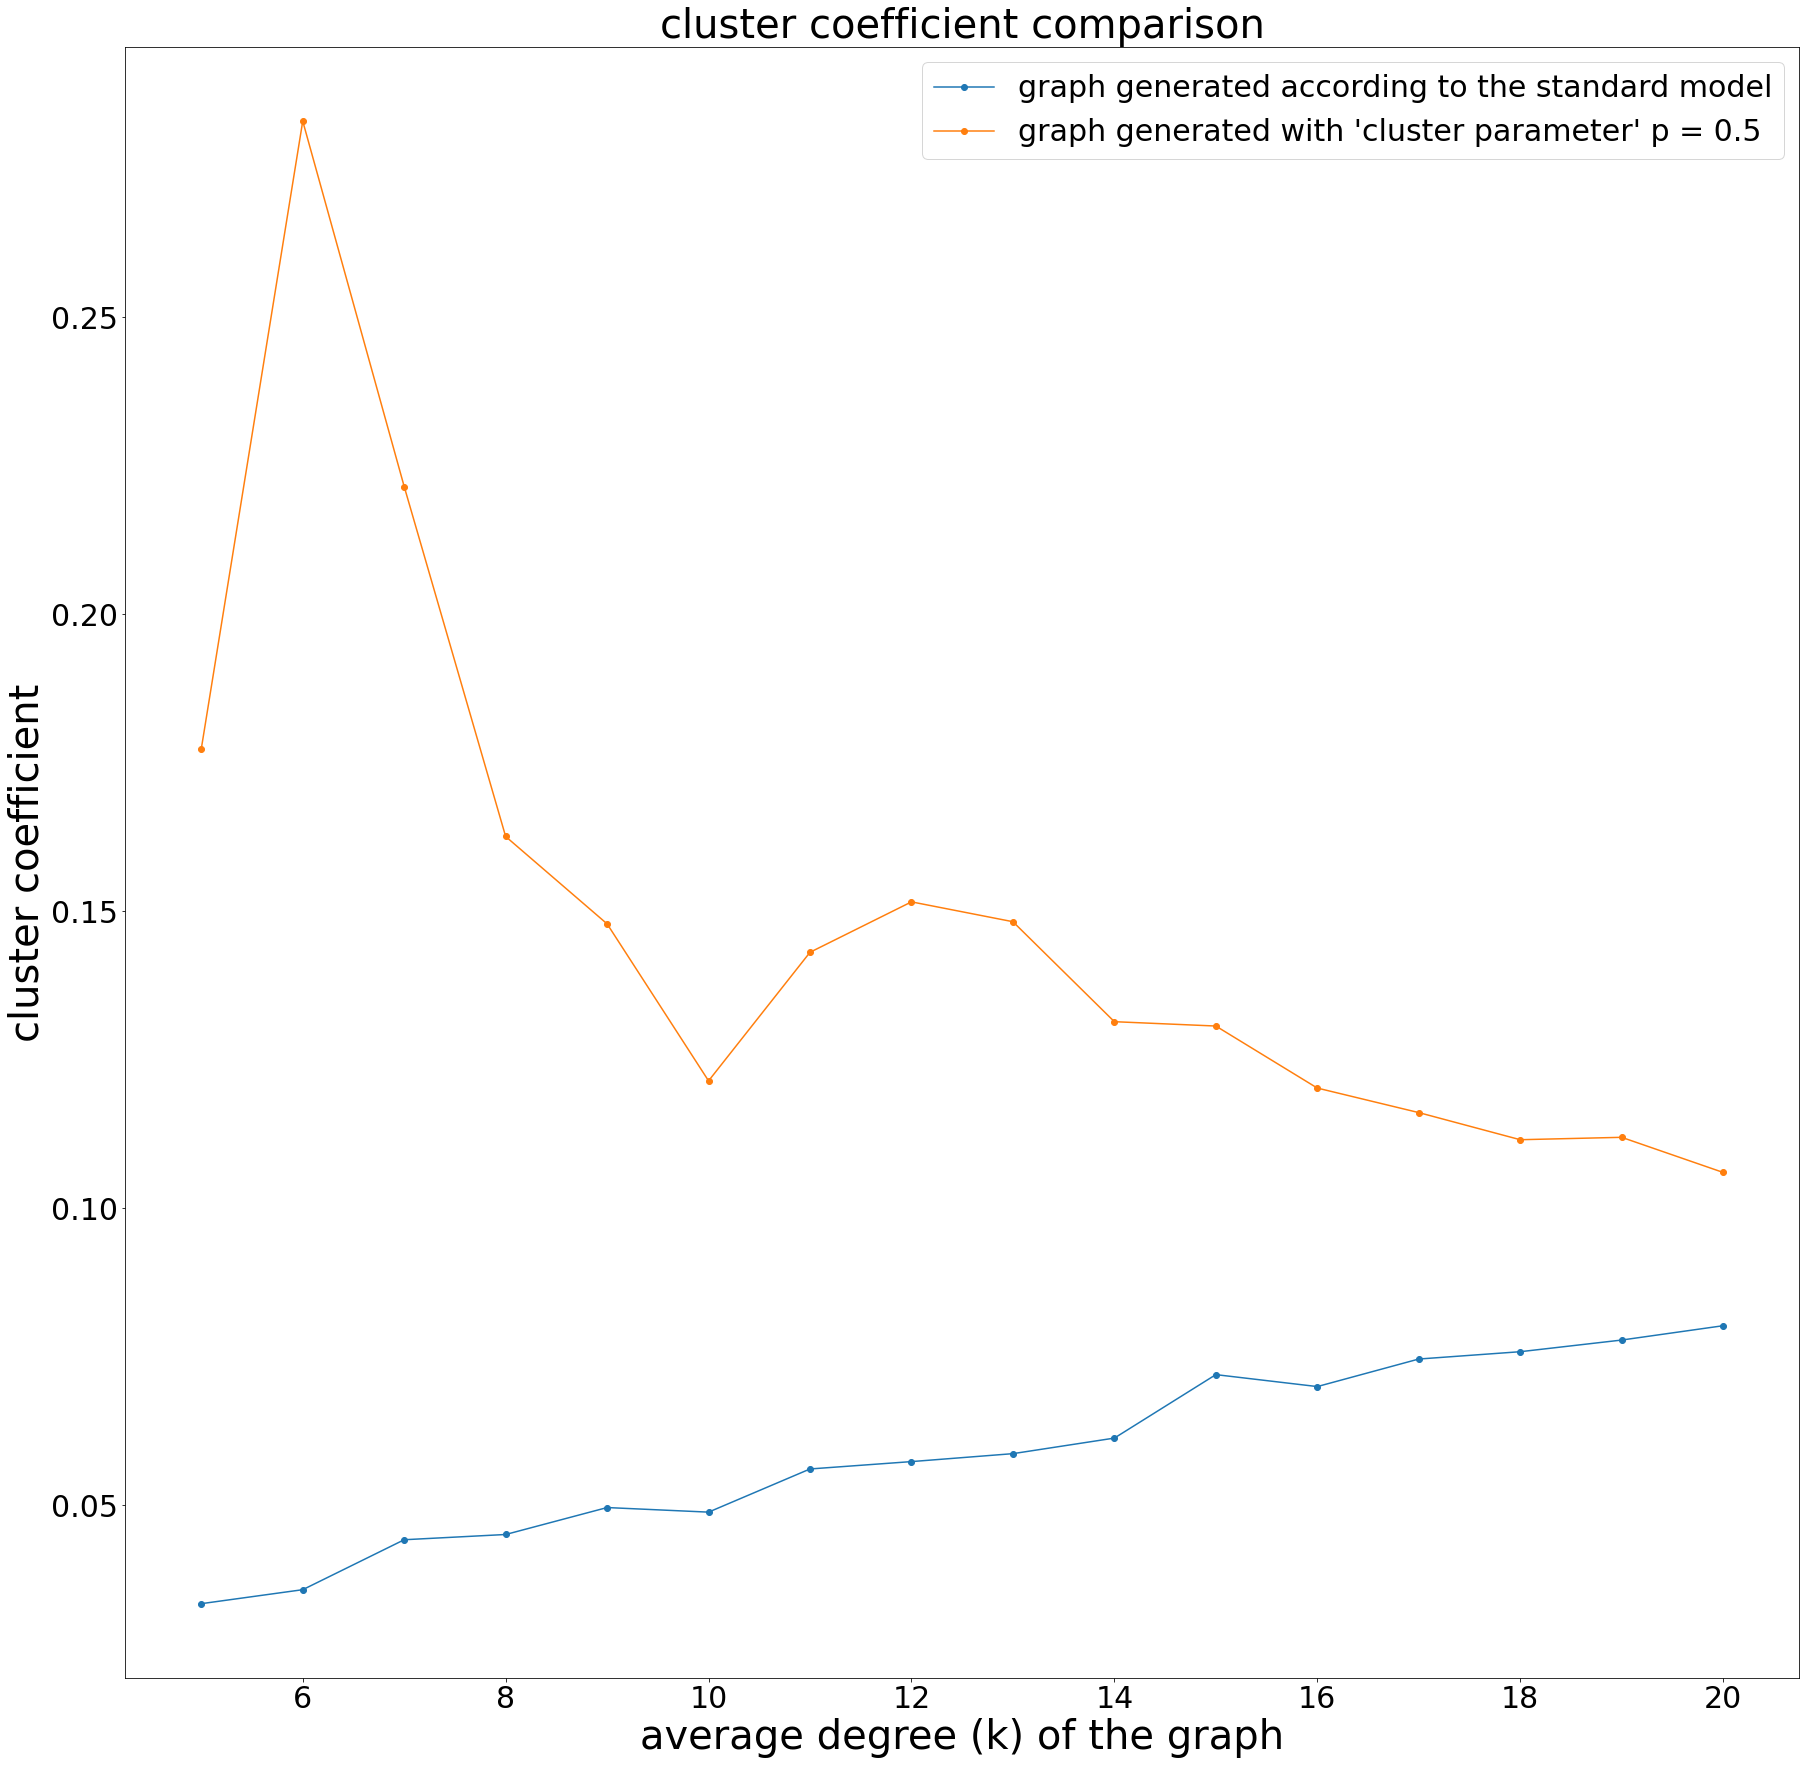

In [72]:
fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(5,21), coll1, '-o', label='graph generated according to the standard model')
plt.plot(np.arange(5,21), coll2, '-o', label="graph generated with 'cluster parameter' p = 0.5")
plt.title('cluster coefficient comparison', fontsize = 40)
plt.xlabel('average degree (k) of the graph', fontsize = 40)
plt.ylabel('cluster coefficient', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)
fig.savefig('images/' + 'img ' + str(500) + '.' + image_format, format=image_format)
img_counter += 1

In [74]:
# epidemic simulation with a graph generated with 'generate_gpa_clustering'

In [73]:
k = 15
n_simulations = 1000
weeks = 15
beta = 0.1
ro = 0.6

In [77]:
p = 0.25
cum_newly_infected = np.zeros((n_simulations, weeks))
for i in range(n_simulations):
    G = generate_gpa_clustering(n, k, p, demo=False)
    n_agents = len(G)
    W = nx.convert_matrix.to_numpy_matrix(G)

    states = simulate(A, W, beta, ro, inf_0[0], weeks, vacc_percentage=vacc, vaccination=True)
    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    
    cum_newly_infected[i] = newly_infected

print("RMSE =", RMSE(inf_0[1:], np.mean(cum_newly_infected,axis=0)))

RMSE = 4.133502085646393


In [81]:
p = 0.5
cum_newly_infected = np.zeros((n_simulations, weeks))
for i in range(n_simulations):
    G = generate_gpa_clustering(n, k, p, demo=False)
    n_agents = len(G)
    W = nx.convert_matrix.to_numpy_matrix(G)

    states = simulate(A, W, beta, ro, inf_0[0], weeks, vacc_percentage=vacc, vaccination=True)
    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    
    cum_newly_infected[i] = newly_infected

print("RMSE =", RMSE(inf_0[1:], np.mean(cum_newly_infected,axis=0)))

RMSE = 3.859570079373056


In [79]:
p = 0.75
cum_newly_infected = np.zeros((n_simulations, weeks))
for i in range(n_simulations):
    G = generate_gpa_clustering(n, k, p, demo=False)
    n_agents = len(G)
    W = nx.convert_matrix.to_numpy_matrix(G)

    states = simulate(A, W, beta, ro, inf_0[0], weeks, vacc_percentage=vacc, vaccination=True)
    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    
    cum_newly_infected[i] = newly_infected

print("RMSE =", RMSE(inf_0[1:], np.mean(cum_newly_infected,axis=0)))

RMSE = 4.348587352438648


## Epidemic simulation with best parameters found

In [82]:
n = 934
vacc = np.array([5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60])
vacc = np.insert(vacc,0,0) # by week i<0 0% of individuals is vaccinated
inf_0 = np.array([1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0])

n_simulations = 100

In [83]:
n_infected_initial = inf_0[0]
weeks = 15

In [6]:
A = {}
A['susceptible'] = 0
A['infected'] = 1
A['recovered'] = 2
A['susceptible but vaccinated'] = 3
A['infected but vaccinated'] = 4
A['recovered but vaccinated'] = 5
printmd("$\mathcal{A}$=")
for a in A:
    print(a + ": " + str(A[a]))
    
def is_vaccinated(n):
    return n>=3

def is_notVaccinated(n):
    return n<3

def administer_vaccinate(n):
    return n+3

def is_susceptible(n):
    return n%3==0

def is_infected(n):
    return n%3==1

def is_recovered(n):
    return n%3==2

def recover(n):
    return n+1

$\mathcal{A}$=

susceptible: 0
infected: 1
recovered: 2
susceptible but vaccinated: 3
infected but vaccinated: 4
recovered but vaccinated: 5


In [85]:
k = 15
beta = 0.1
ro = 0.6

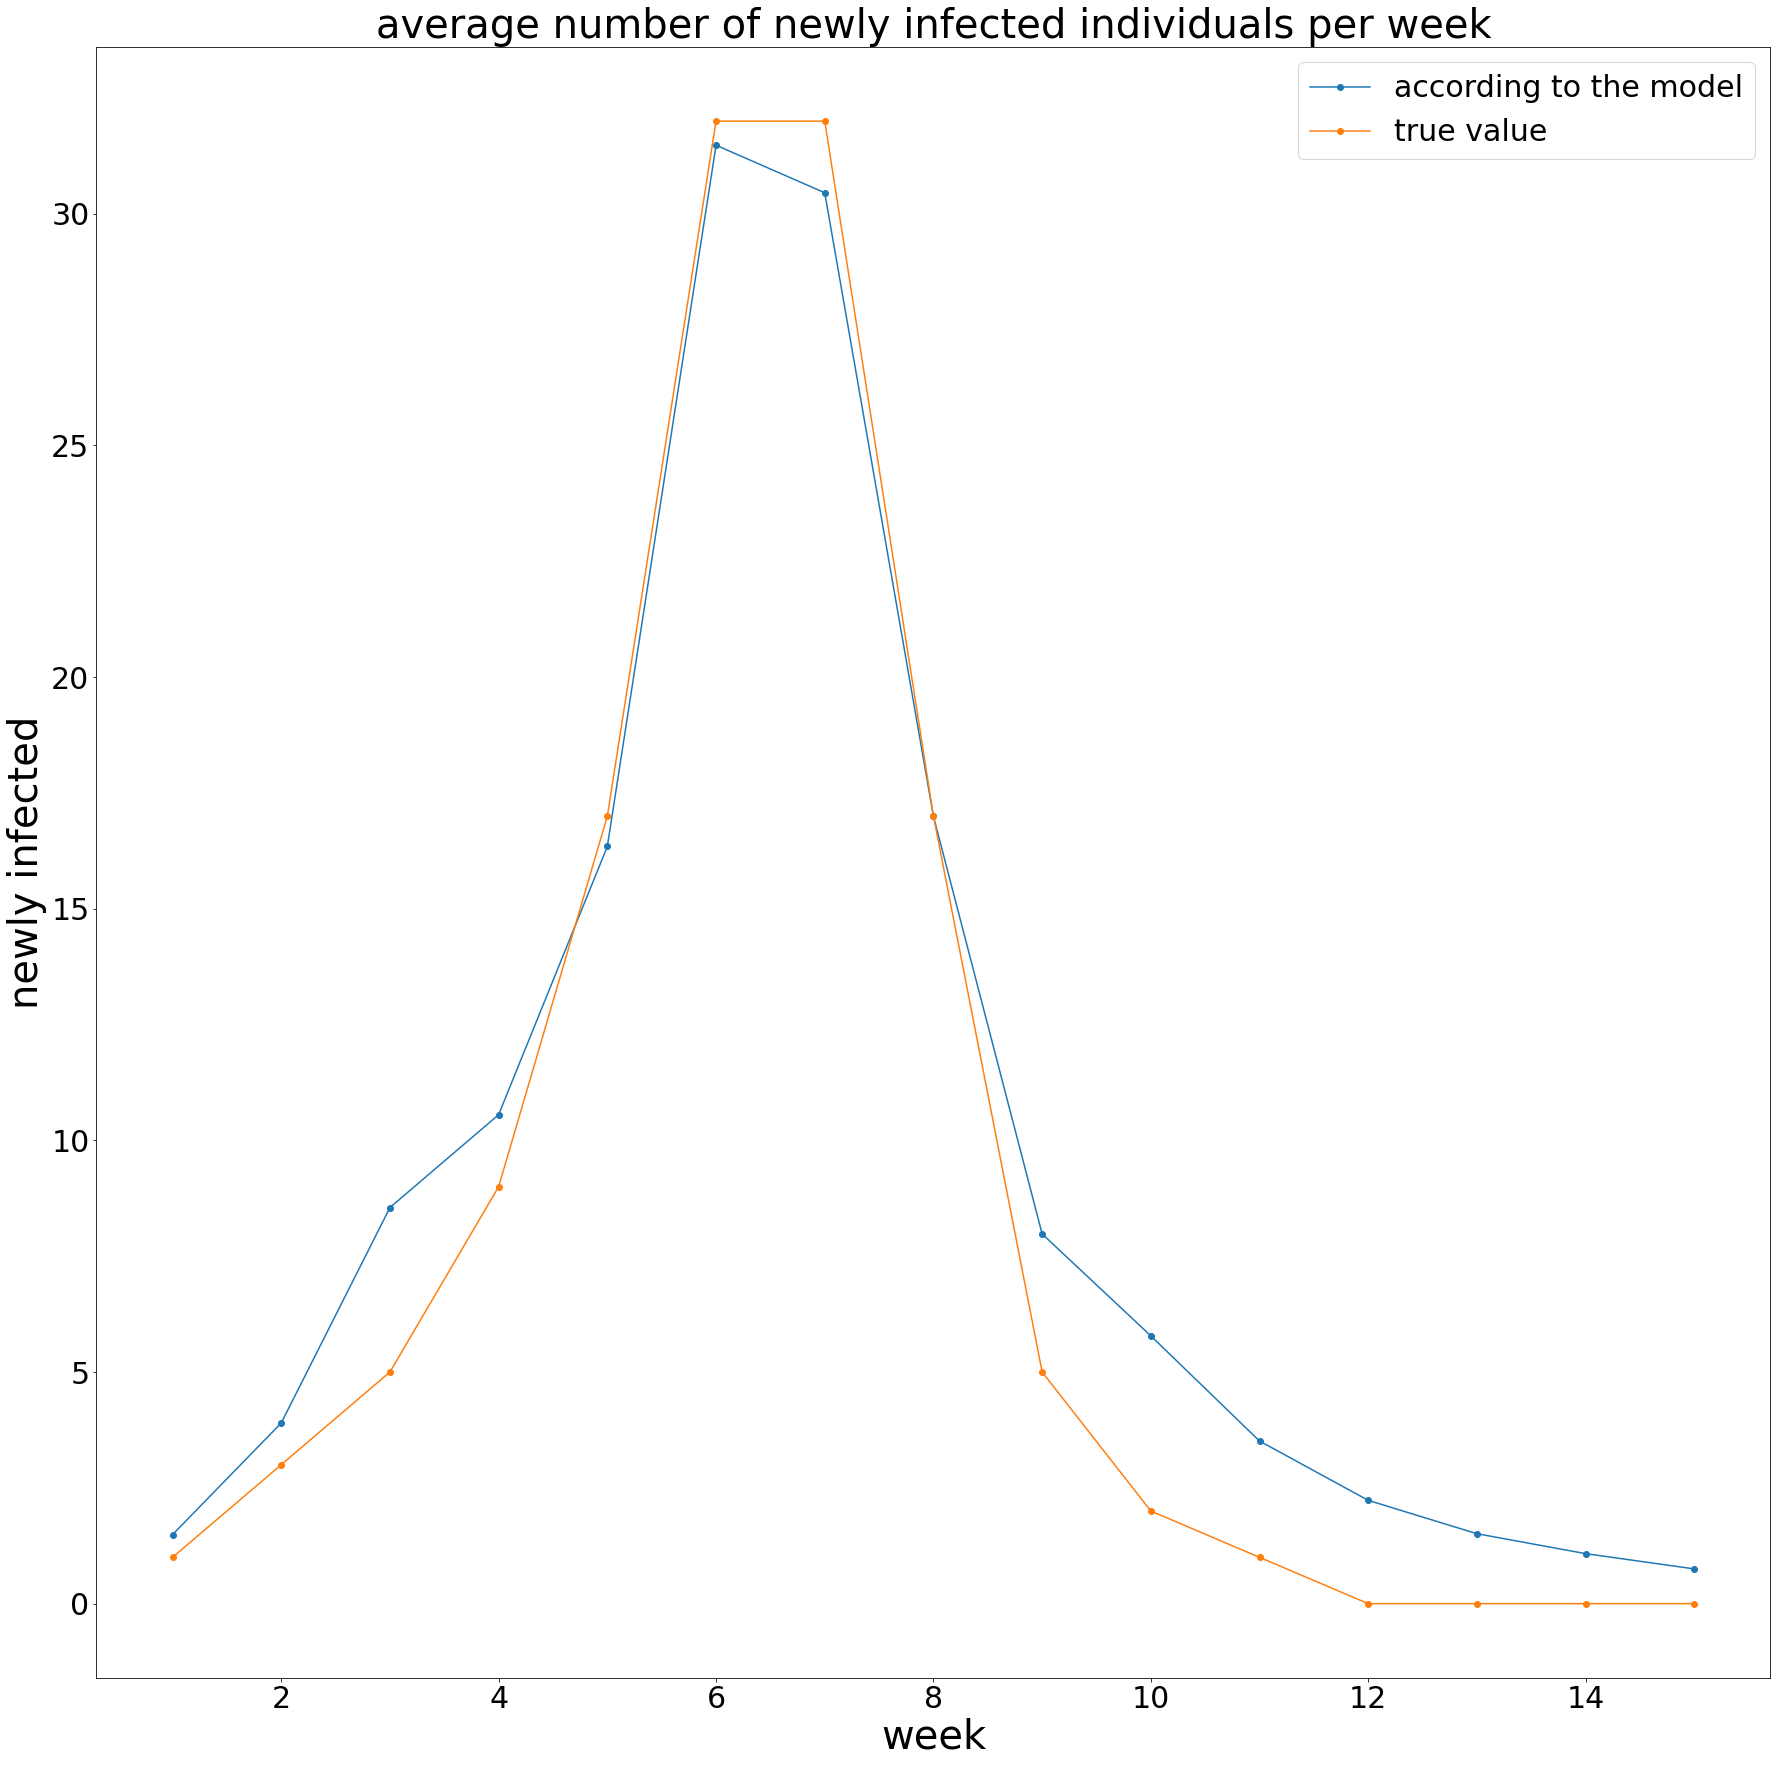

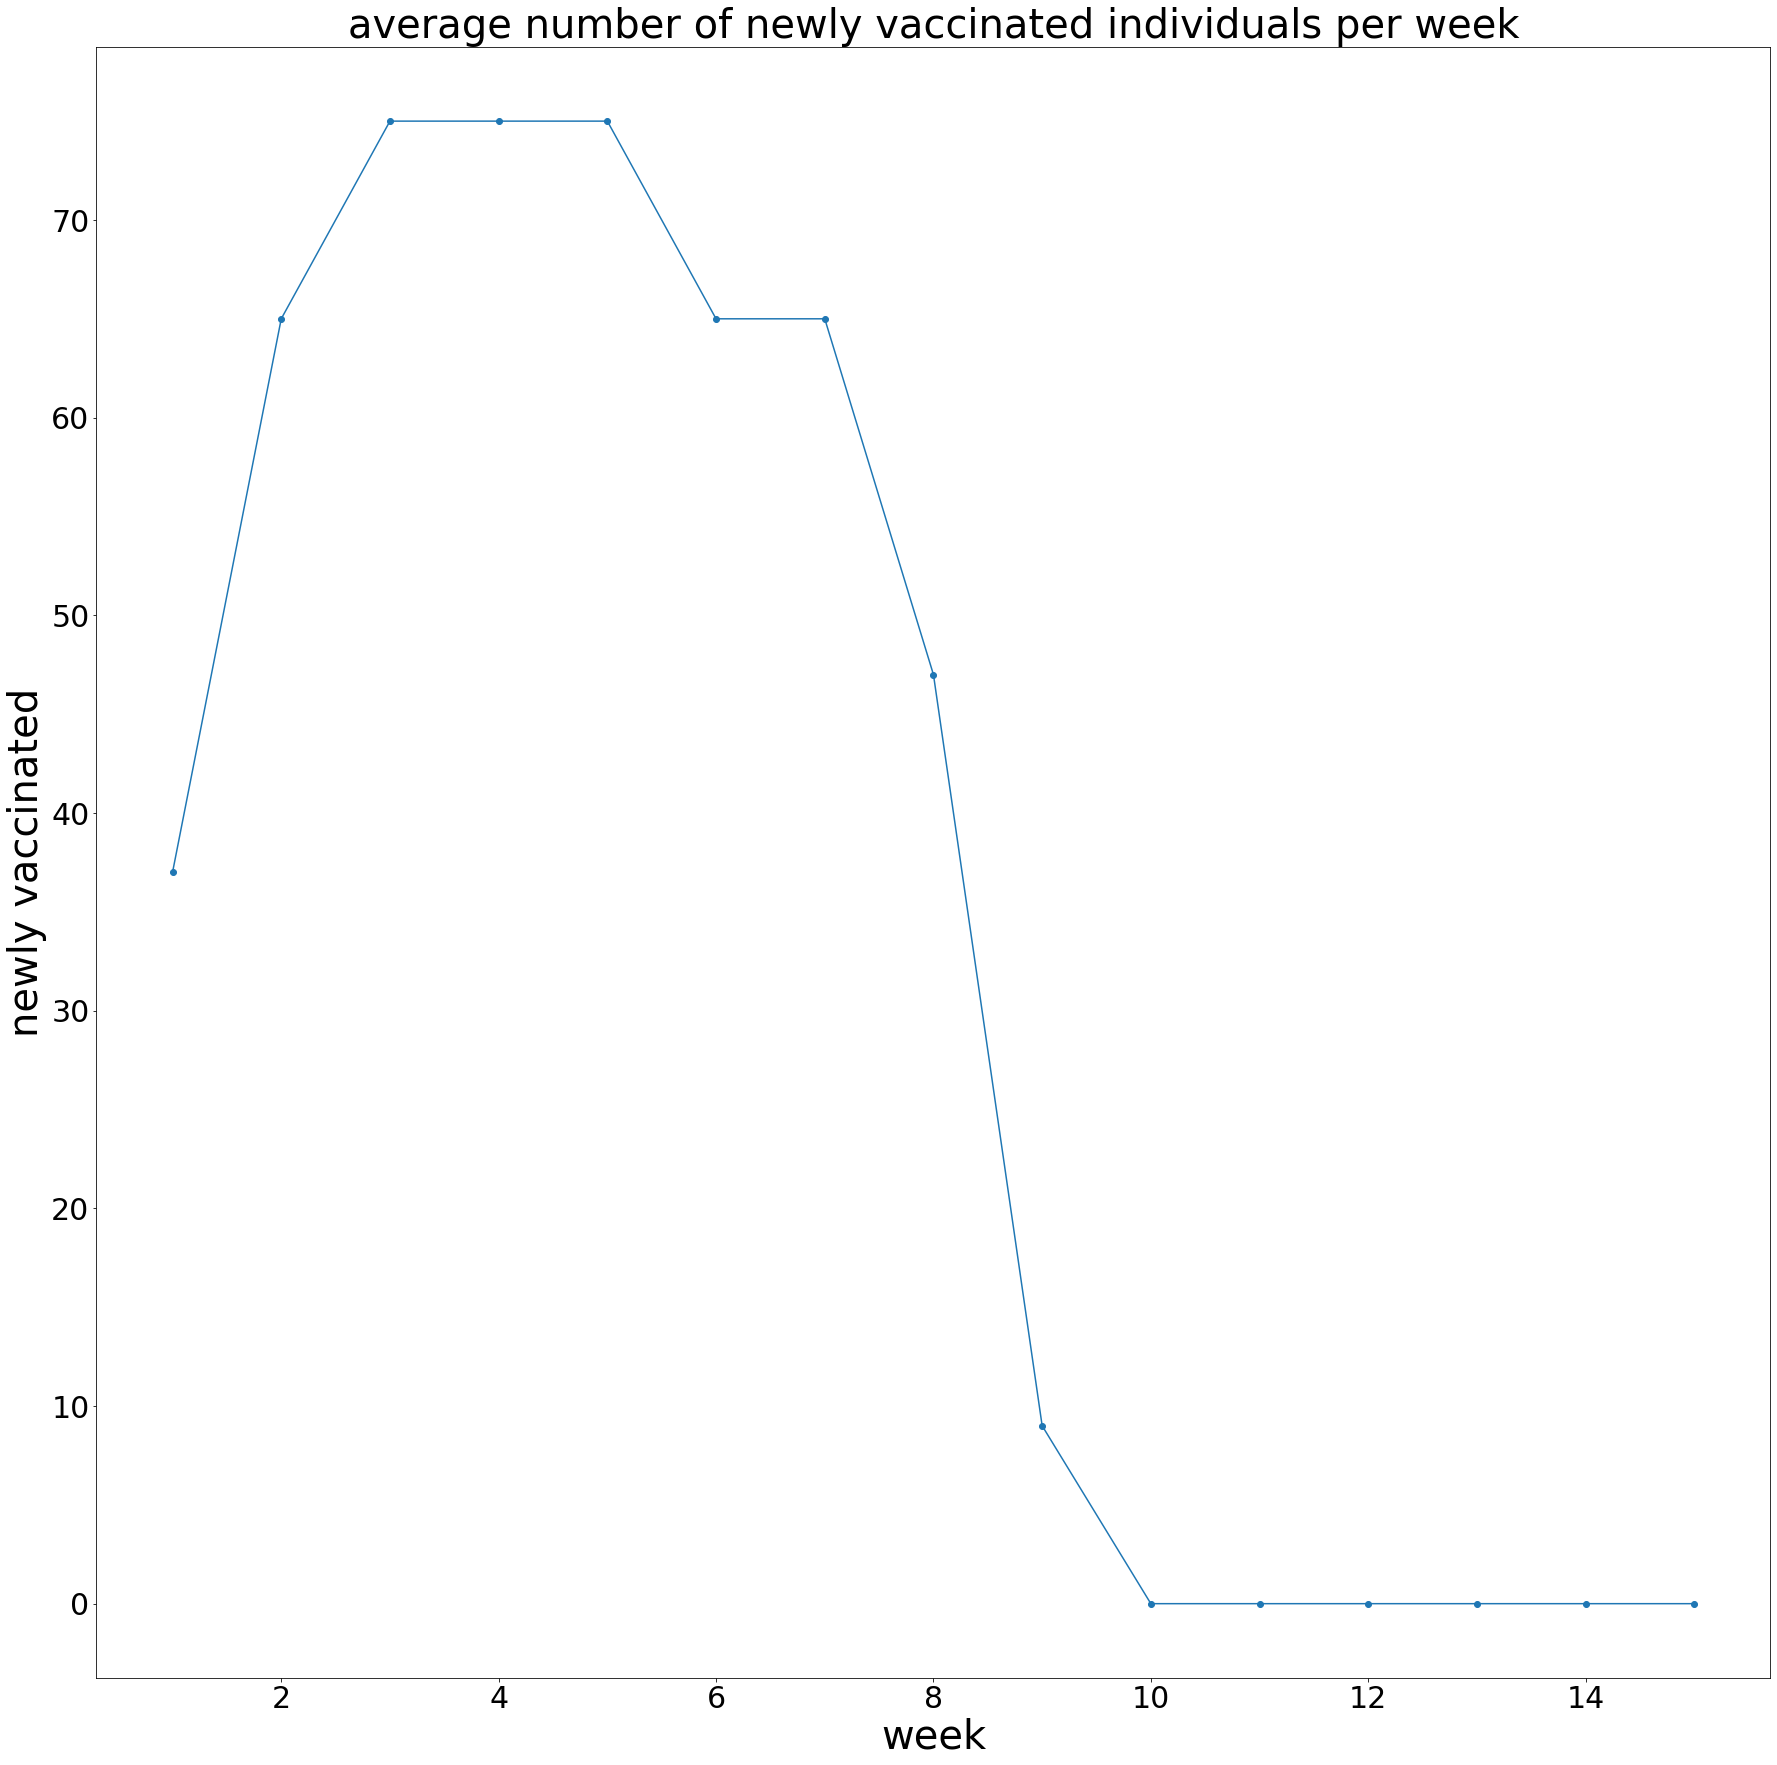

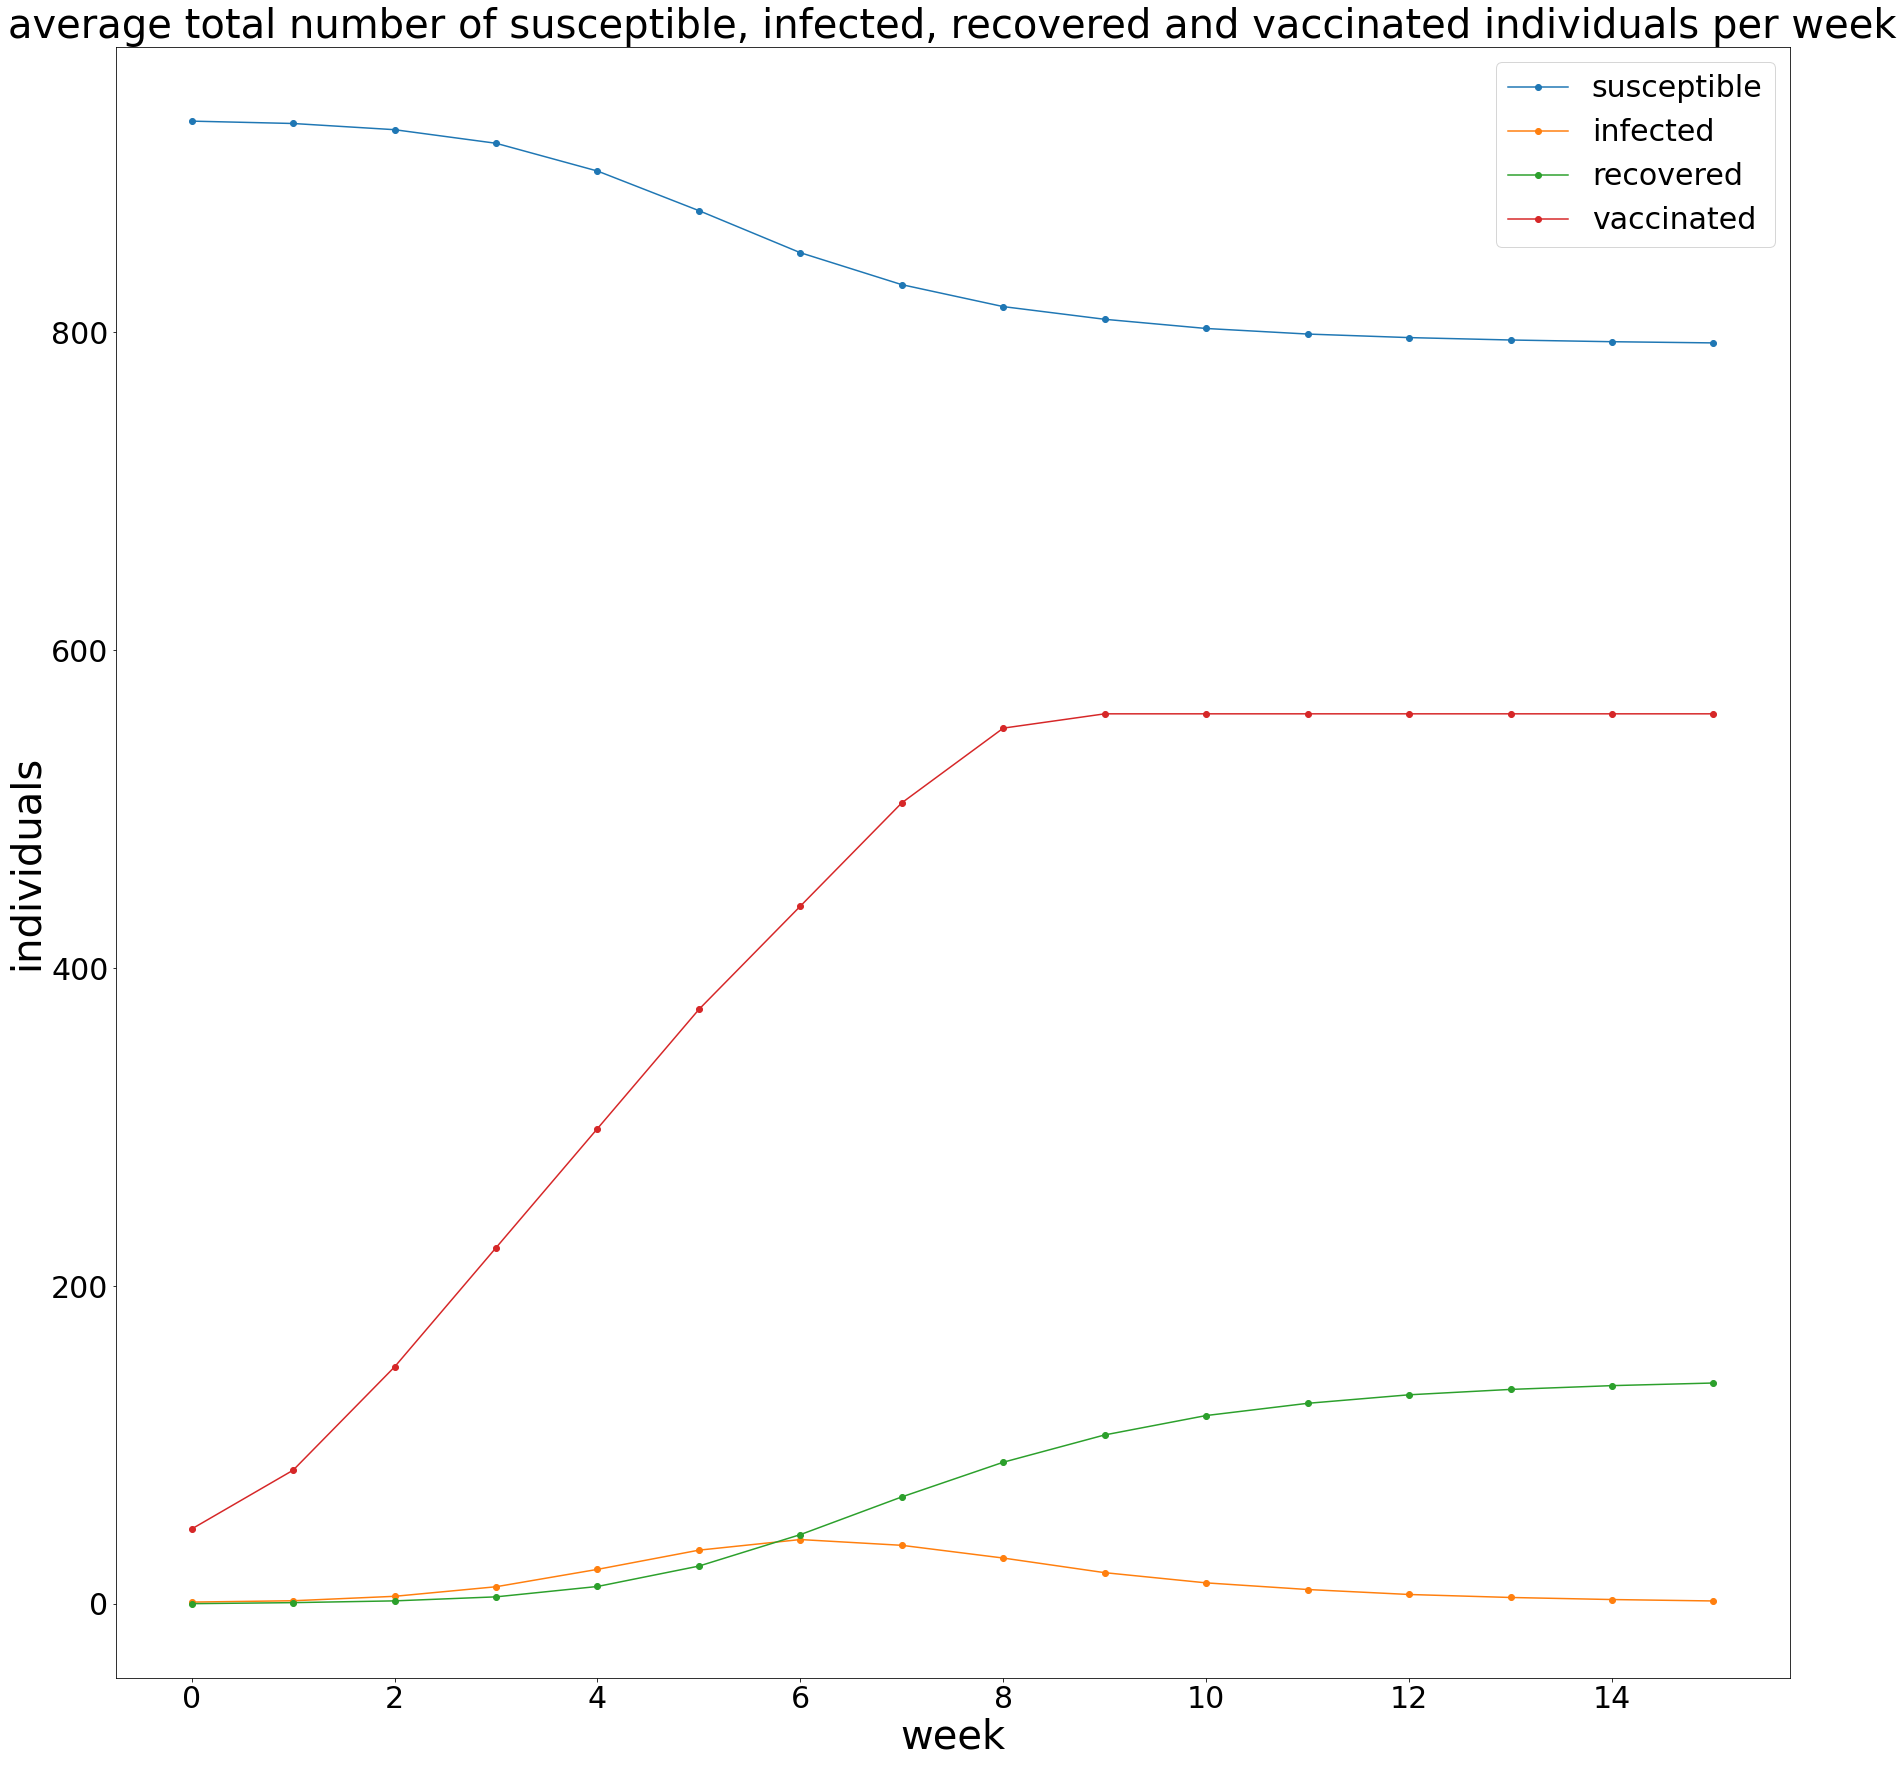

In [93]:
stats = np.zeros((len(A)-2, n_simulations, weeks+1))
cum_newly_infected = np.zeros((n_simulations, weeks))
cum_newly_vaccinated = np.zeros((n_simulations, weeks))
A_rev = dict((v,k) for k,v in A.items())
for i in range(n_simulations):
    G = generate_gpa(n, k, demo=False)
    n_agents = len(G)
    W = nx.convert_matrix.to_numpy_matrix(G)
    states = simulate(A, W, beta, ro, inf_0[0], weeks, vacc_percentage=vacc, vaccination=True)
    newly_infected = np.array([np.sum(np.logical_and(is_susceptible(states[i-1]), is_infected(states[i]))) for i in range(1, weeks+1)]) # newly infected agent are such that at time unit i-1 they were suscptible and at time unit i they are infected
    newly_vaccinated = np.array([np.sum(np.logical_and(is_notVaccinated(states[i-1]), is_vaccinated(states[i]))) for i in range(1, weeks+1)]) # newly vaccinated agent are such that at time unit i-1 they were not vaccinated and at time unit i they are vaccinated
    n_susc_per_week = np.sum(is_susceptible(states),axis=1)
    n_inf_per_week = np.sum(is_infected(states),axis=1)
    n_rec_per_week = np.sum(is_recovered(states),axis=1)
    n_vac_per_week = np.sum(is_vaccinated(states),axis=1)
    cum_newly_infected[i] = newly_infected
    cum_newly_vaccinated[i] = newly_vaccinated
    stats[0,i] = n_susc_per_week
    stats[1,i] = n_inf_per_week
    stats[2,i] = n_rec_per_week
    stats[3,i] = n_vac_per_week
    
avg_newly_infected = np.mean(cum_newly_infected,axis=0)
avg_newly_vaccinated = np.mean(cum_newly_vaccinated,axis=0)
avg_stats = np.mean(stats,axis=1)

fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_infected, '-o', label = 'according to the model')
plt.plot(np.arange(1,weeks+1), inf_0[1:], '-o', label = 'true value')

plt.title('average number of newly infected individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly infected', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1


fig = plt.figure(figsize=(30, 30))
plt.plot(np.arange(1,weeks+1), avg_newly_vaccinated, '-o')

plt.title('average number of newly vaccinated individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('newly vaccinated', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1
    

fig = plt.figure(figsize=(30, 30))
for state in range(len(A)-2):
    lab = A_rev[state]
    if state==3:
        lab  ='vaccinated'
    plt.plot(np.arange(weeks+1), avg_stats[state], '-o', label = lab)

plt.title('average total number of susceptible, infected, recovered and vaccinated individuals per week', fontsize = 40)
plt.xlabel('week', fontsize = 40)
plt.ylabel('individuals', fontsize = 40)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)

fig.savefig(img_dir + 'img ' + str(img_counter) + '.' + image_format, format=image_format)
img_counter += 1